In [2]:
import os
import shutil
import re

# Paths
overlap_list_file = "/kaggle/input/insect/overlap_report.txt"
roi_img_dir = "/kaggle/input/insect/patches_320x320/patches_320x320"
output_dir = "/kaggle/working/roi_extracted"

os.makedirs(output_dir, exist_ok=True)

def natural_sort_key(s):
    parts = re.split(r"(\d+)", s)
    return [int(p) if p.isdigit() else p.lower() for p in parts]

# Read XML names from list
with open(overlap_list_file, "r") as f:
    xml_files = [line.strip() for line in f if line.strip().endswith(".xml")]

mapping = {}  # Dictionary: xml → list of ROI images

for xml_file in xml_files:
    xml_prefix = xml_file[:-4]  # remove .xml

    # Find ROI images that match the XML prefix
    roi_images = [
        f for f in os.listdir(roi_img_dir)
        if f.startswith(xml_prefix)
    ]

    roi_images.sort(key=natural_sort_key)

    # Save mapping
    mapping[xml_file] = roi_images

    # Copy images to output folder
    for img_name in roi_images:
        src = os.path.join(roi_img_dir, img_name)
        dst = os.path.join(output_dir, img_name)
        shutil.copy2(src, dst)

    print(f"Copied {len(roi_images)} ROI images for {xml_file}")

print("\n Done! All matched images saved to:", output_dir)


Copied 90 ROI images for Day18-03_frame1-20250407-17.00-06.19-18-17-18.xml
Copied 30 ROI images for Day41-02_frame1-20250430-17.00-06.19-41-40-41.xml
Copied 34 ROI images for Day46-03_full-frame-20250505-17.00-06.25-46-45-46.xml
Copied 43 ROI images for Day41-01_full-frame-20250430-17.00-06.25-41-40-41.xml
Copied 104 ROI images for Day20-03_frame3-20250409-17.00-06.19-20-19-20.xml
Copied 54 ROI images for Day29-03_full-frame-20250418-17.00-06.25-29-28-29.xml
Copied 138 ROI images for Day33-02_full-frame-20250422-17.00-06.25-33-32-33.xml
Copied 29 ROI images for Day06-01_full-frame-20250325-17.00-06.23-6-5-6.xml
Copied 114 ROI images for Day19-02_full-frame-20250408-17.00-06.25-19-18-19.xml
Copied 63 ROI images for Day23-03_frame1-20250412-17.00-06.19-23-22-23.xml
Copied 28 ROI images for Day50-01_frame1-20250509-17.00-06.19-50-49-50.xml
Copied 28 ROI images for Day50-02_frame1-20250509-17.00-06.19-50-49-50.xml
Copied 27 ROI images for Day41-03_frame1-20250430-17.00-06.19-41-40-41.xml
C

Found 13518 ROI images.


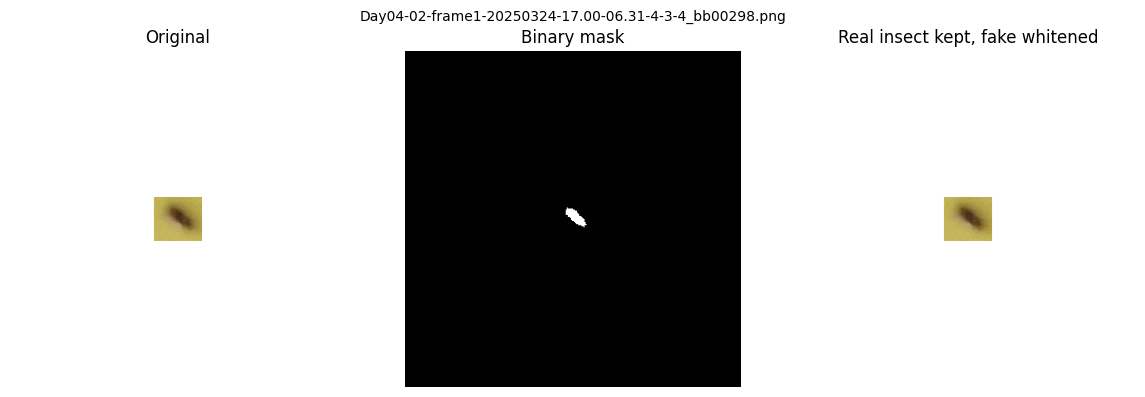

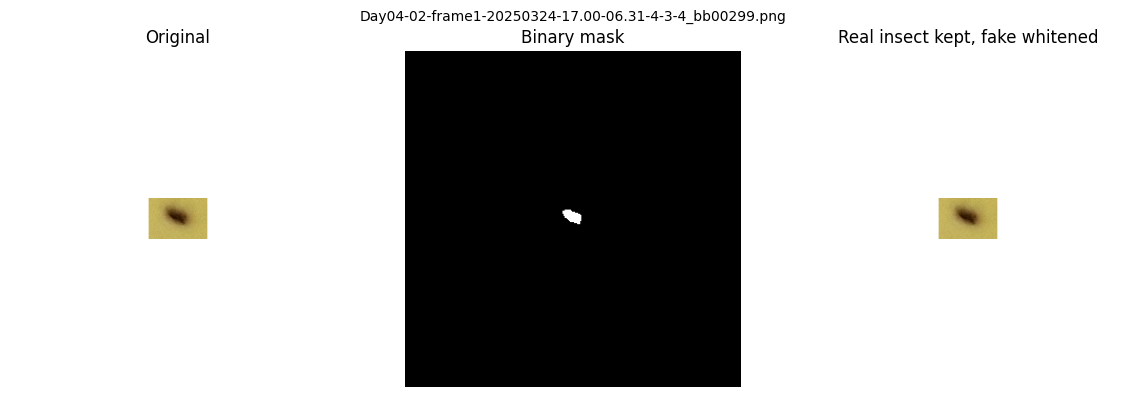

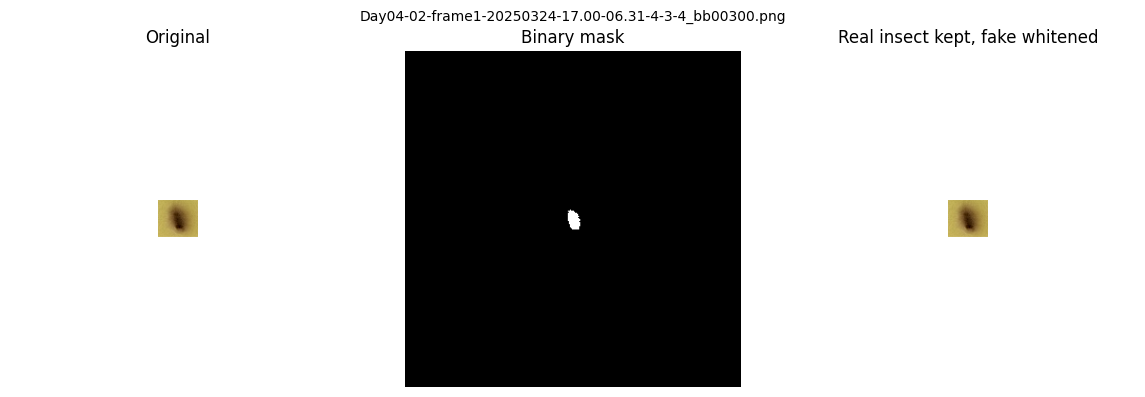

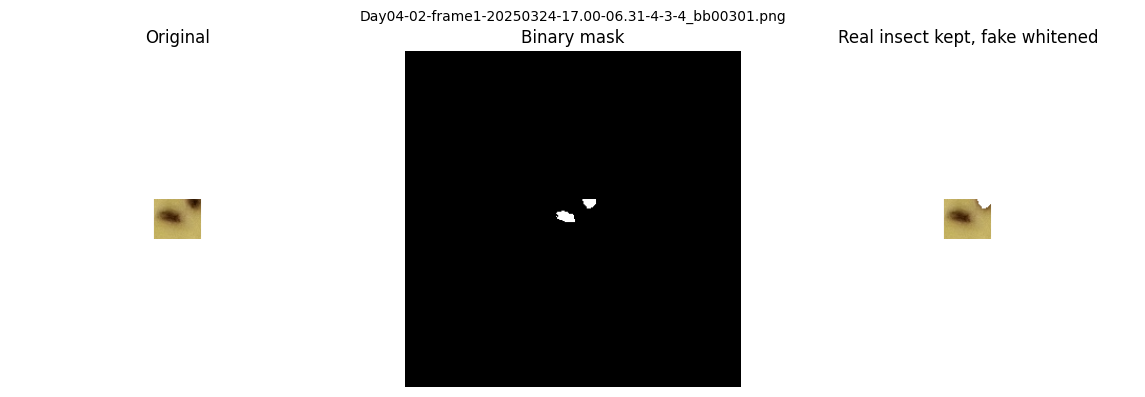

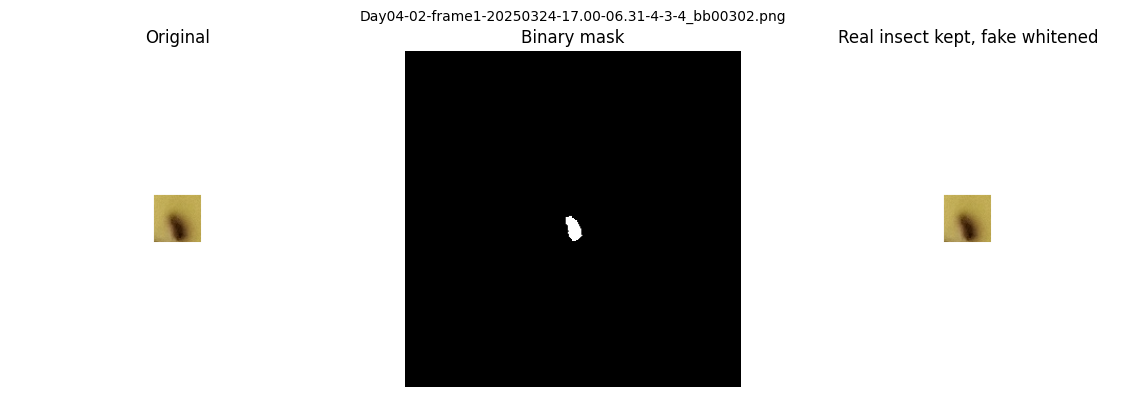

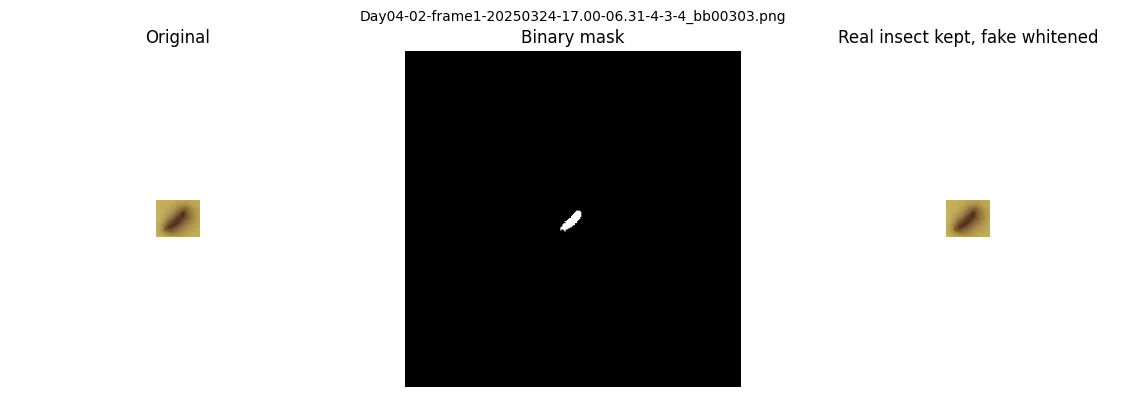

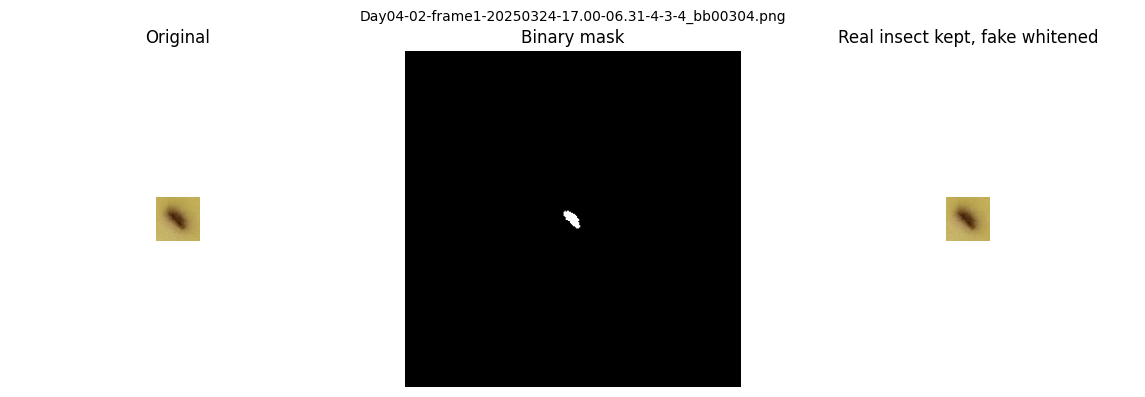

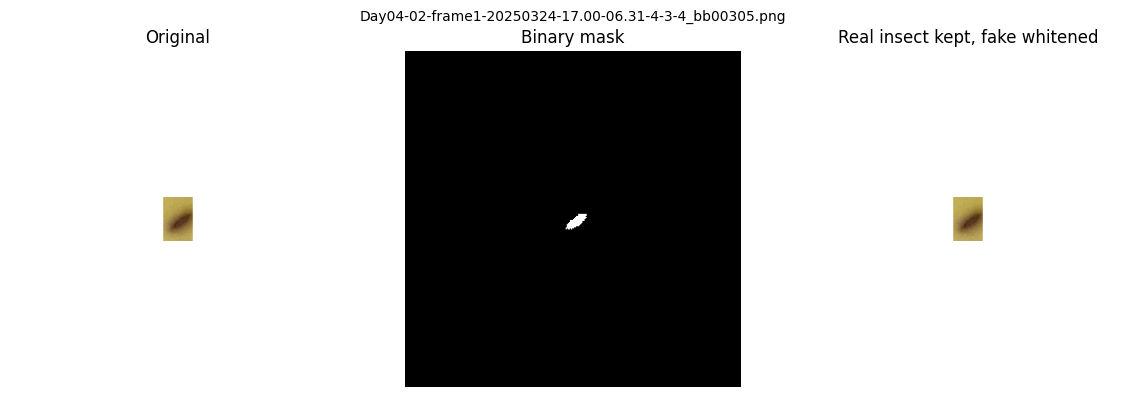

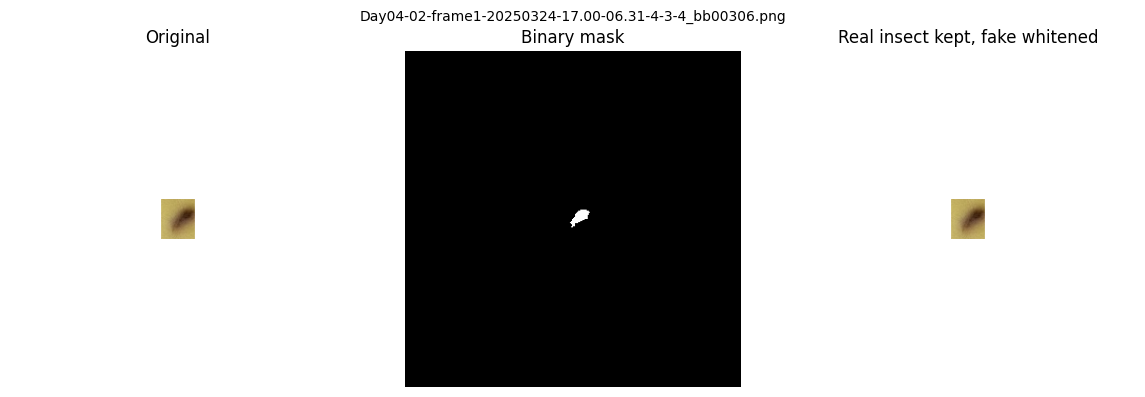

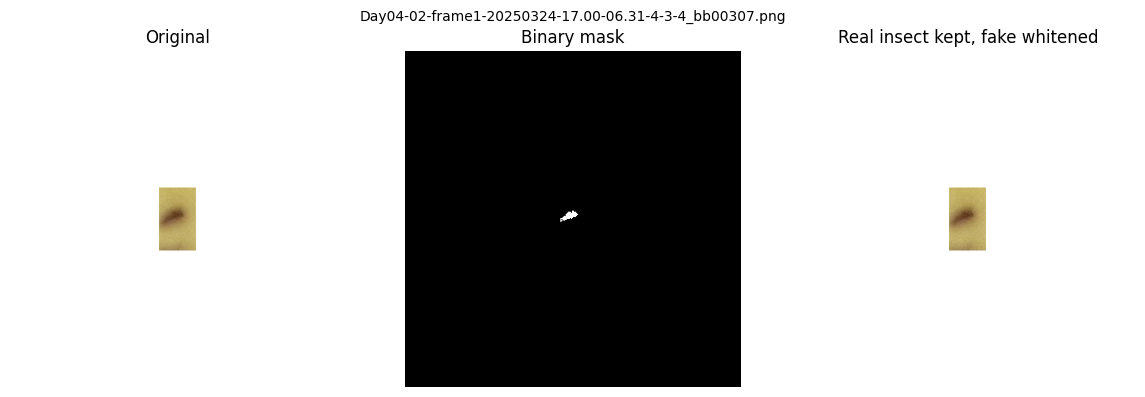

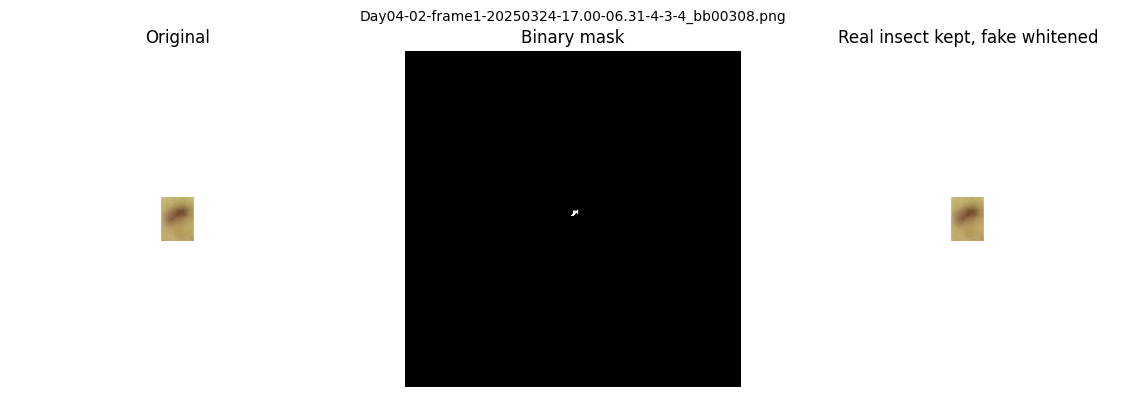

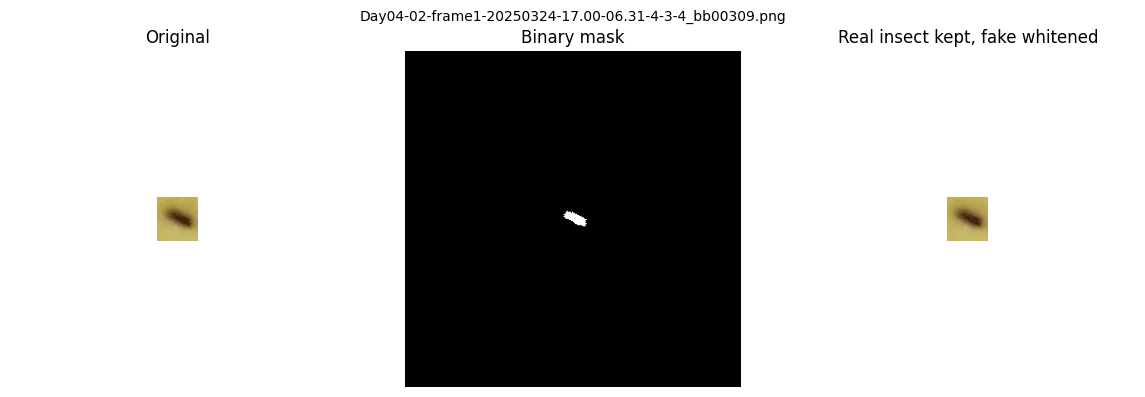

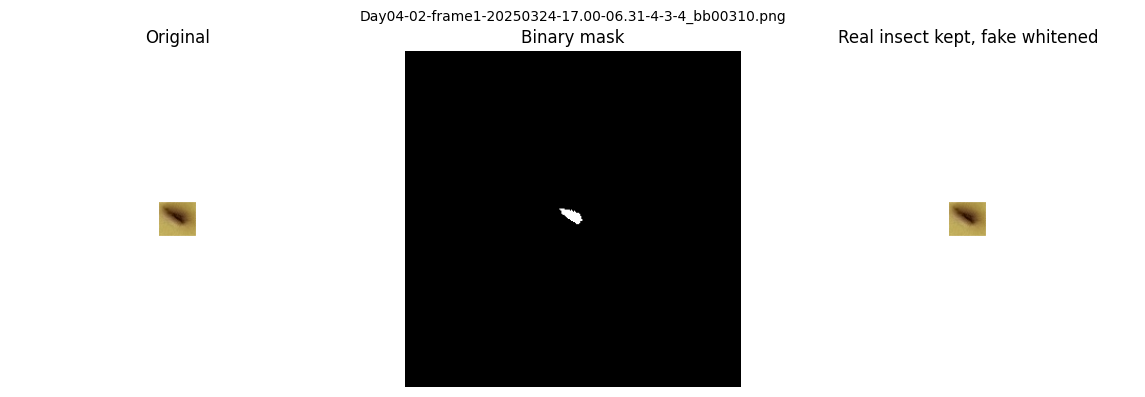

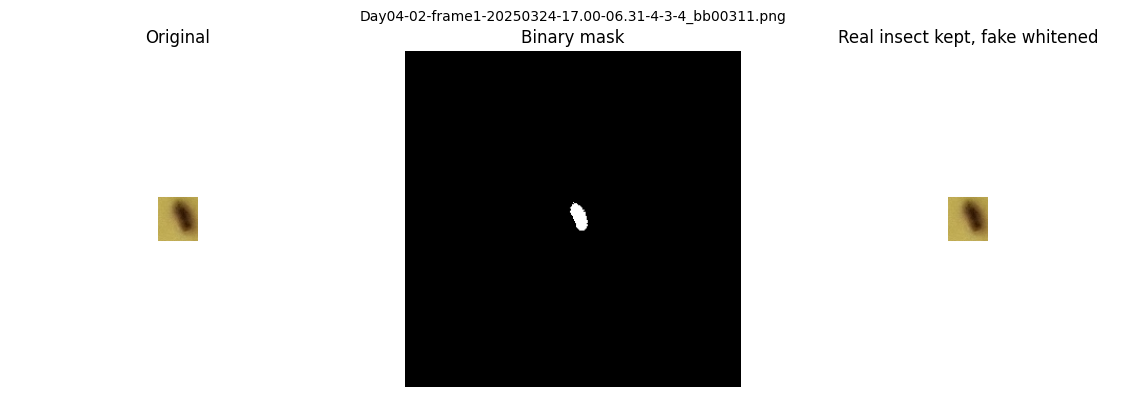

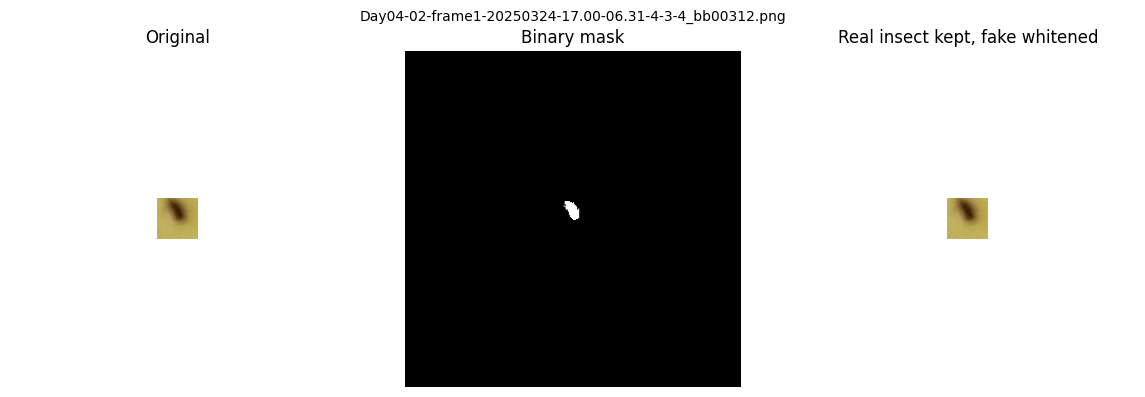

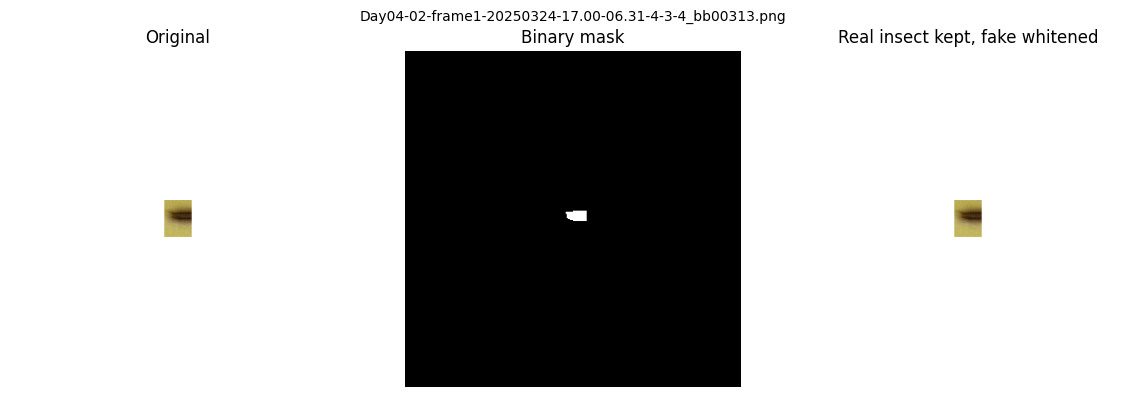

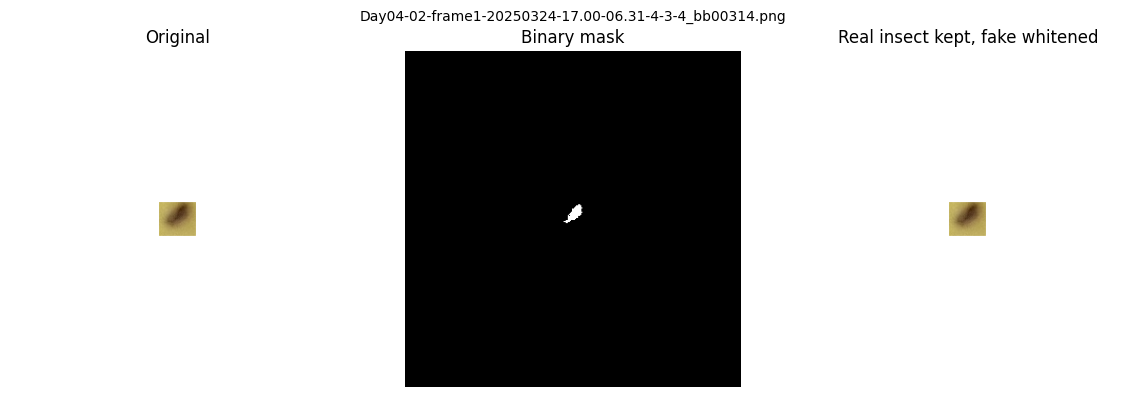

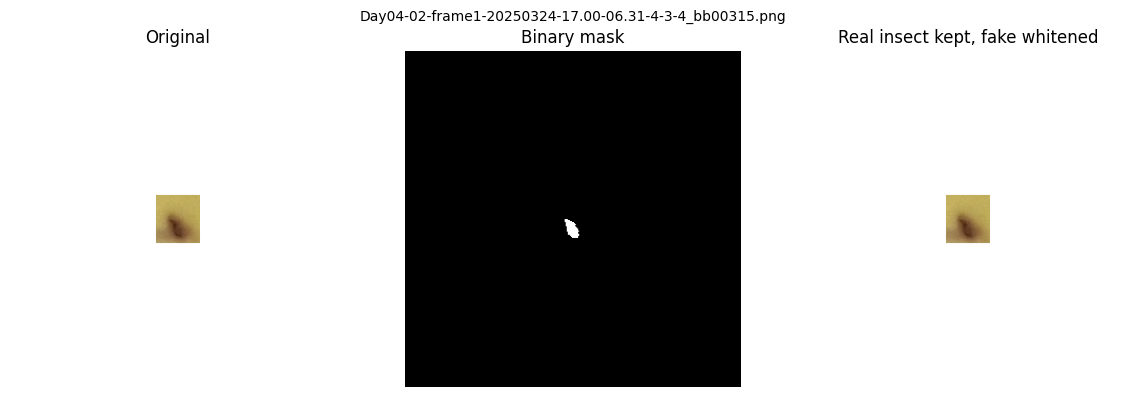

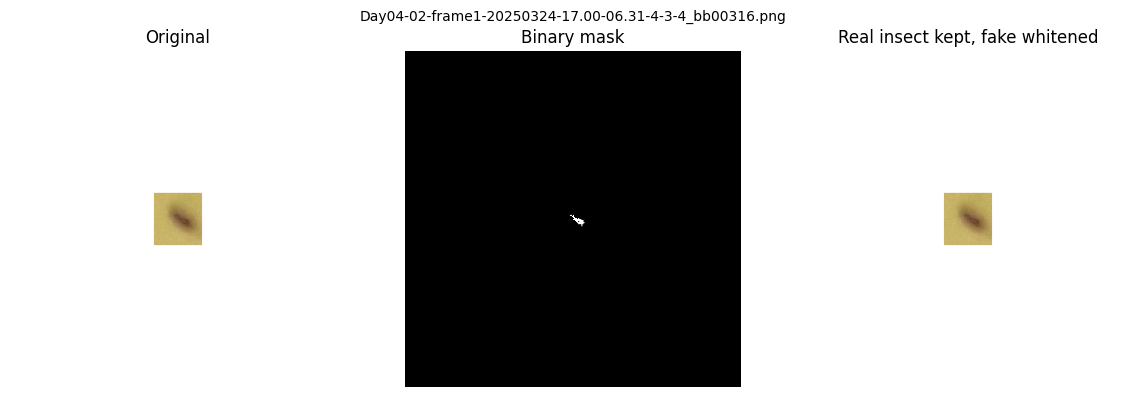

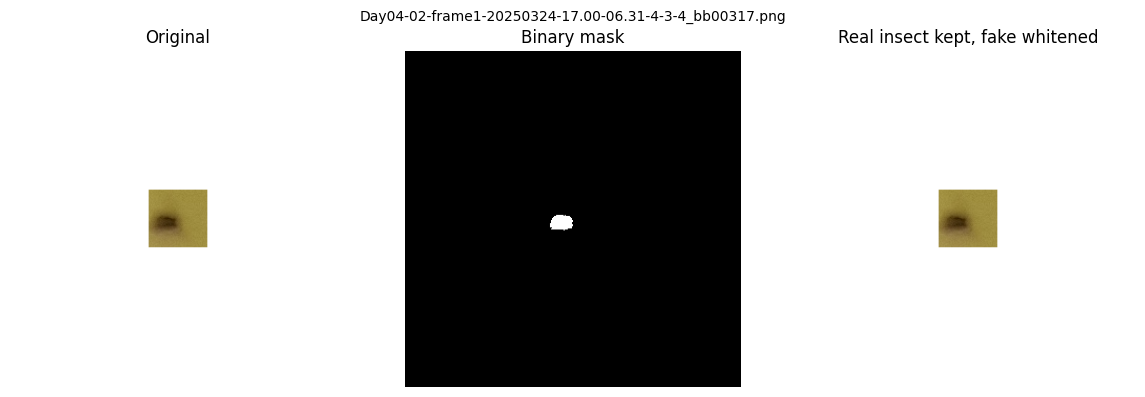

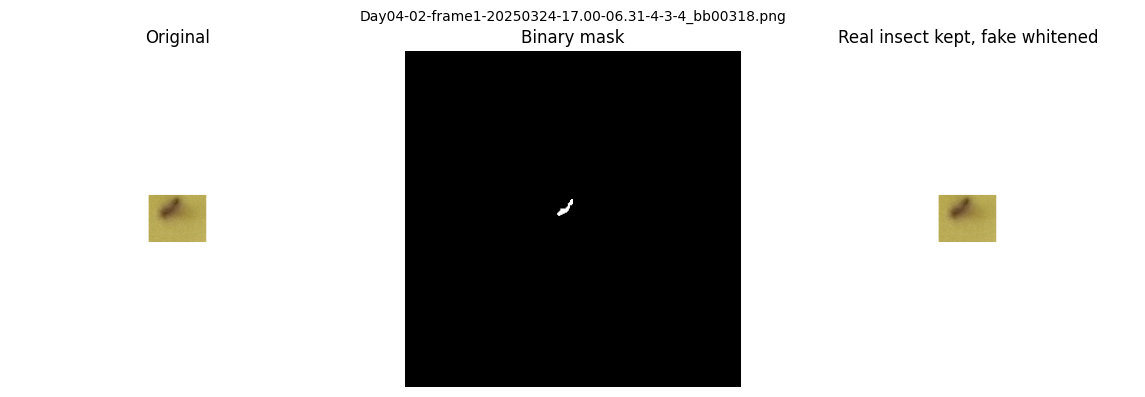

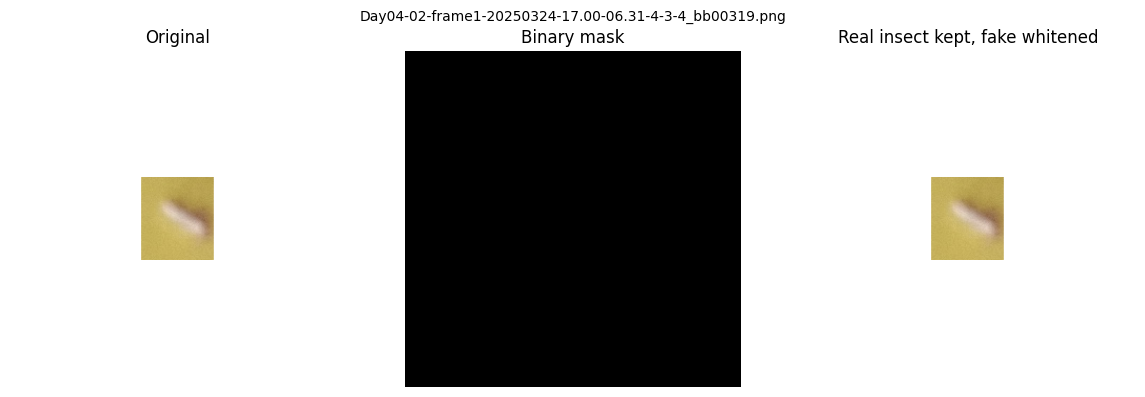

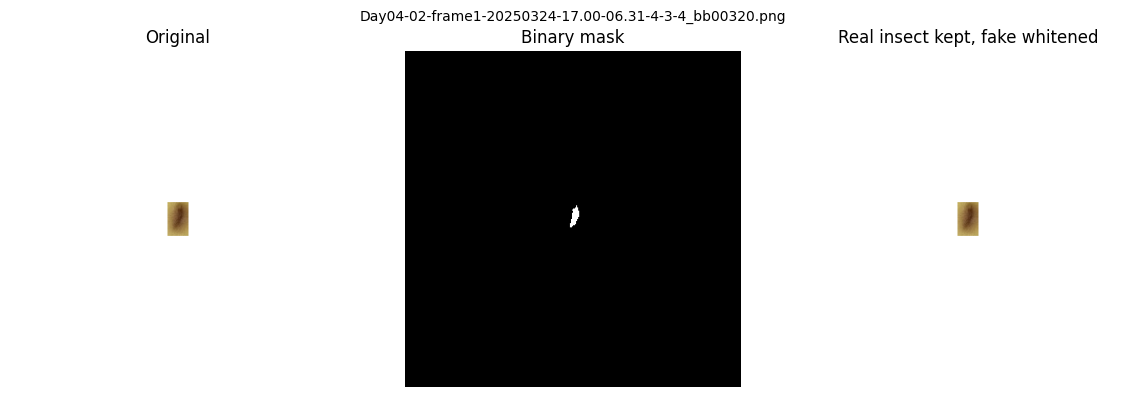

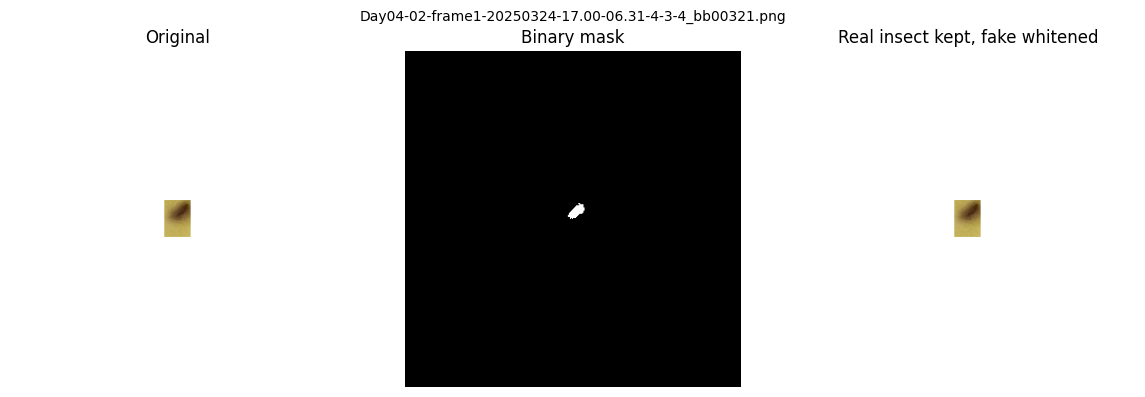

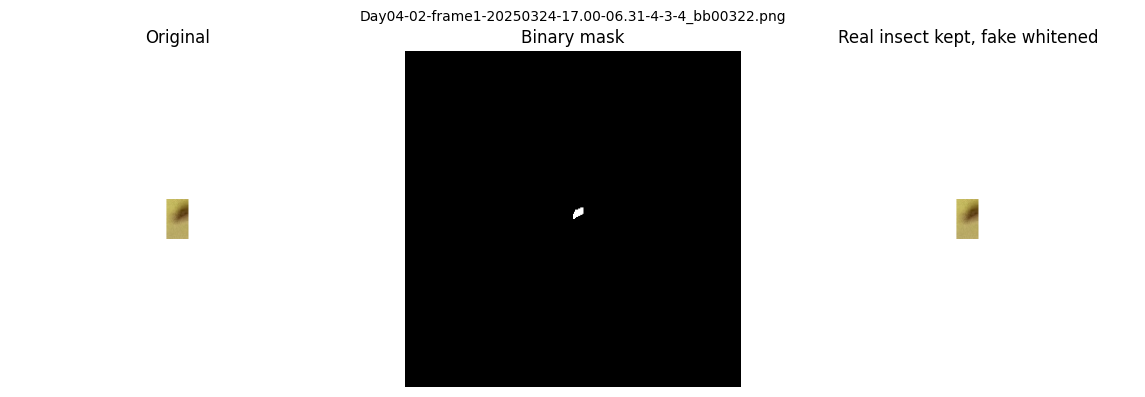

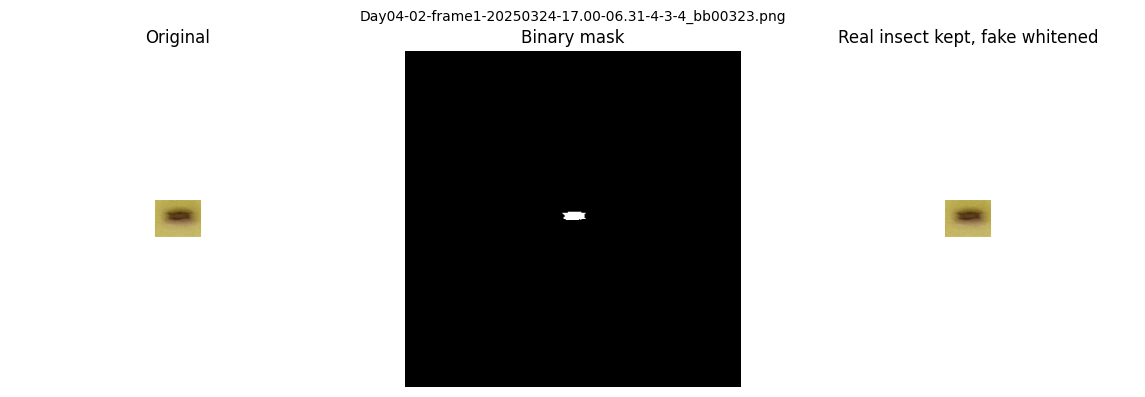

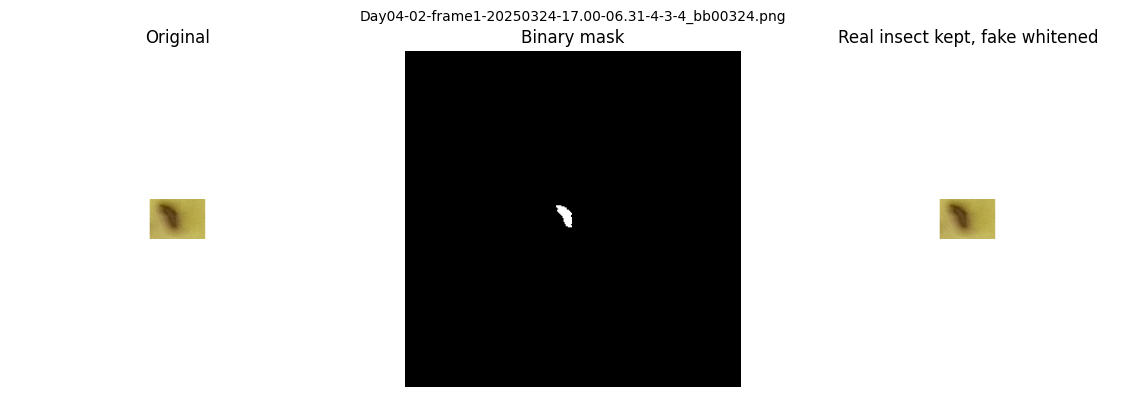

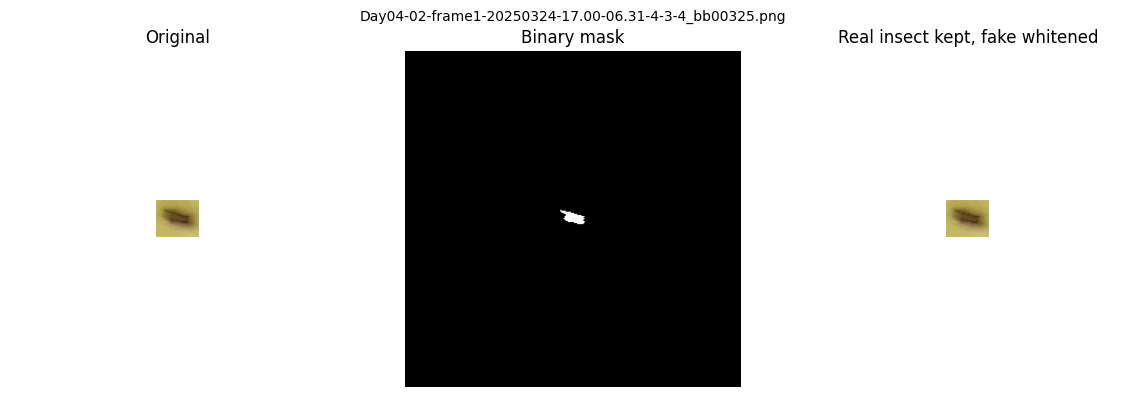

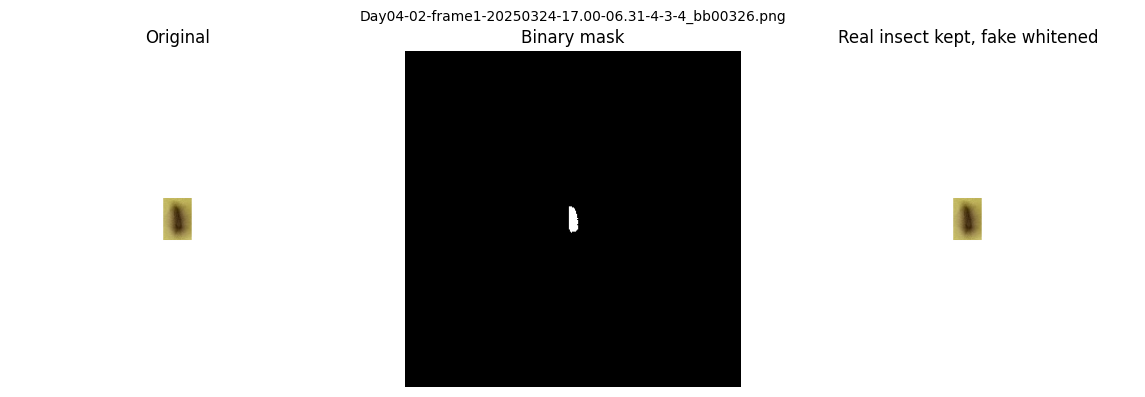

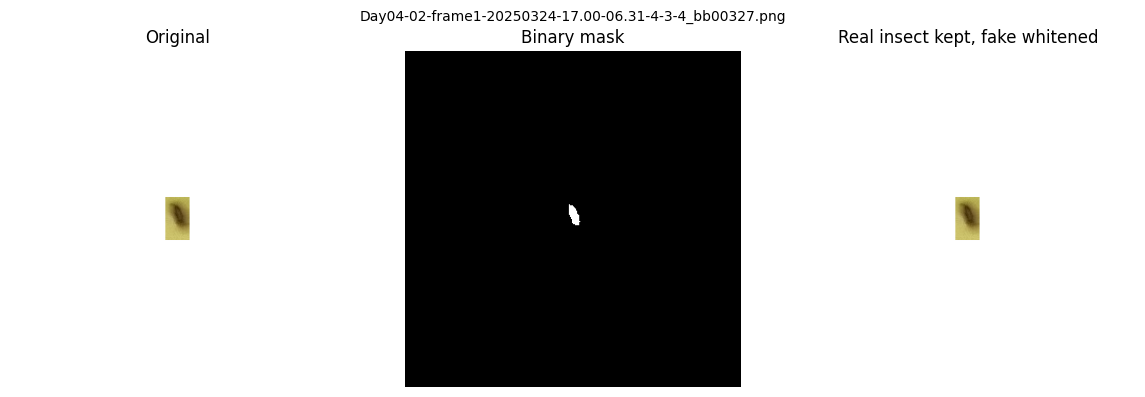

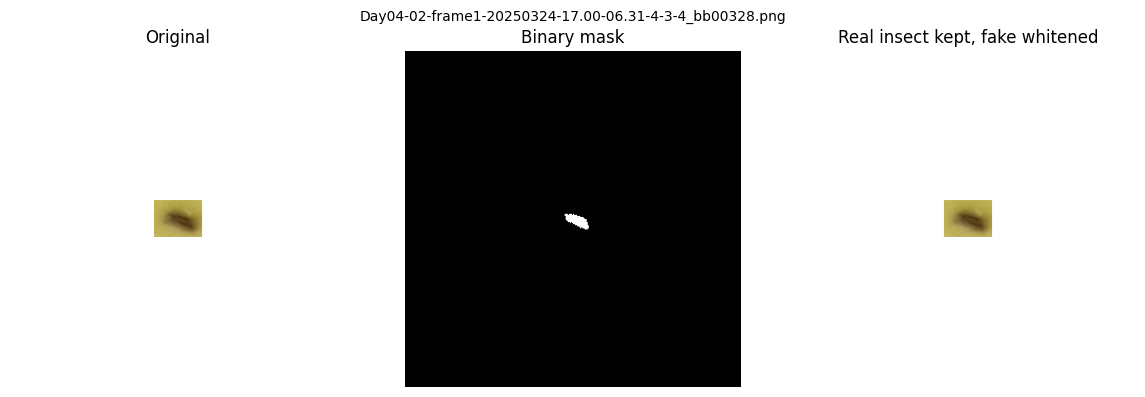

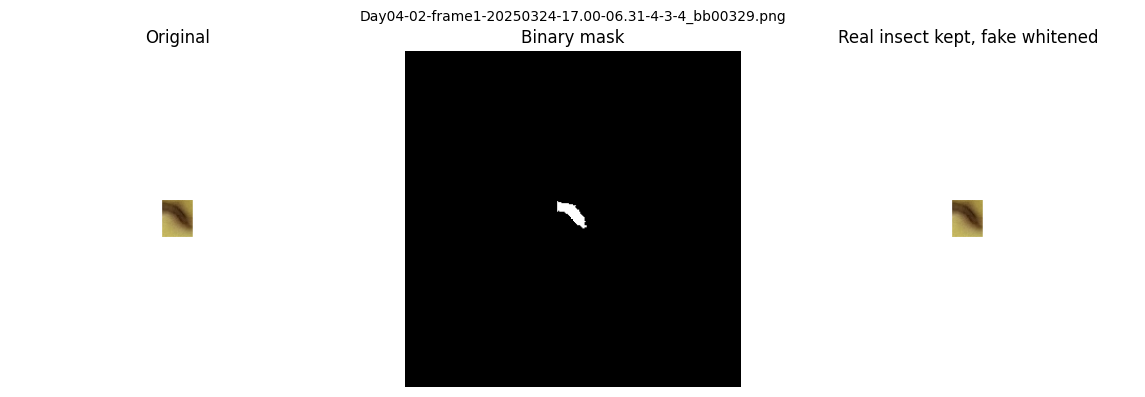

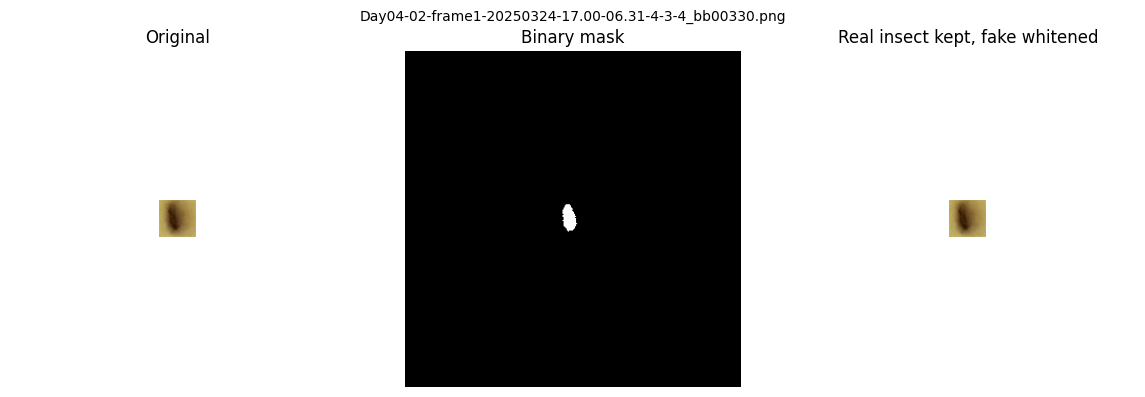

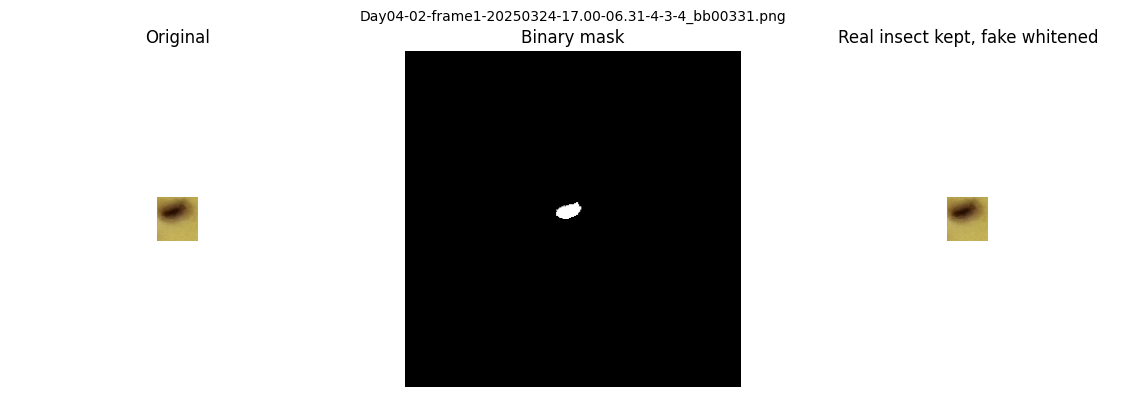

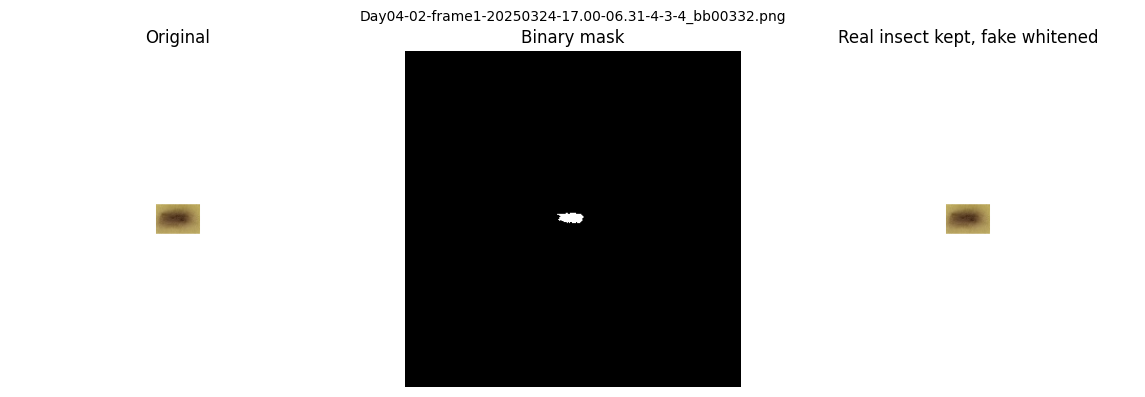

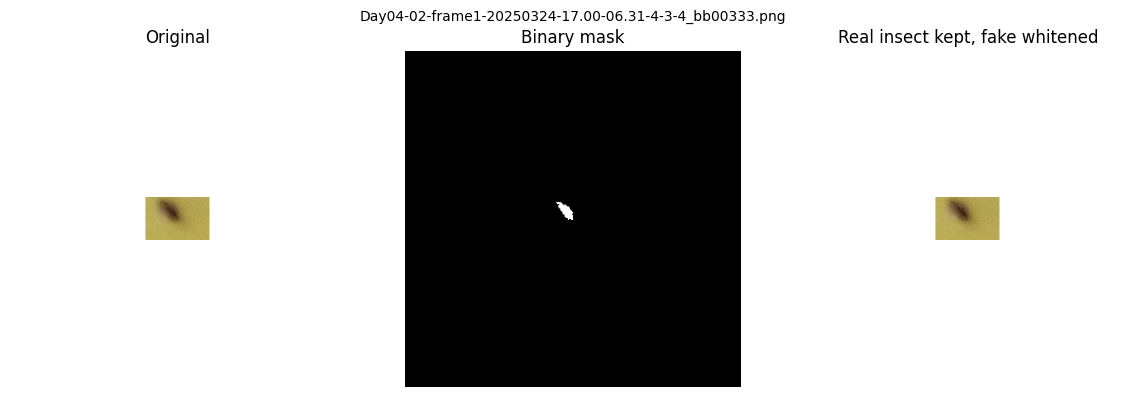

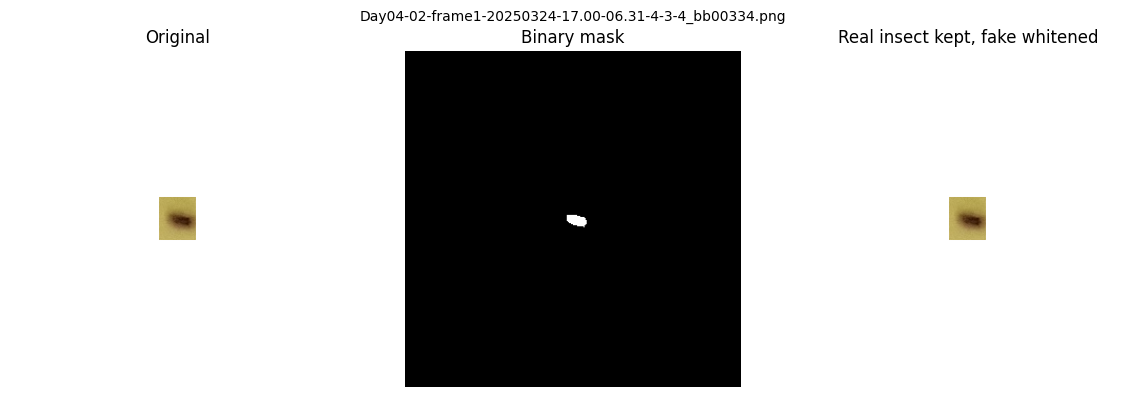

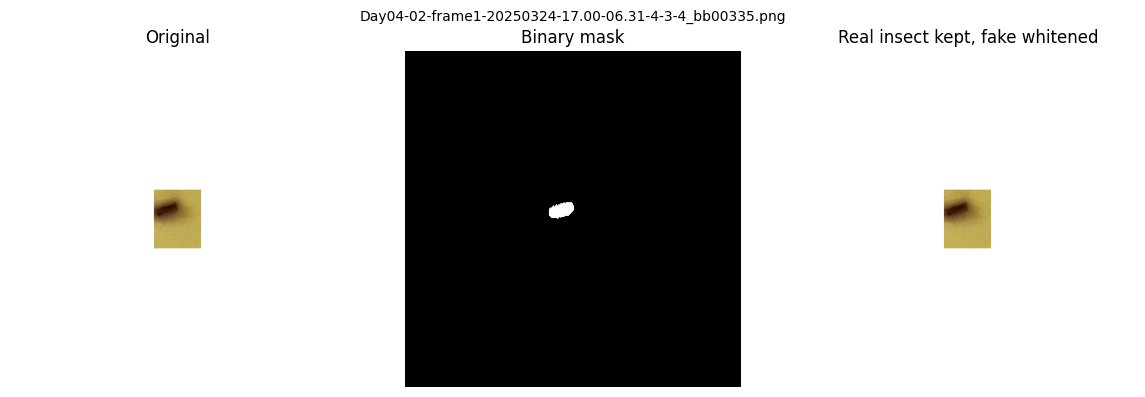

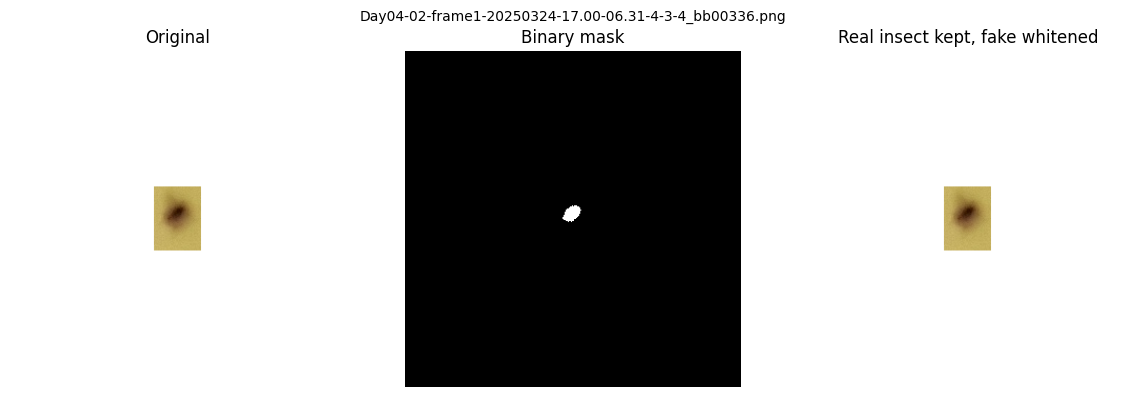

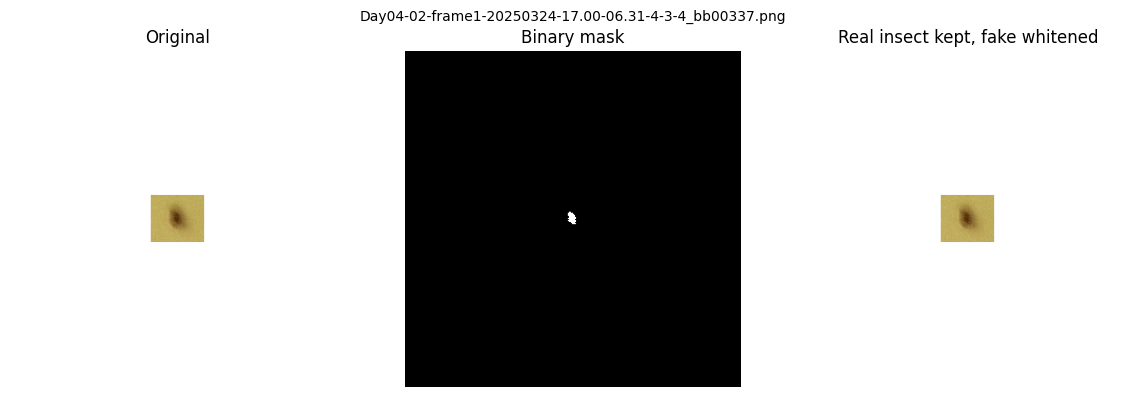

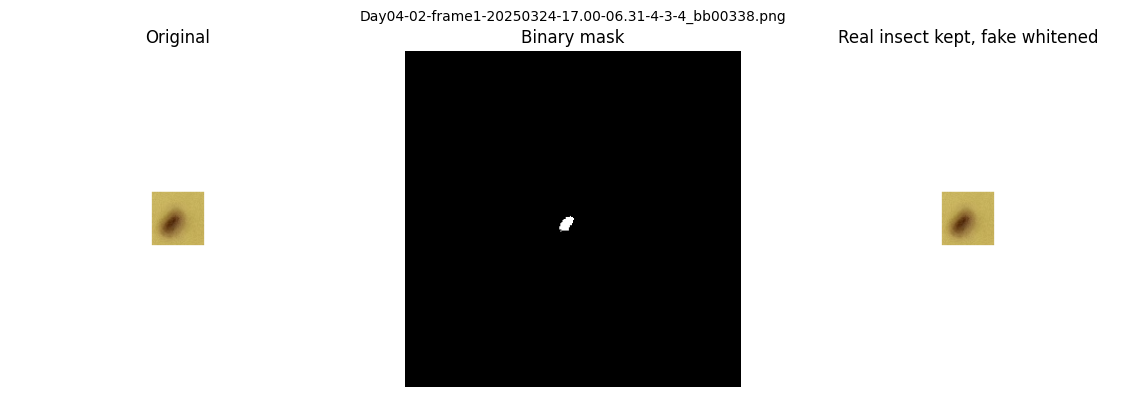

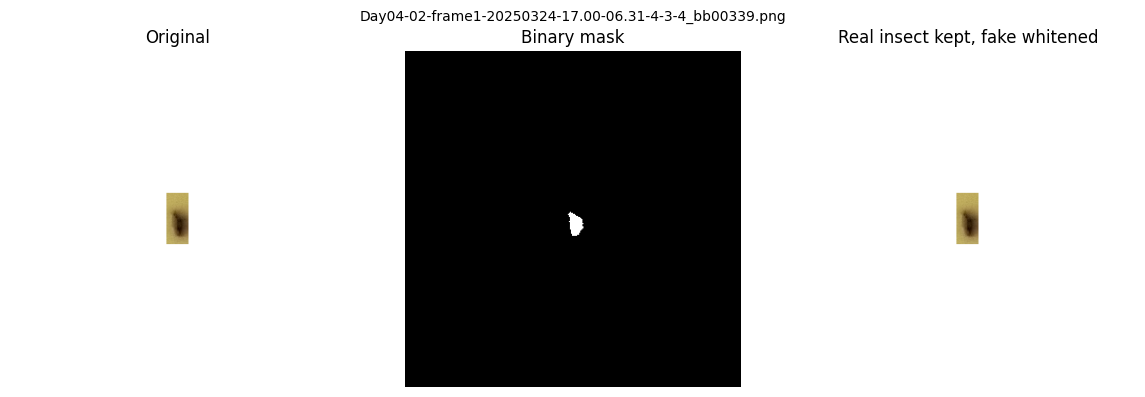

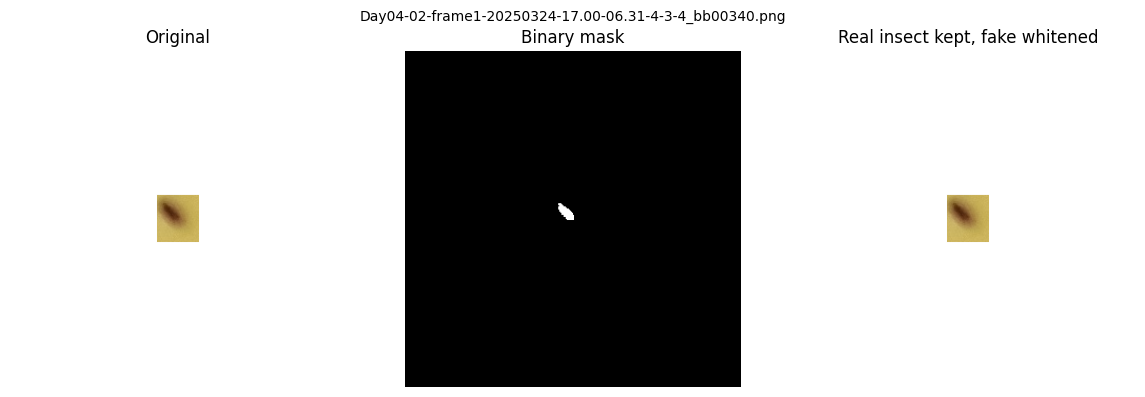

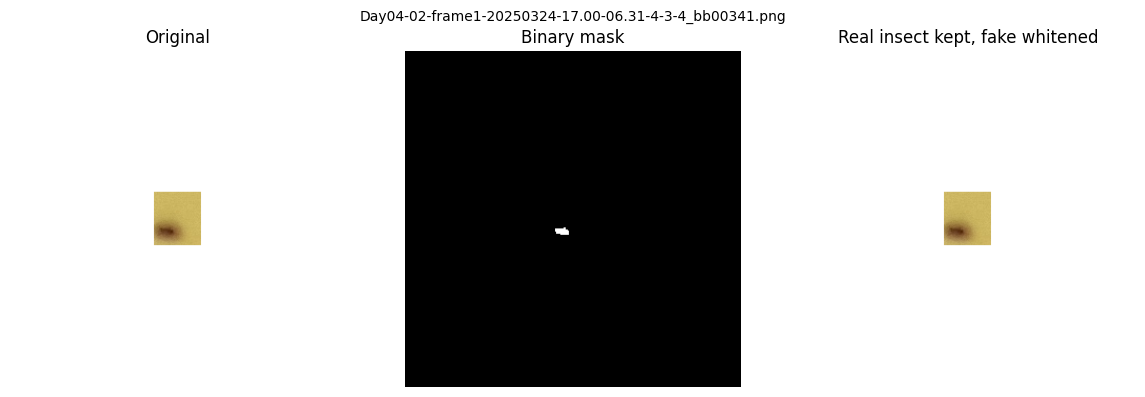

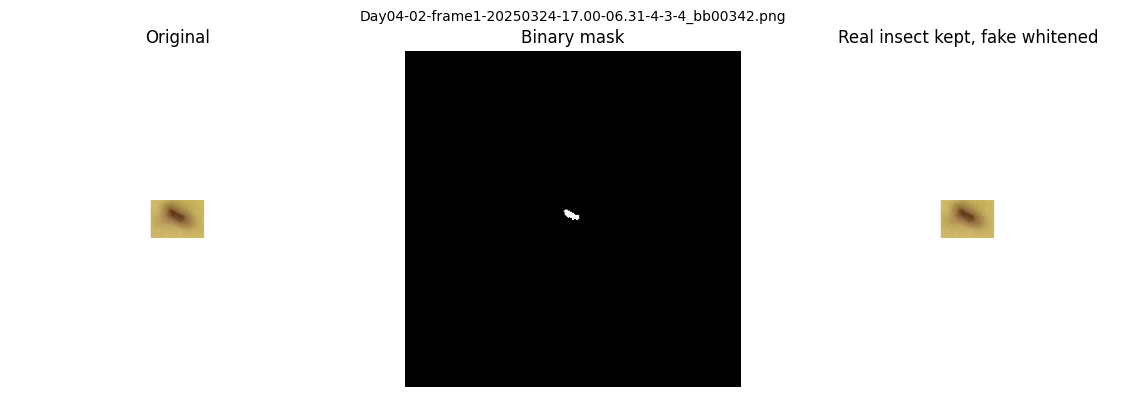

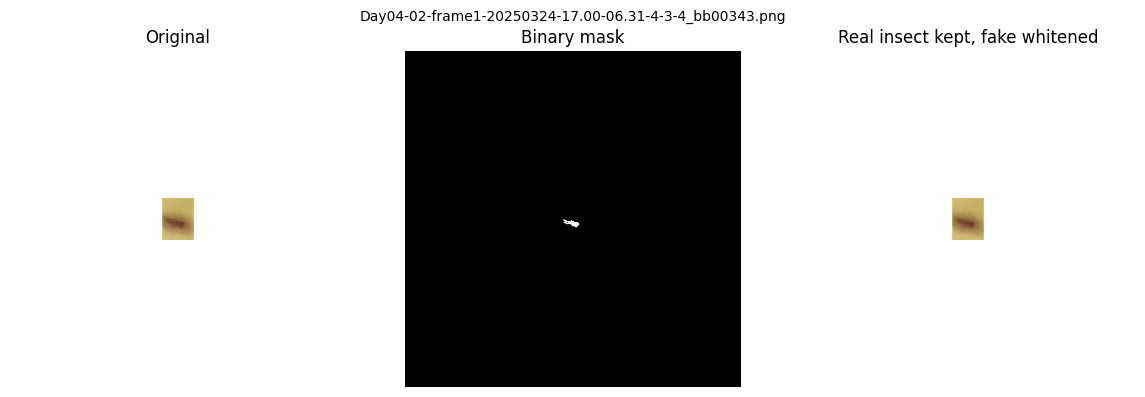

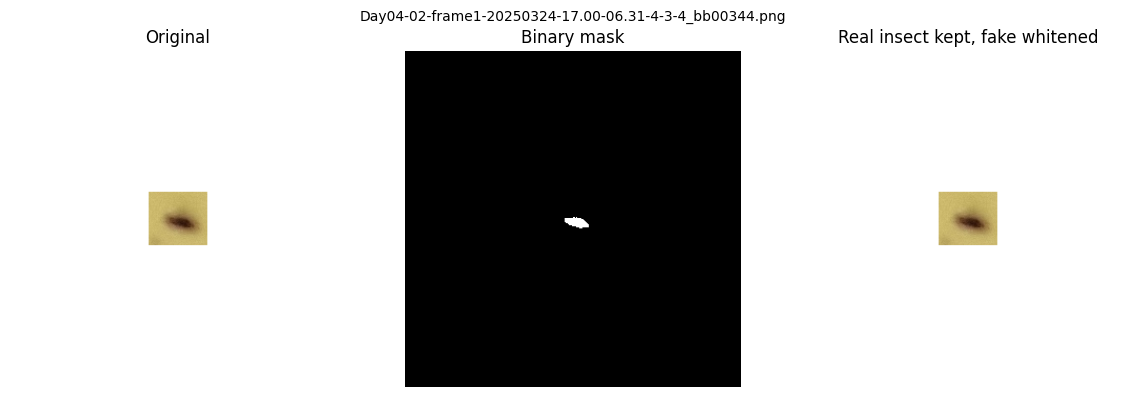

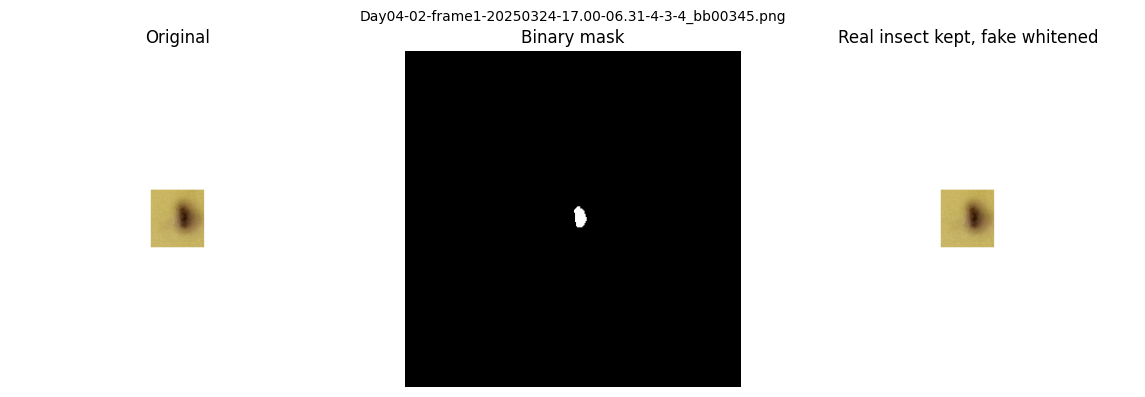

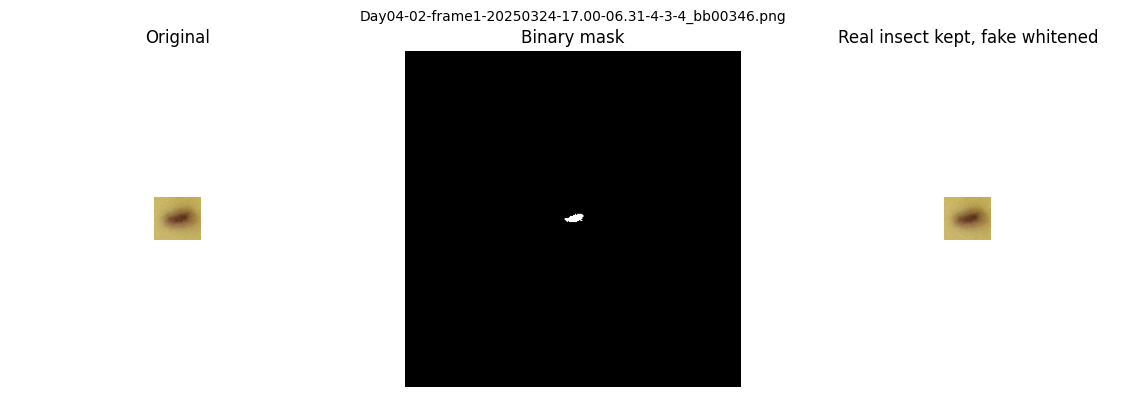

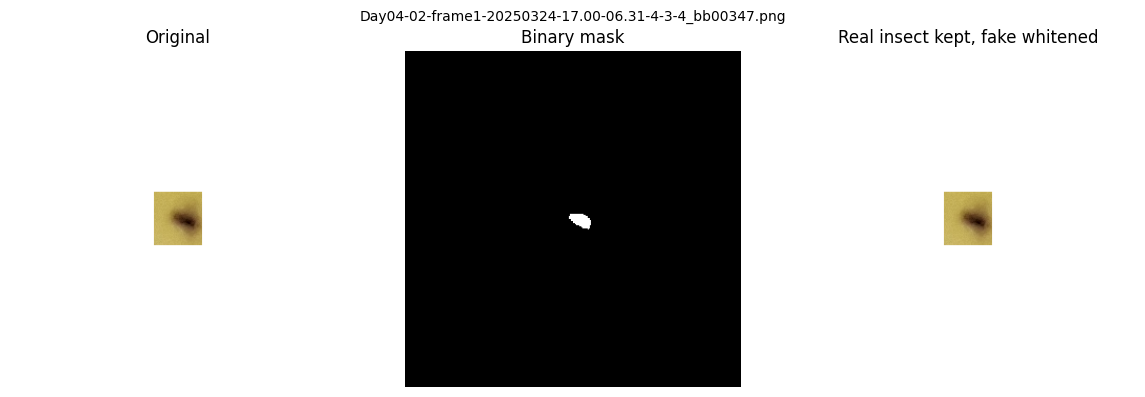

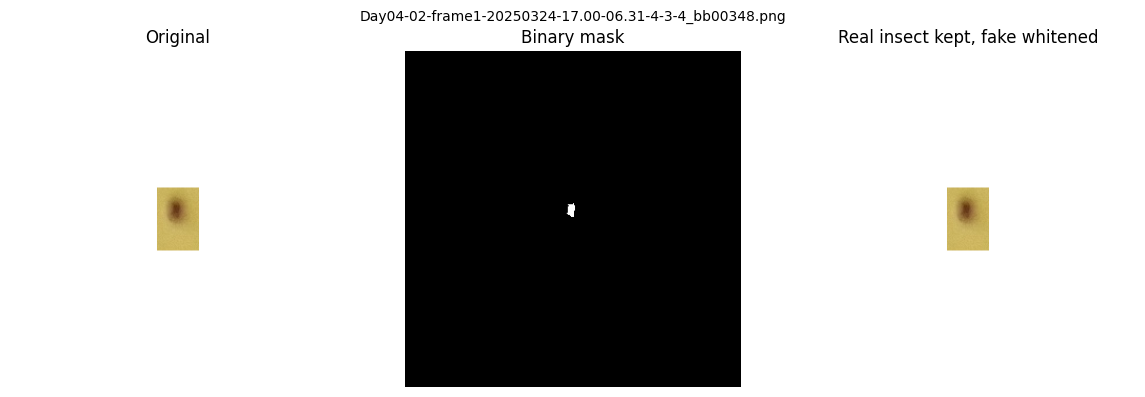

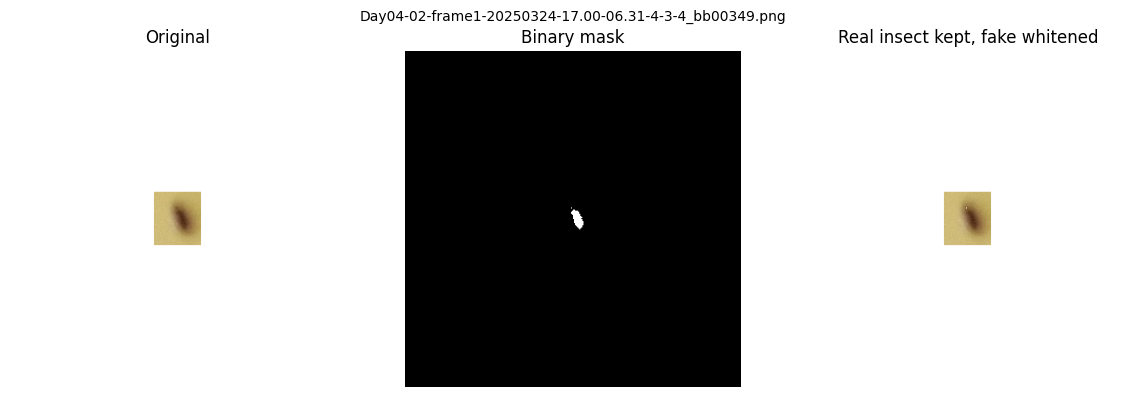

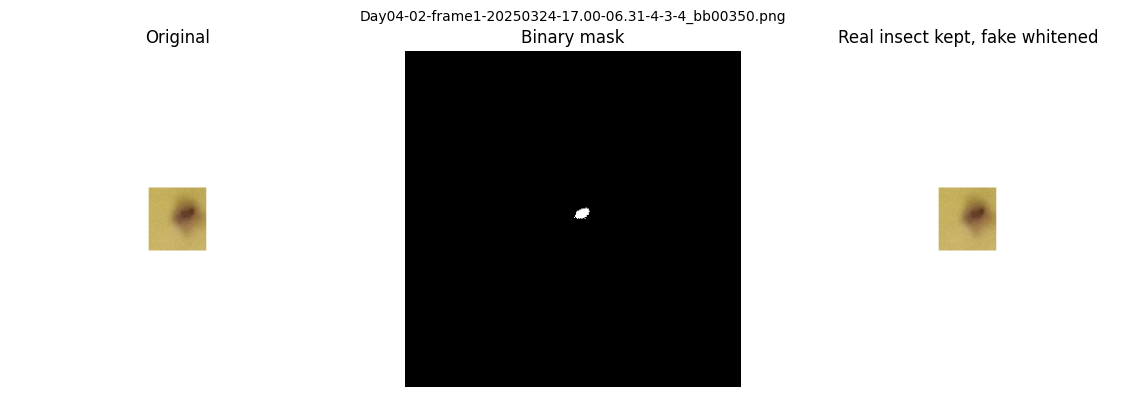

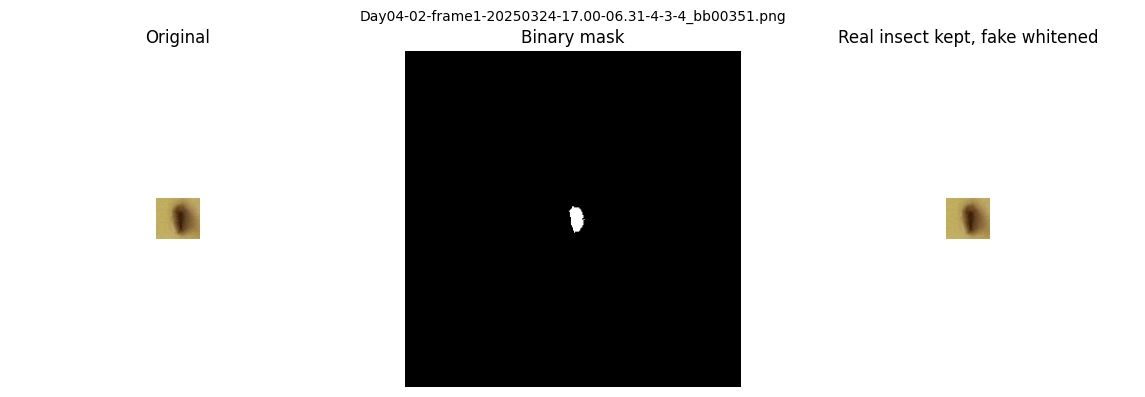

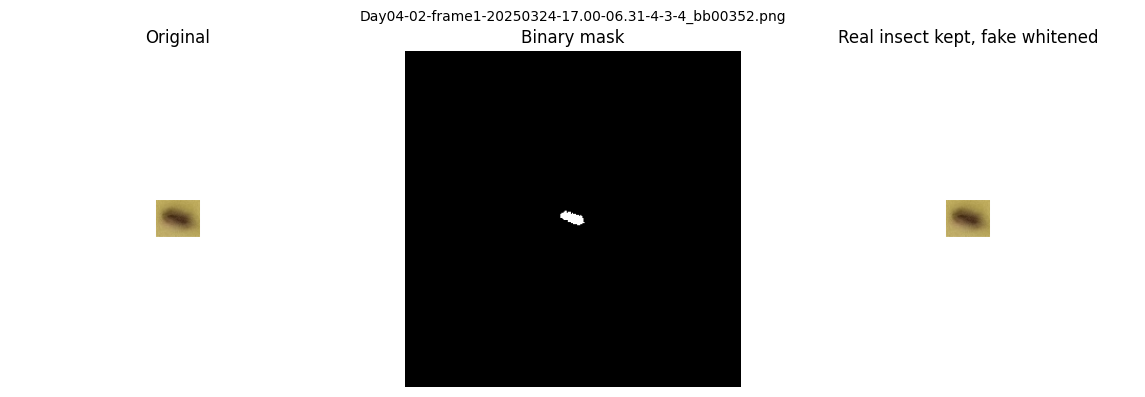

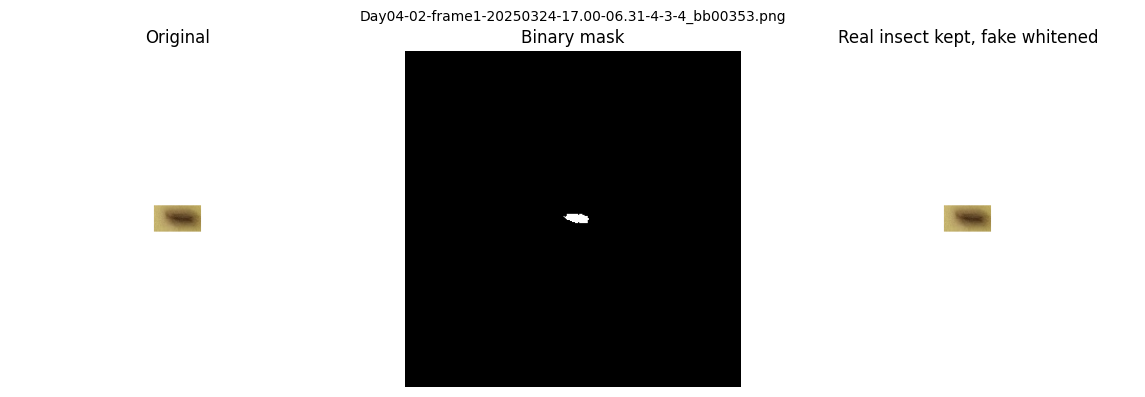

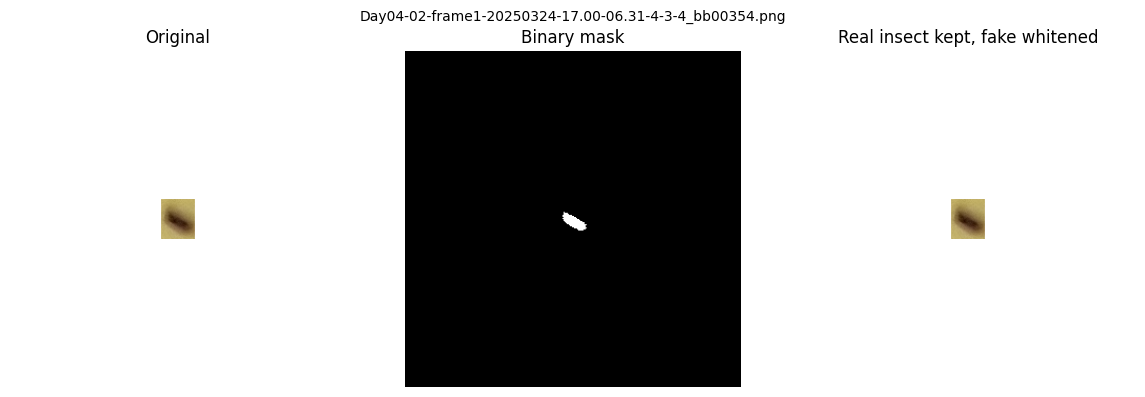

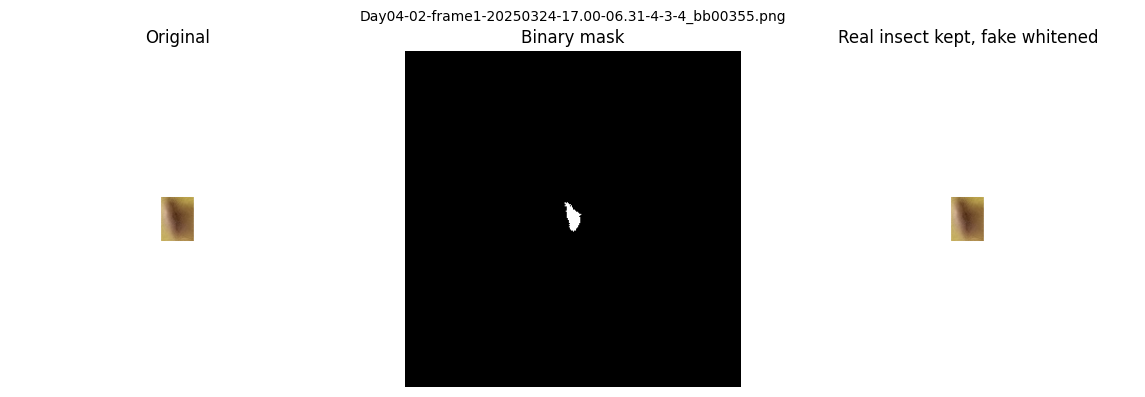

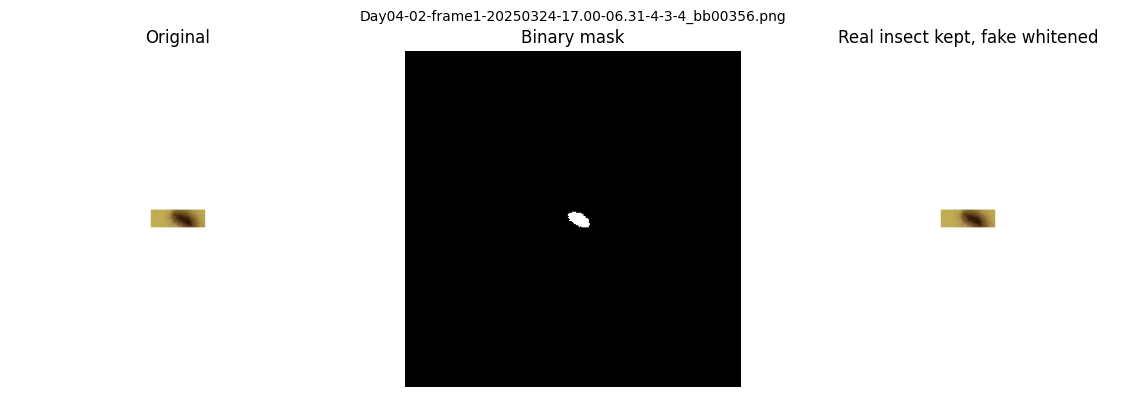

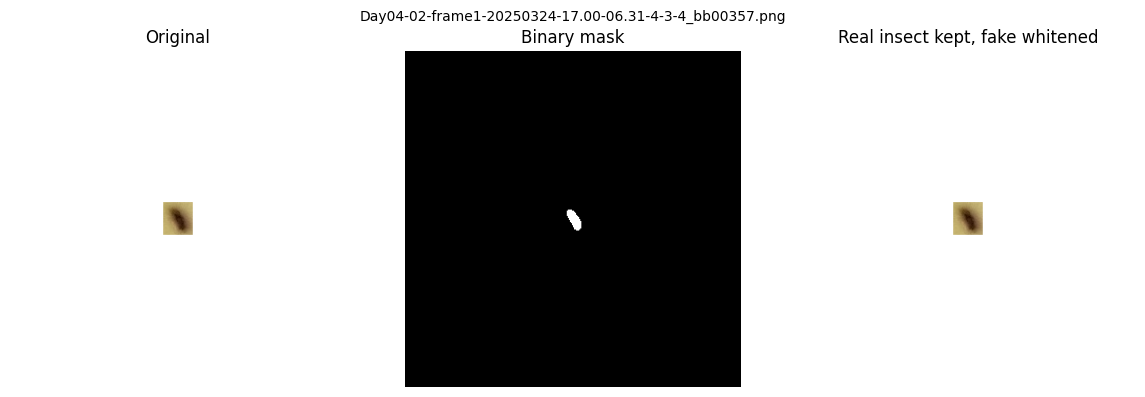

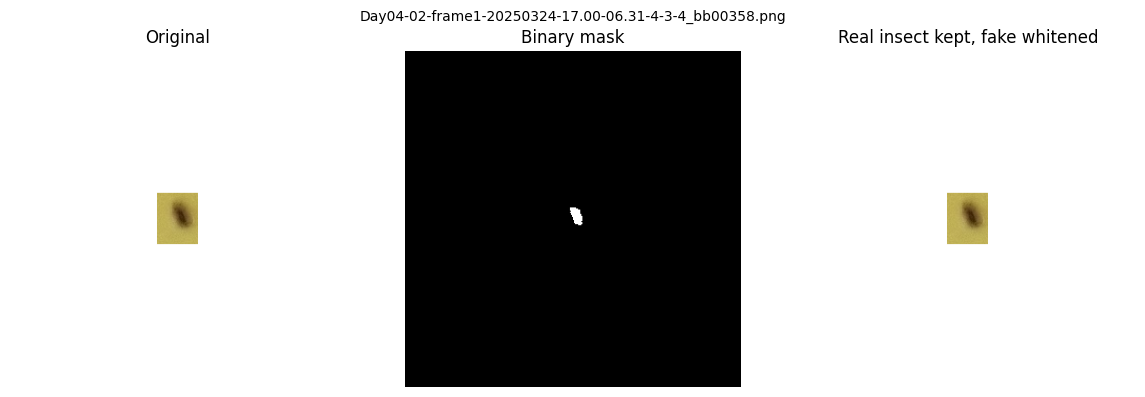

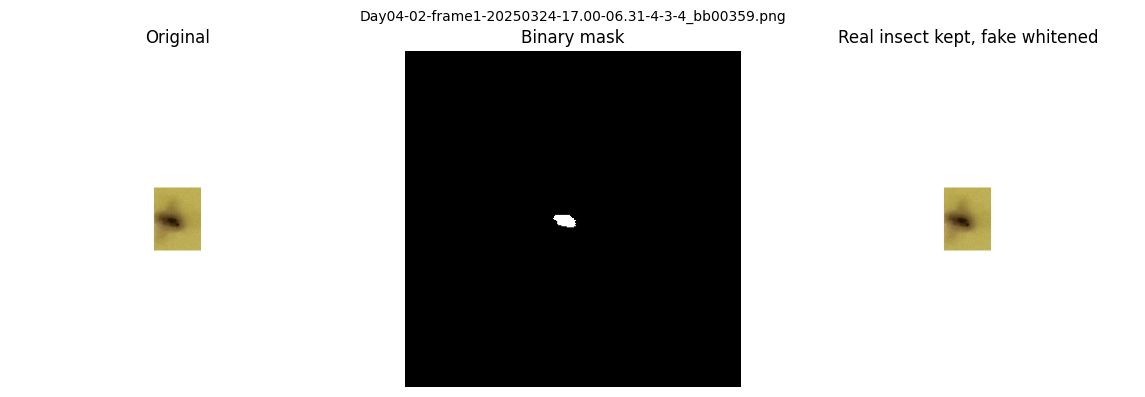

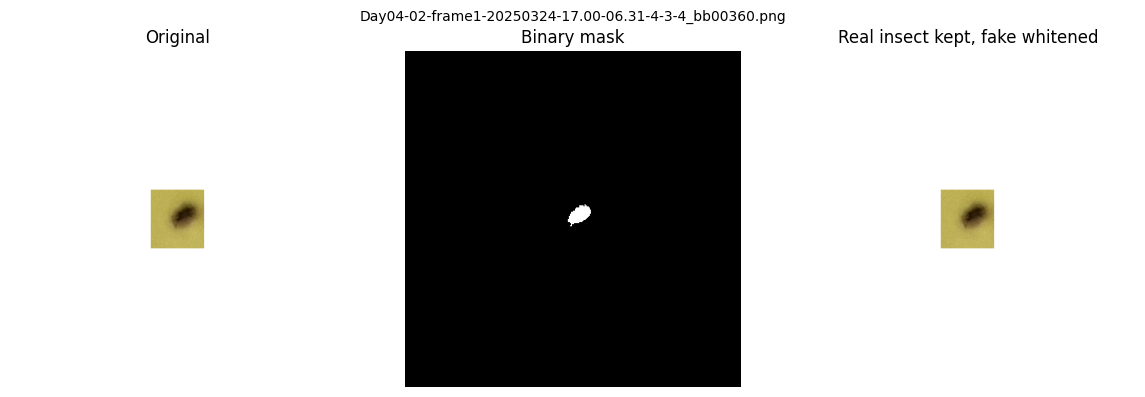

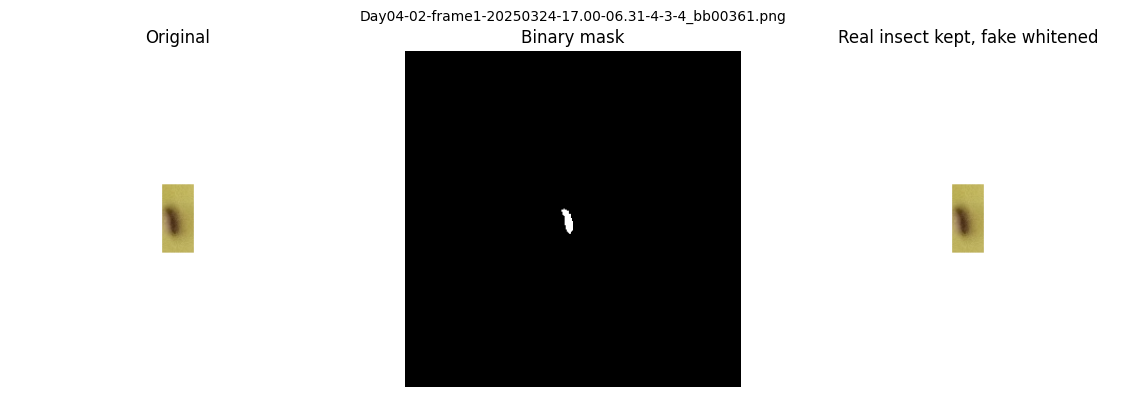

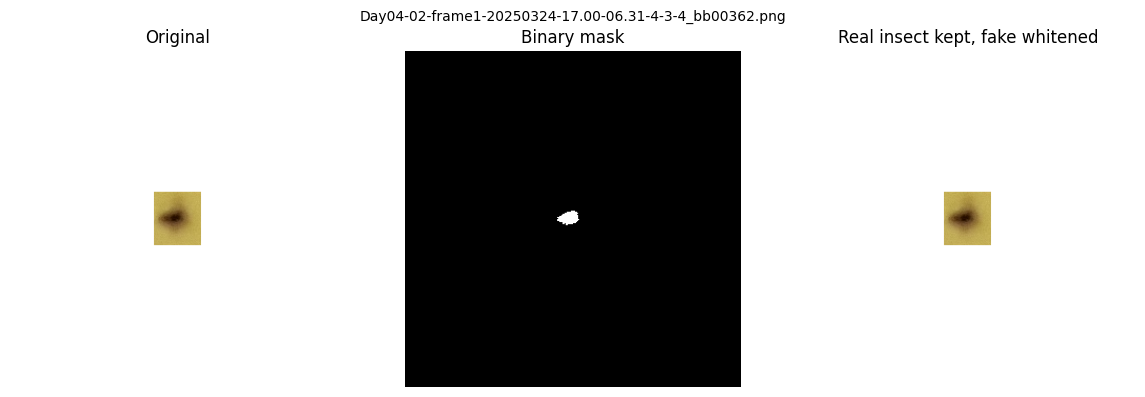

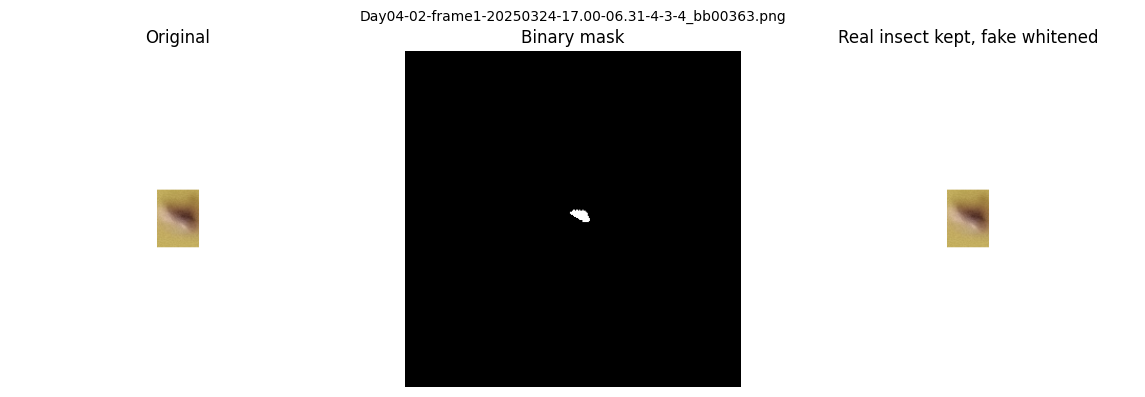

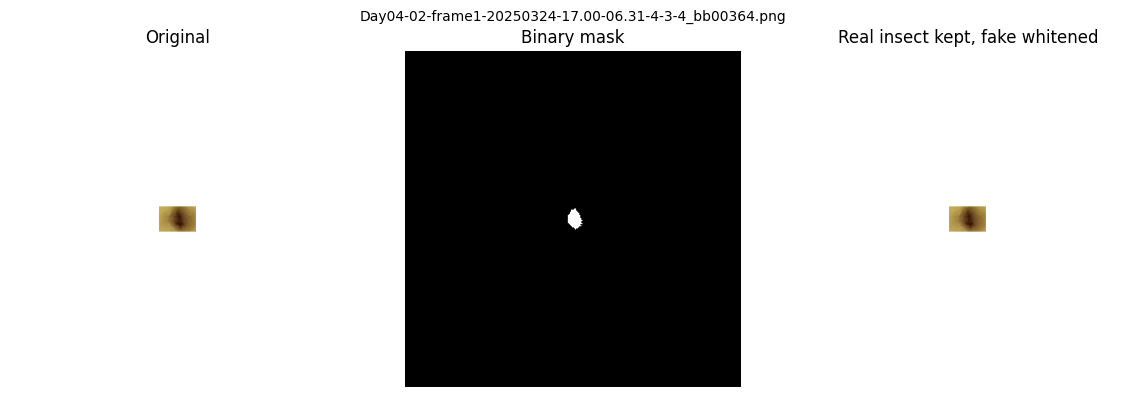

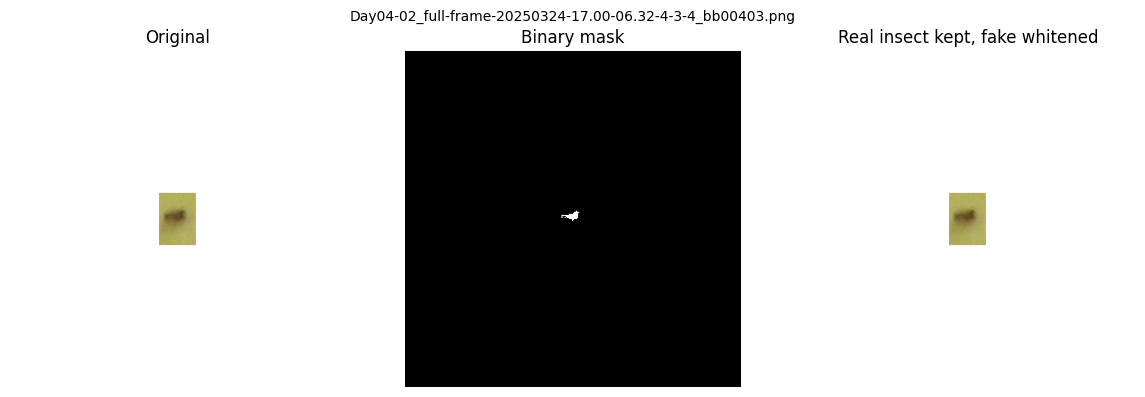

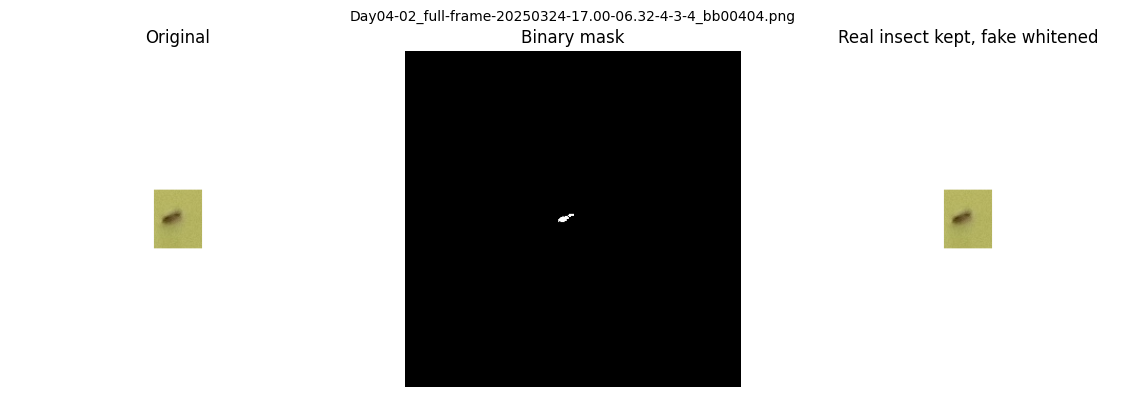

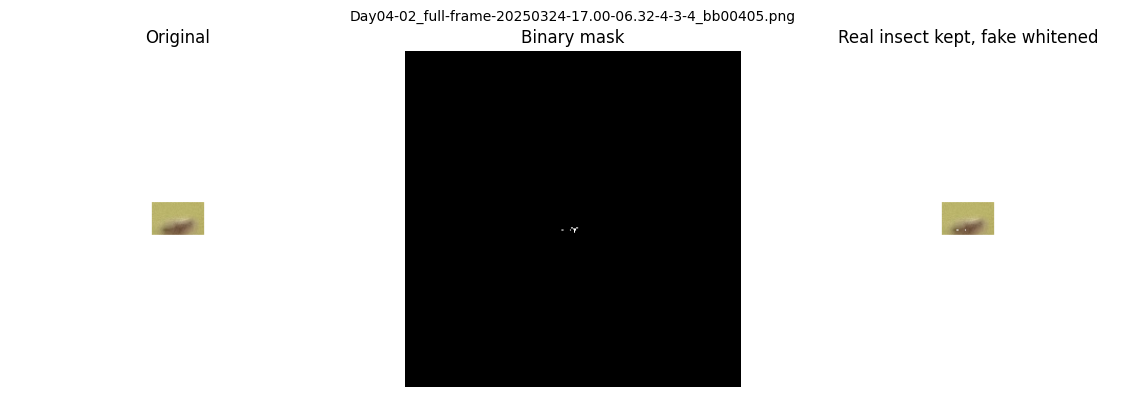

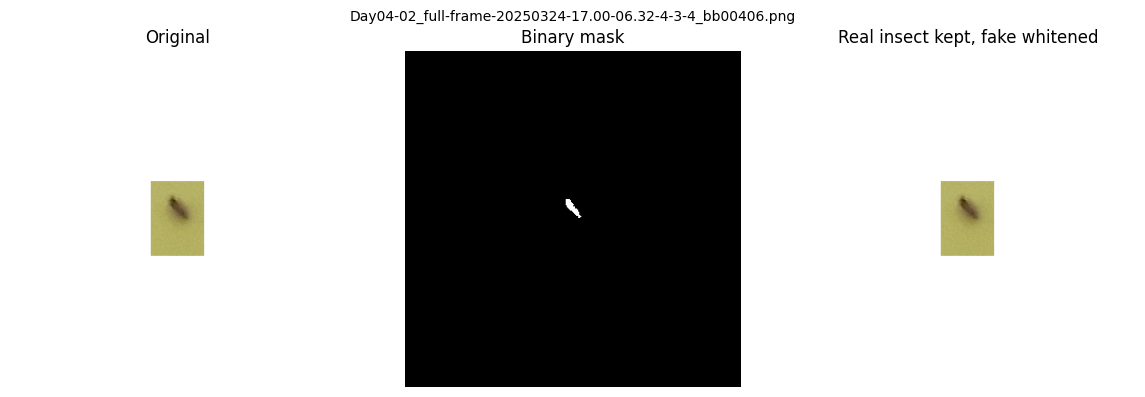

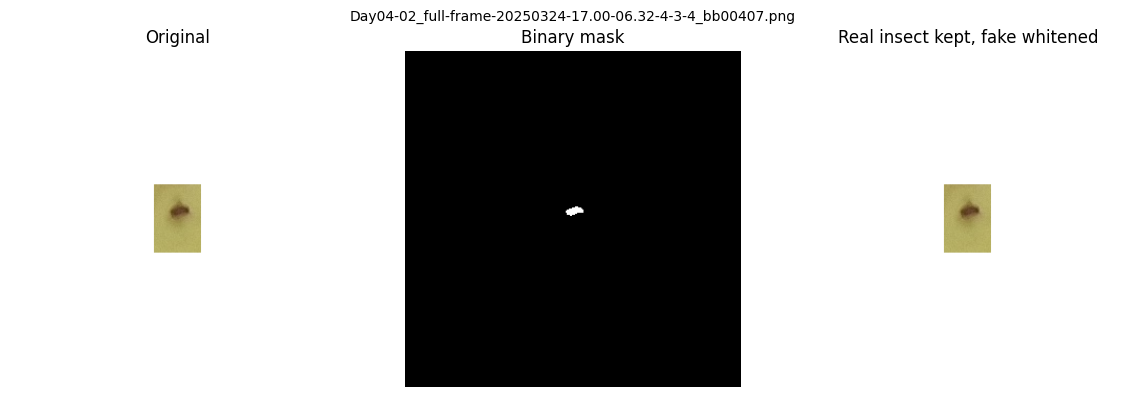

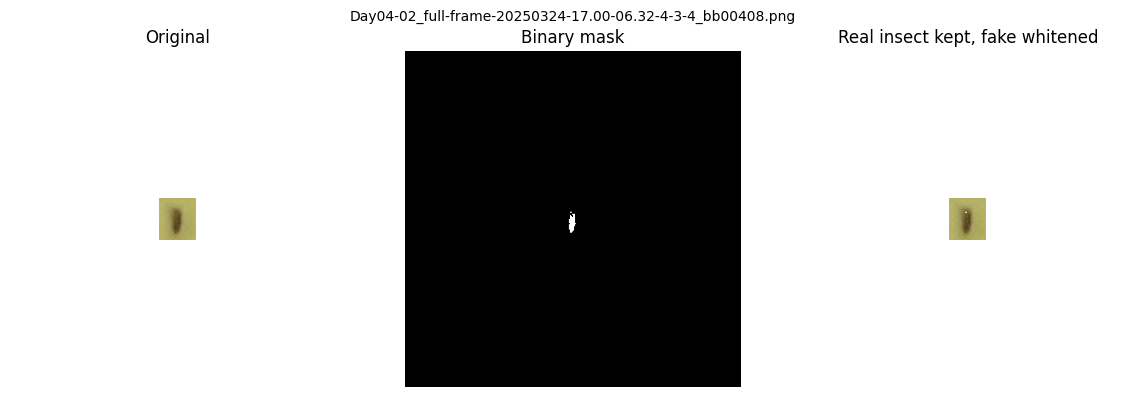

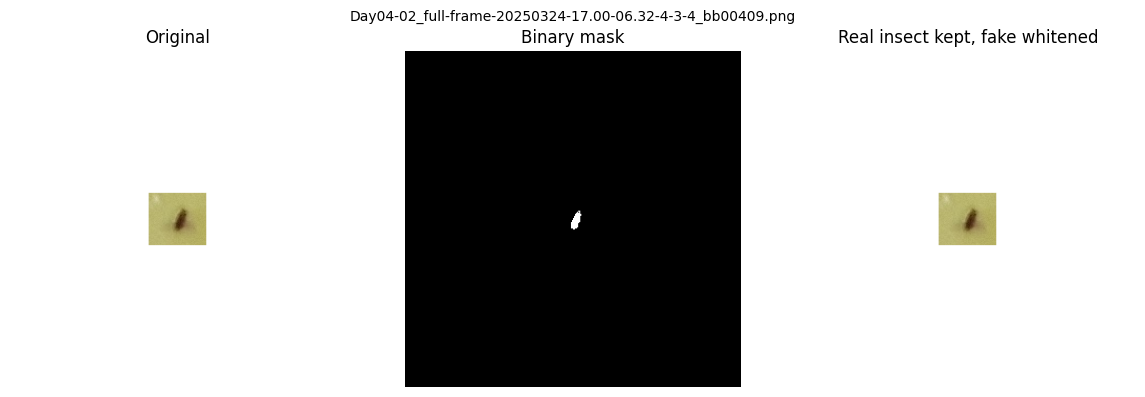

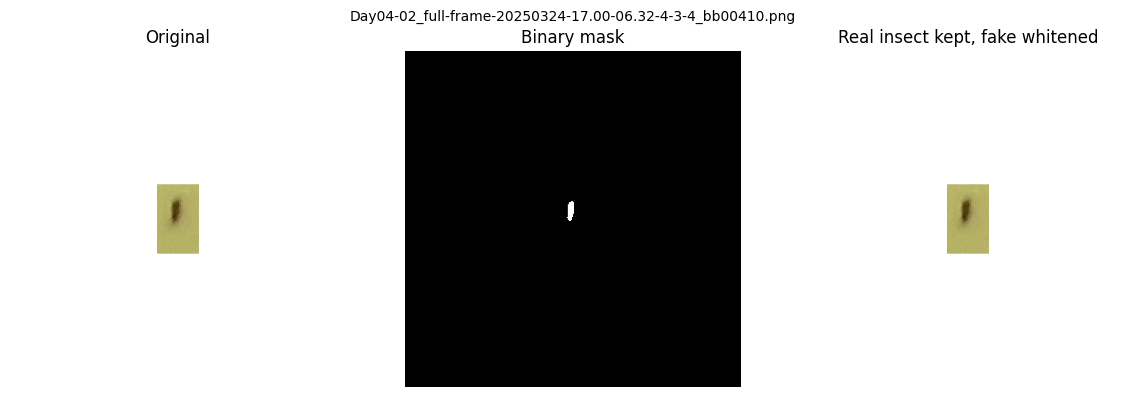

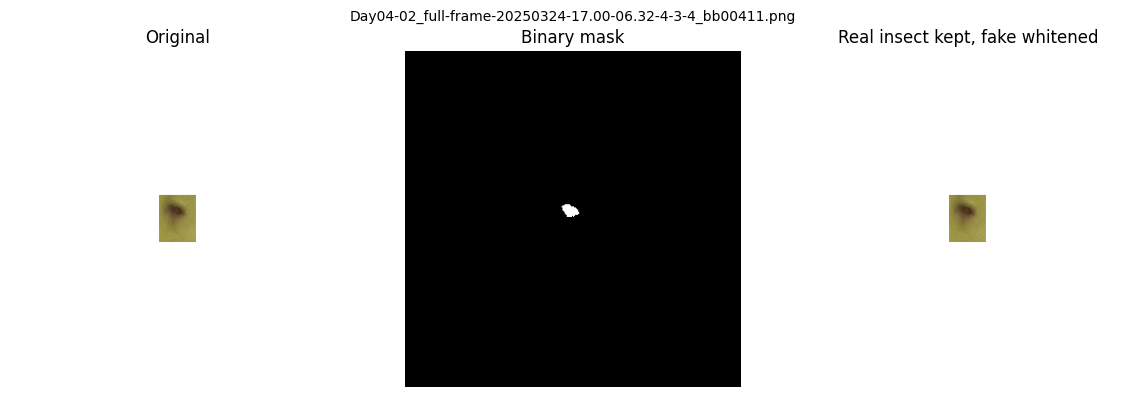

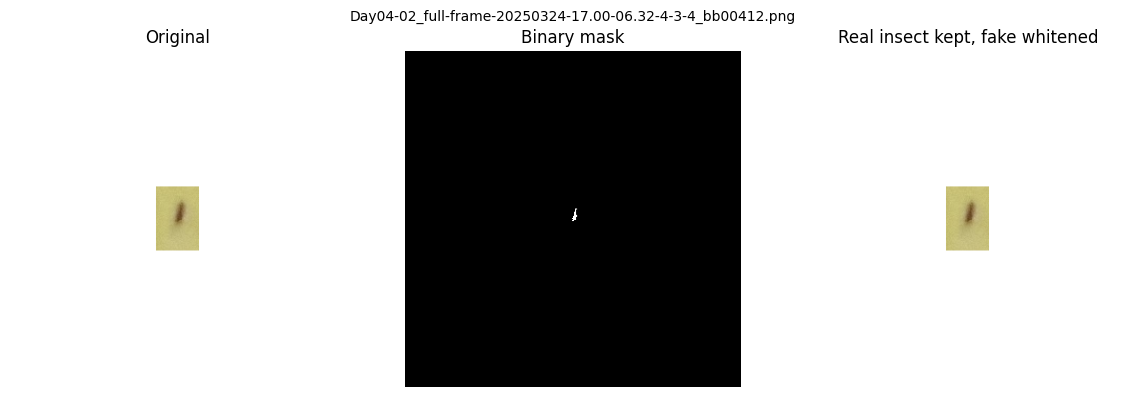

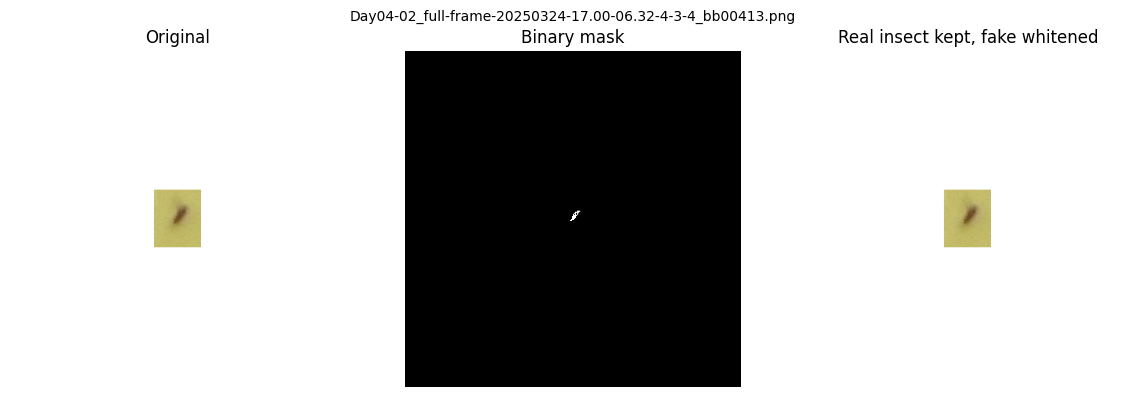

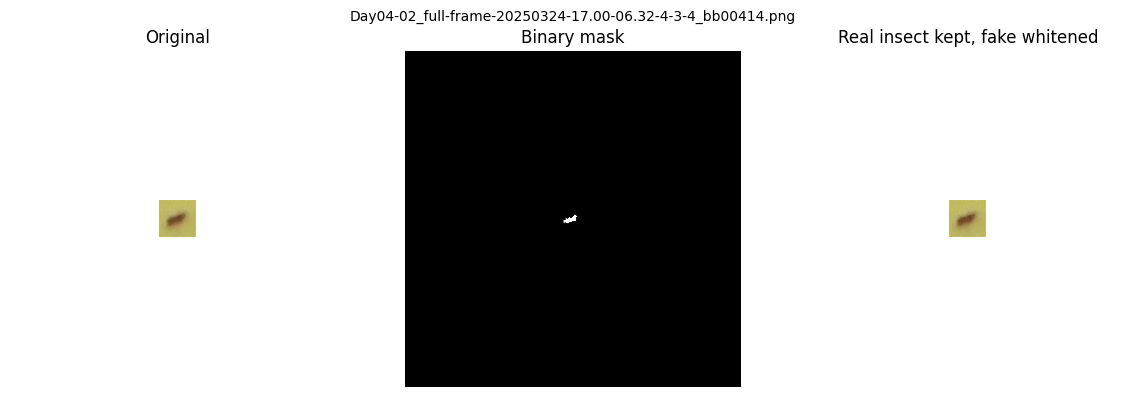

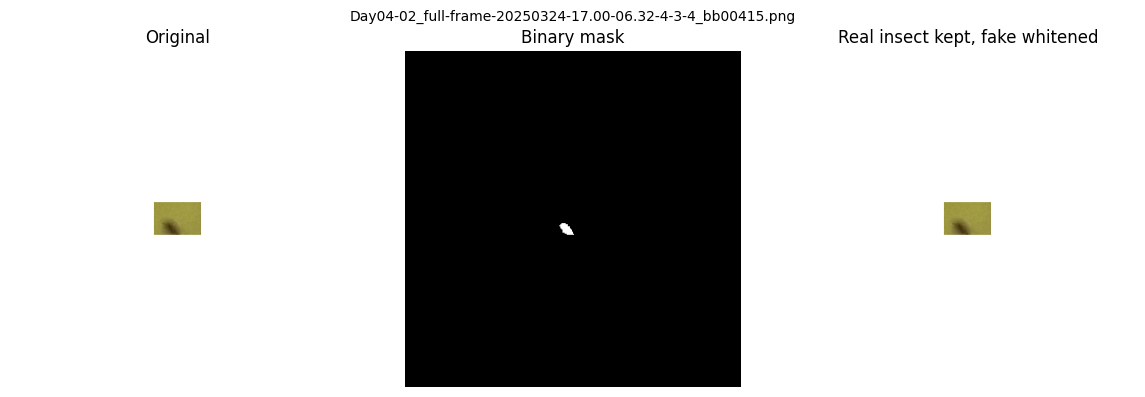

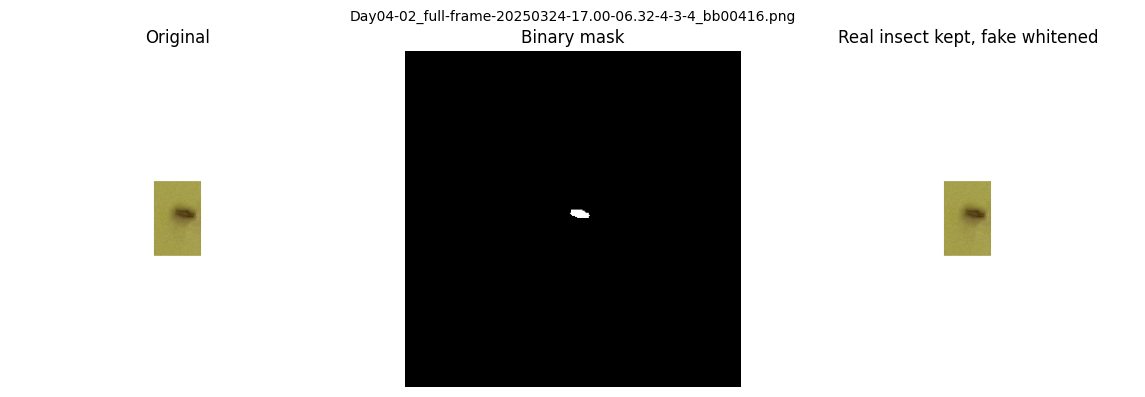

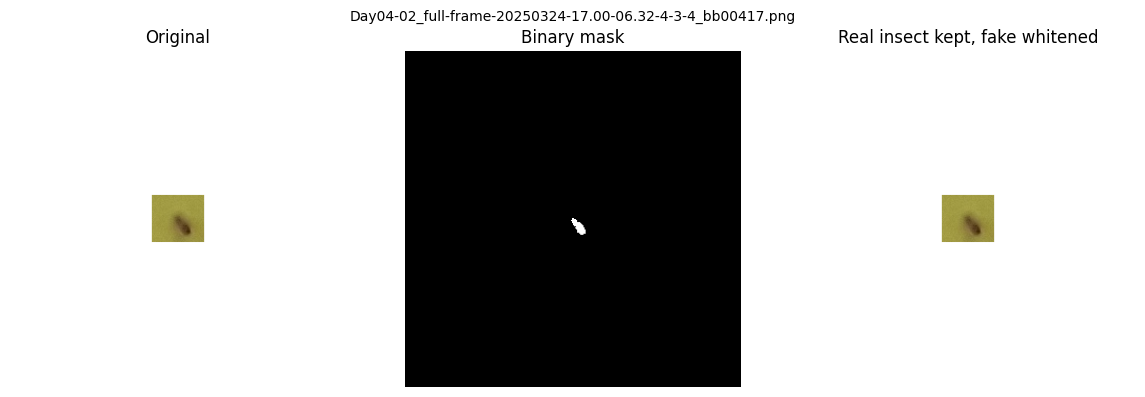

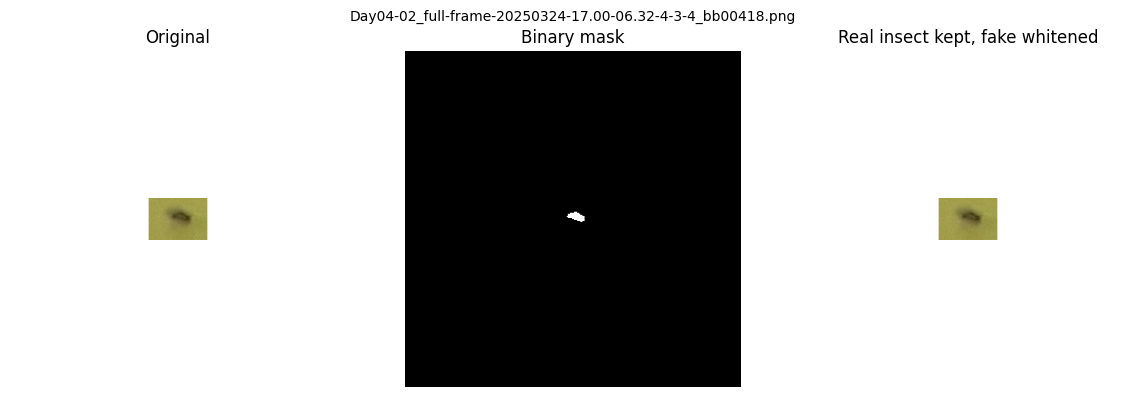

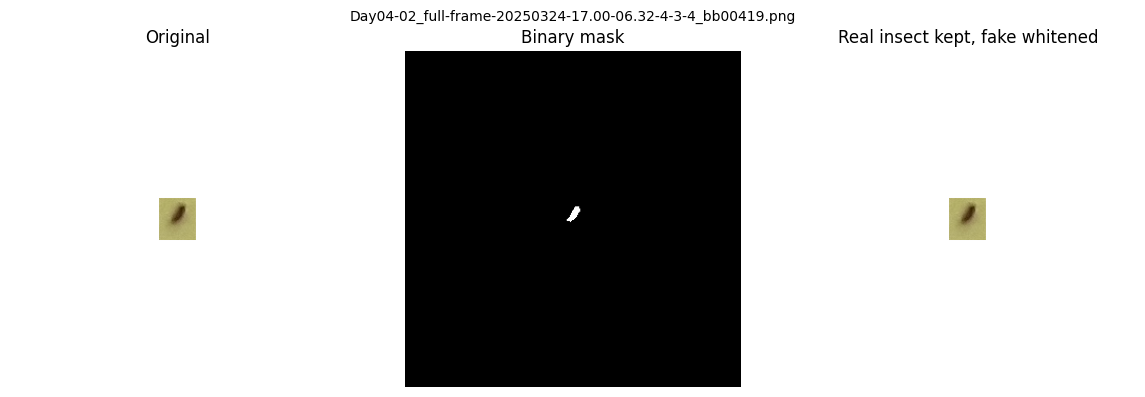

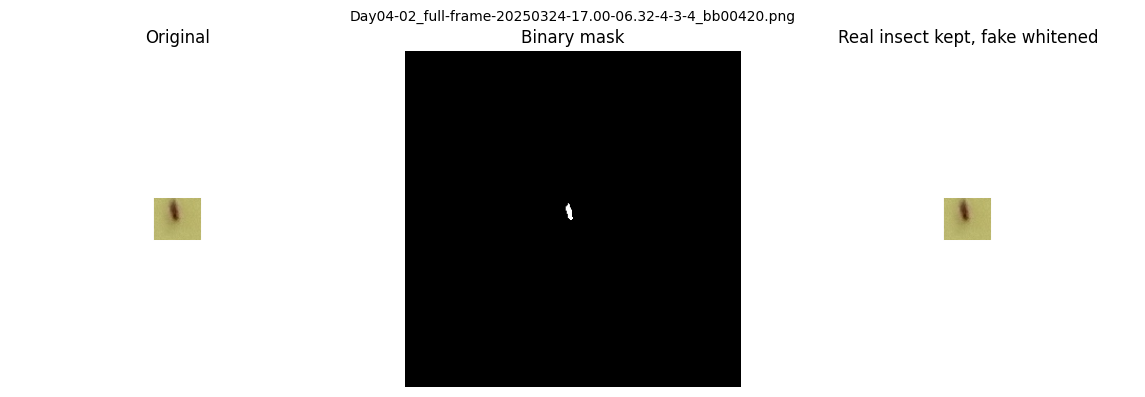

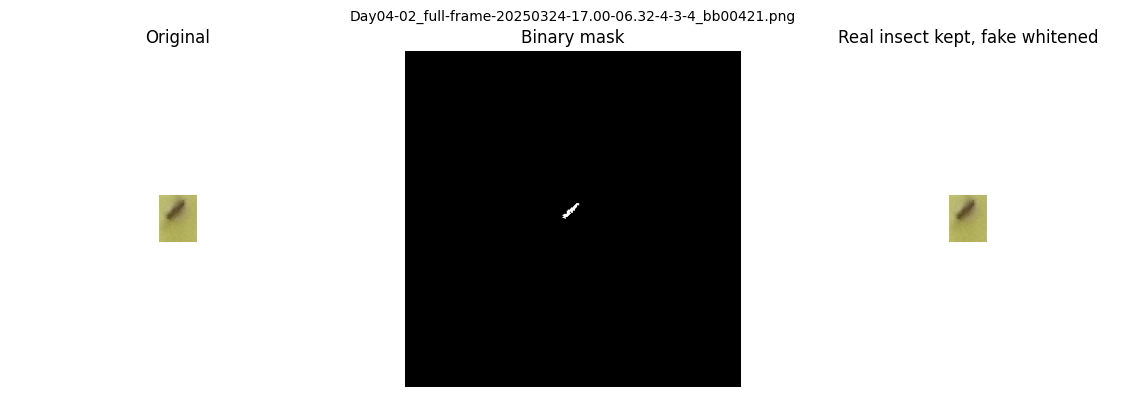

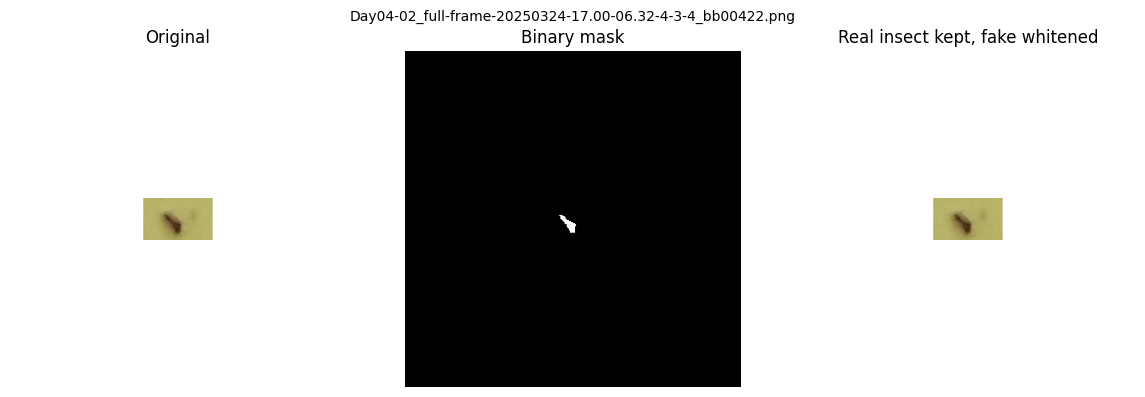

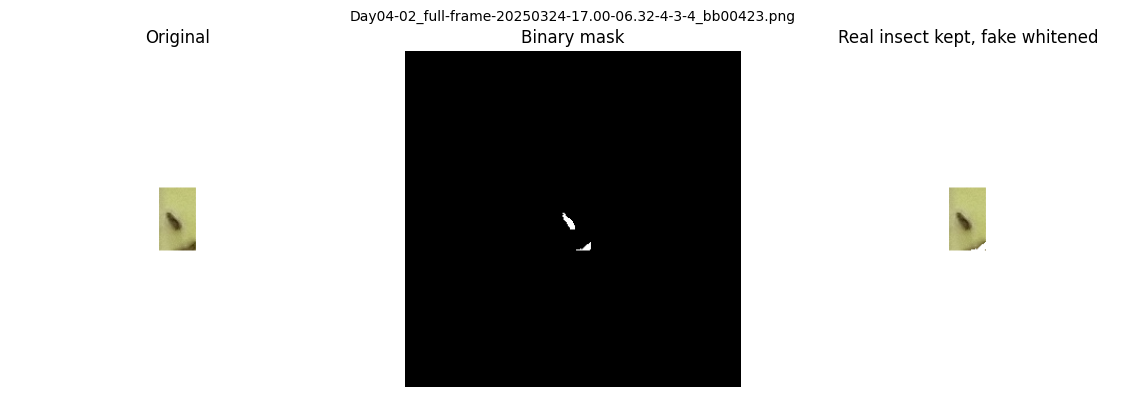

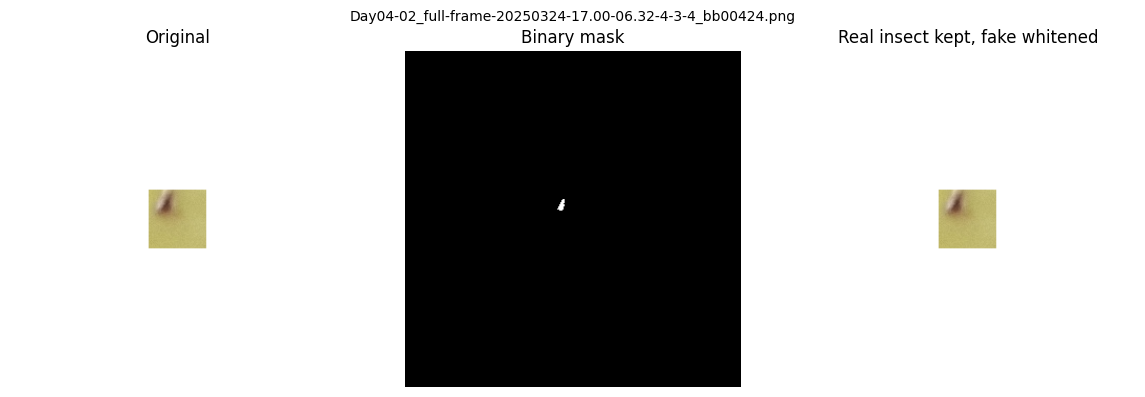

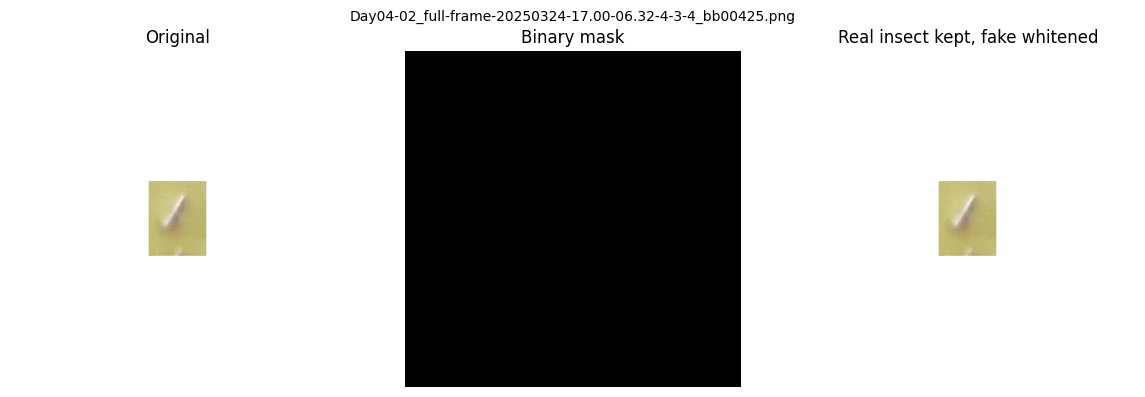

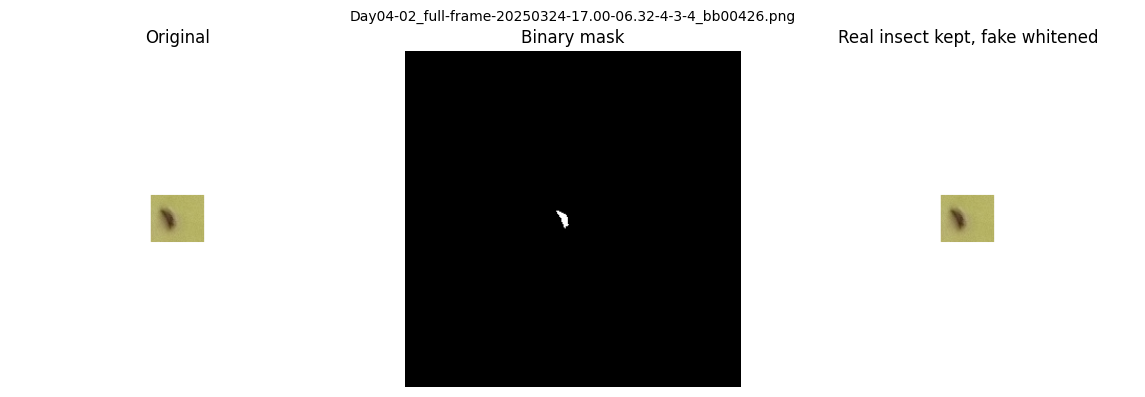

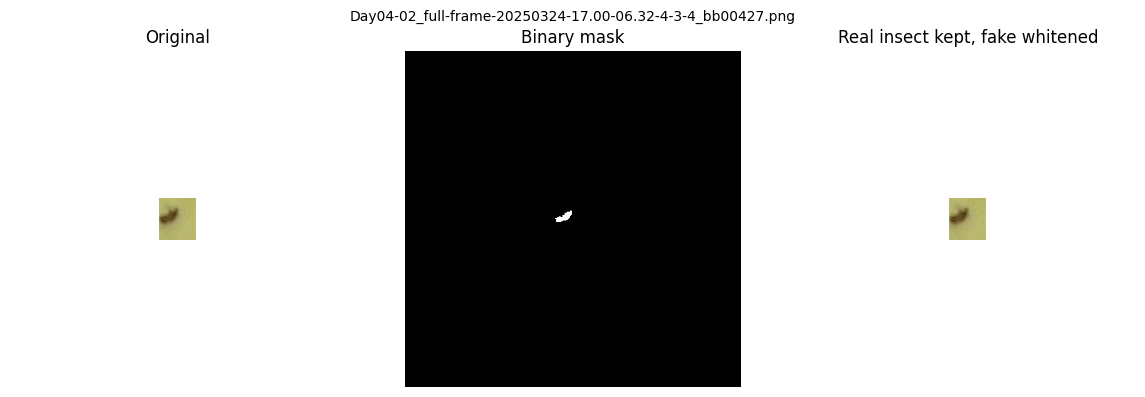

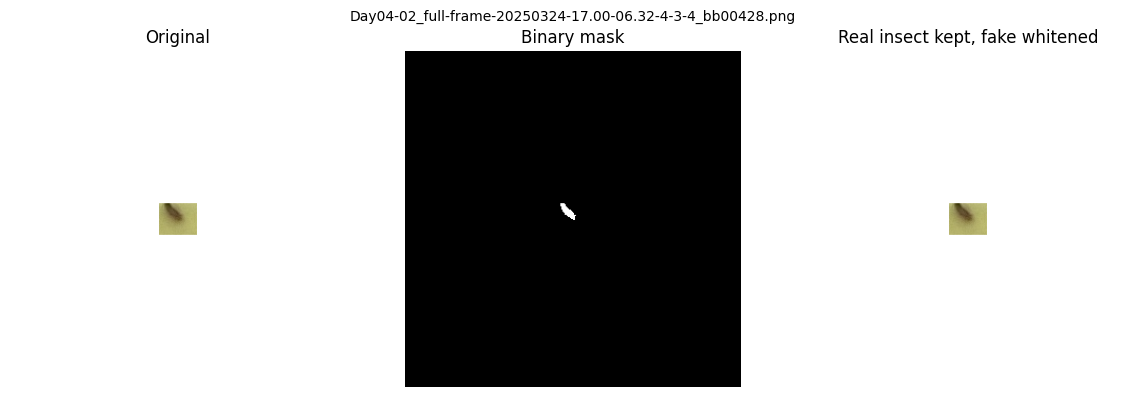

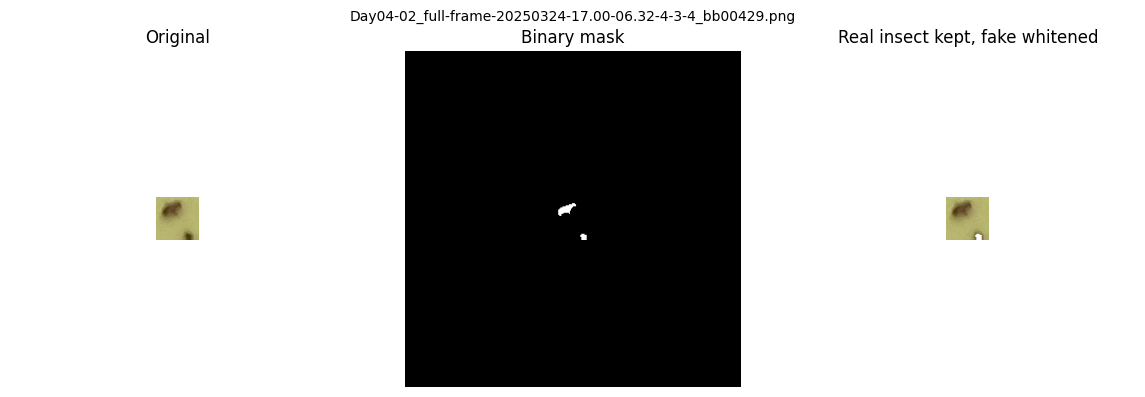

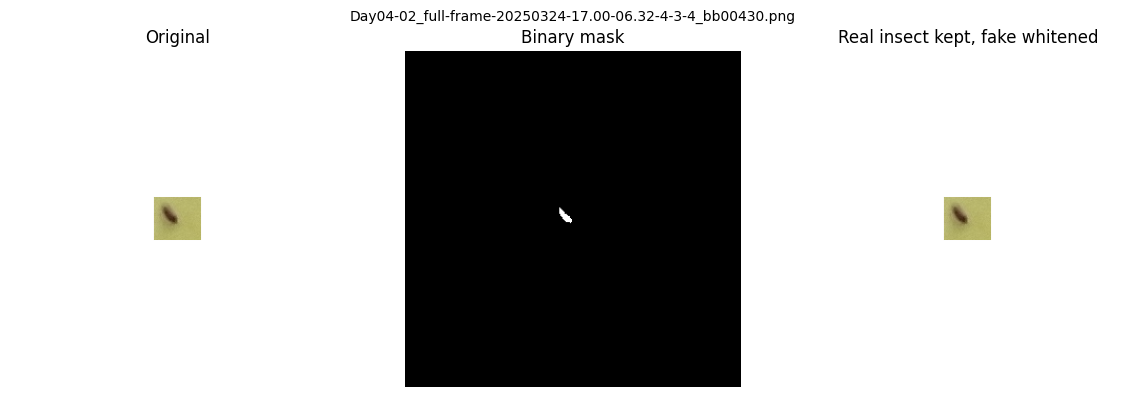

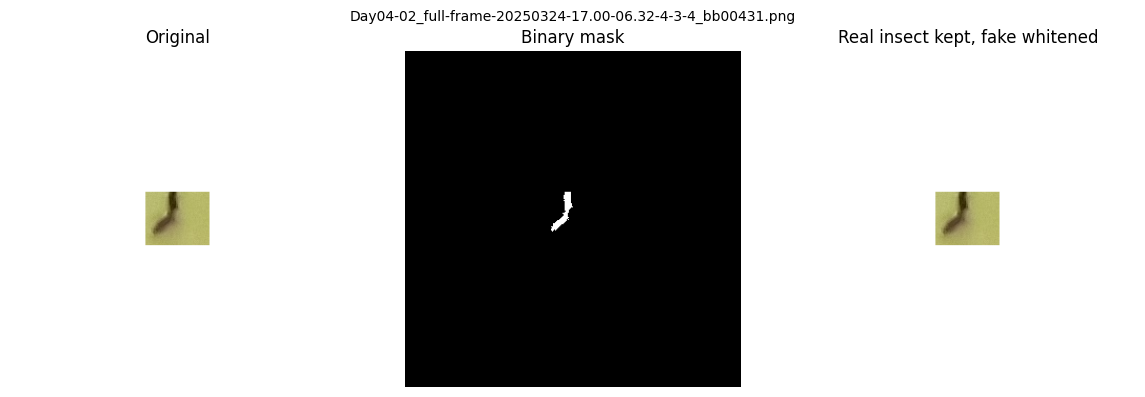

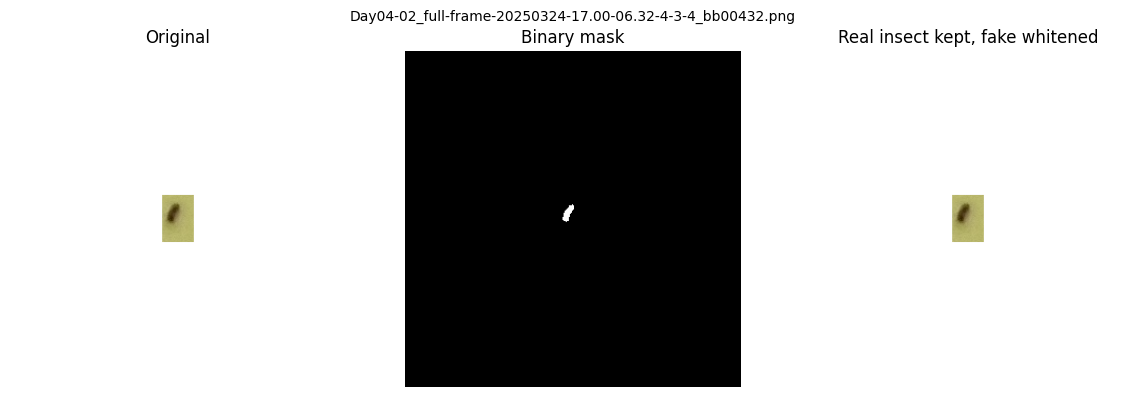

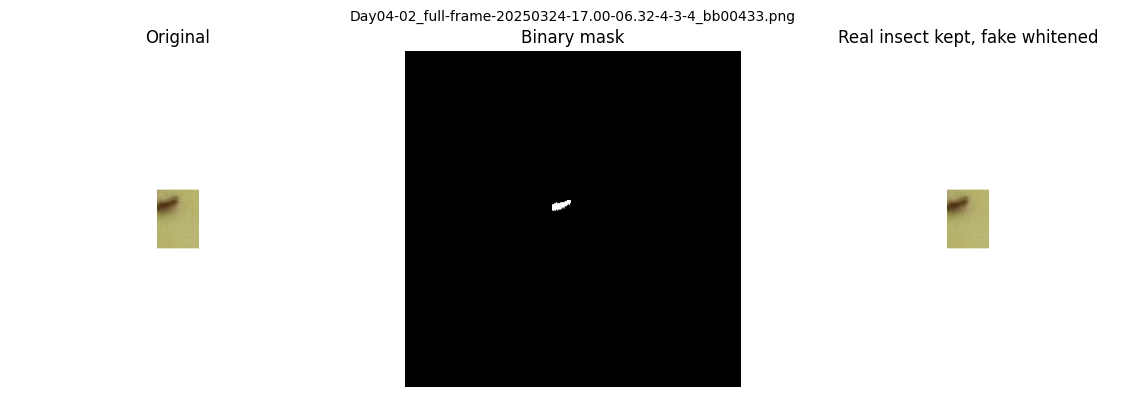

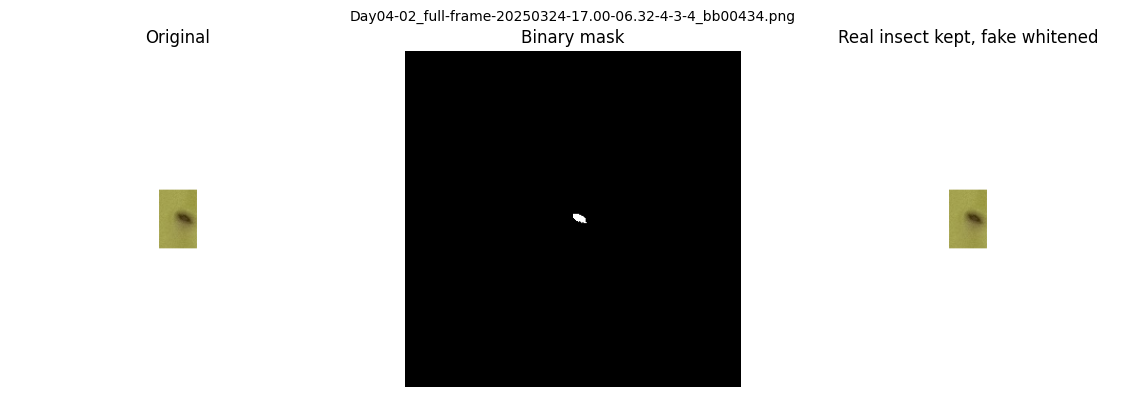

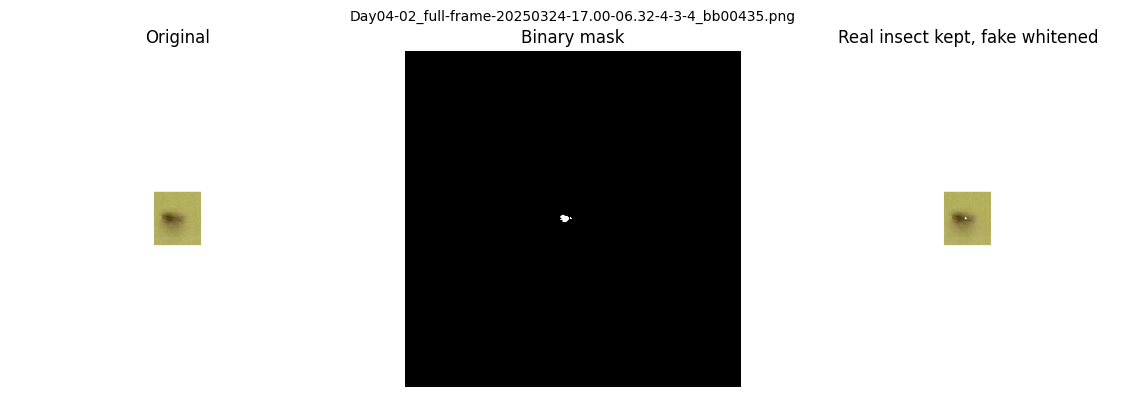

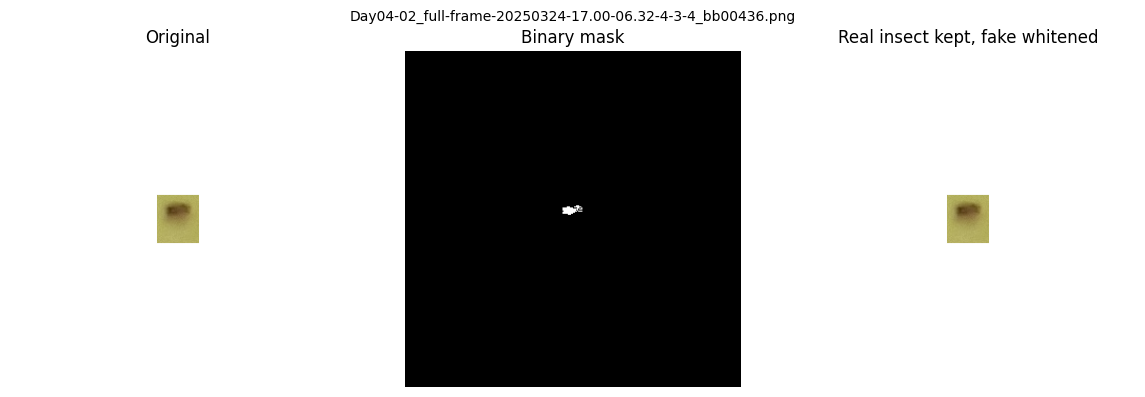

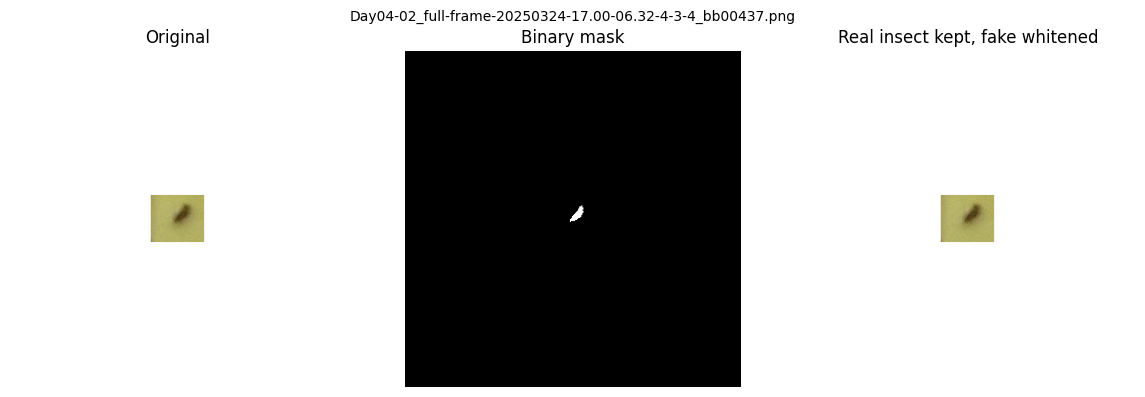

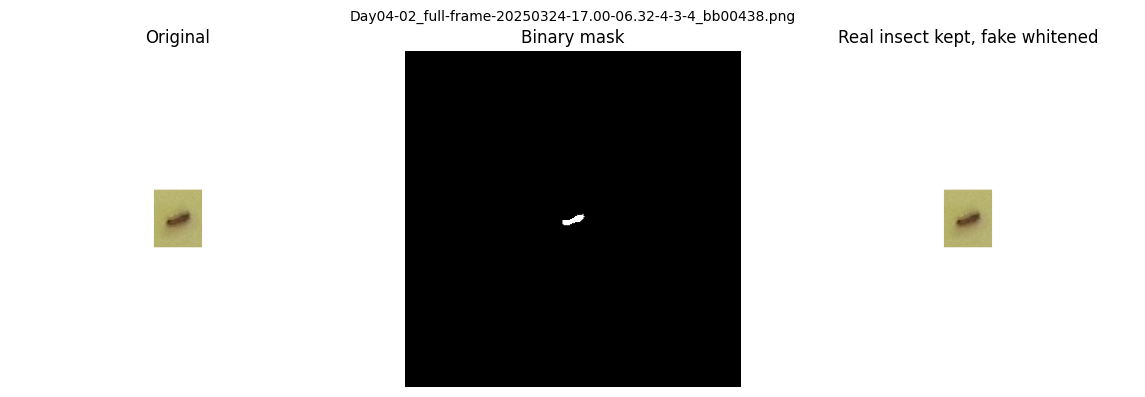

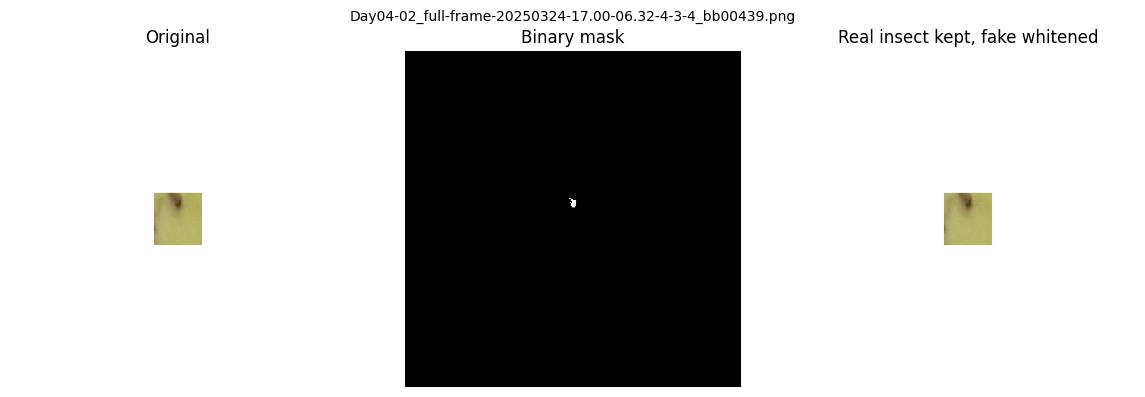

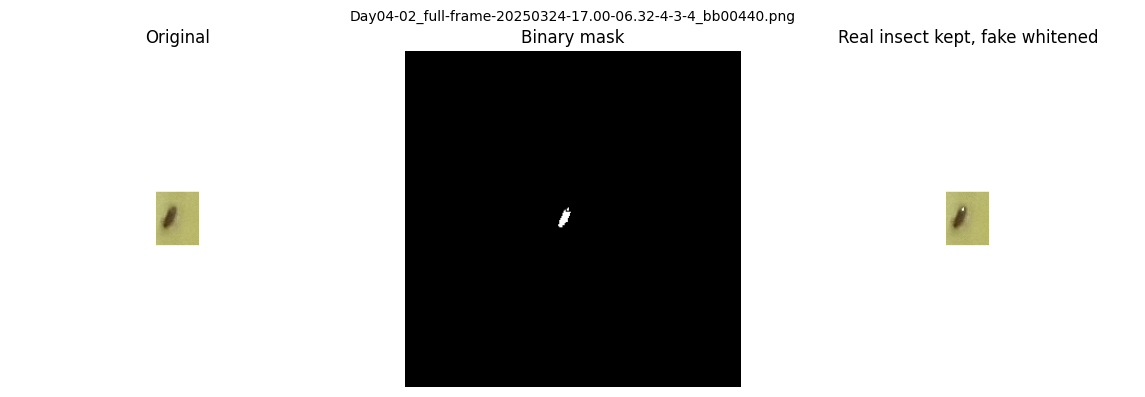

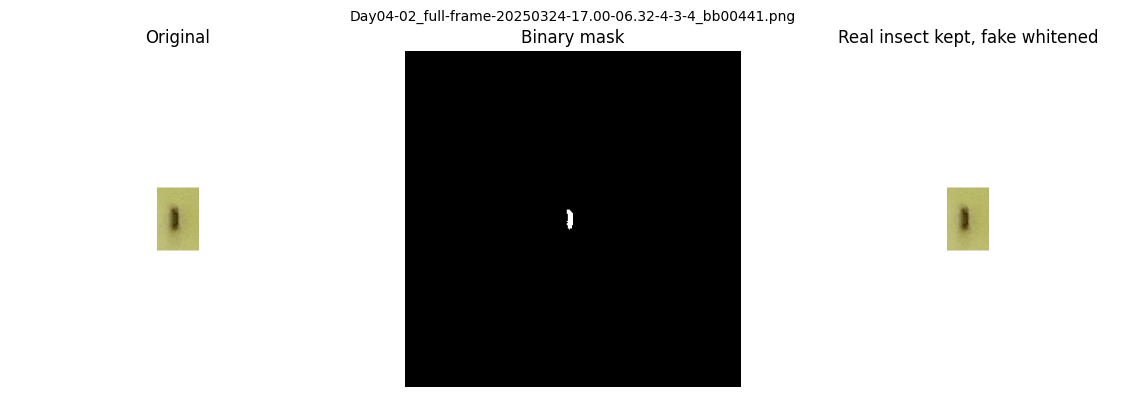

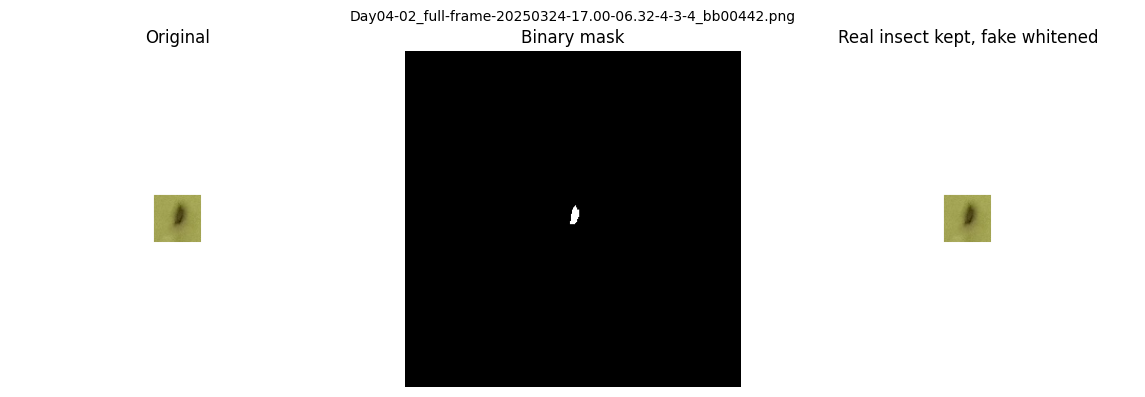

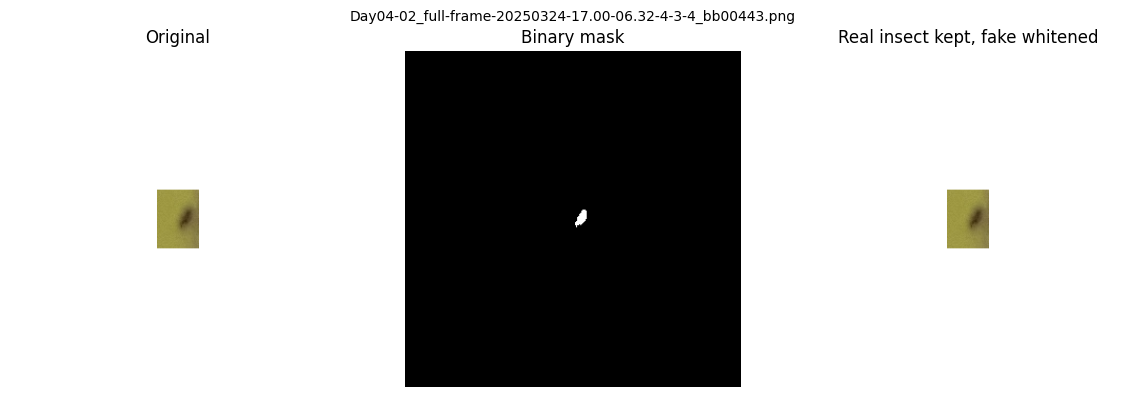

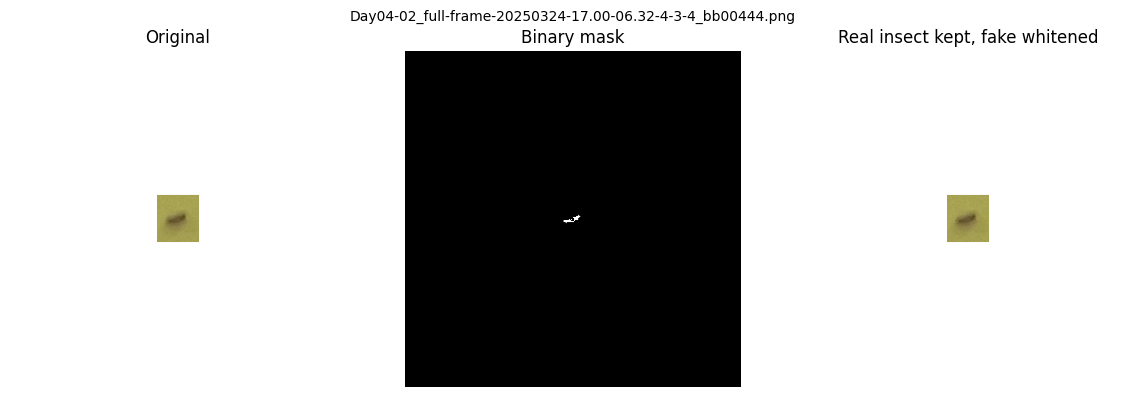

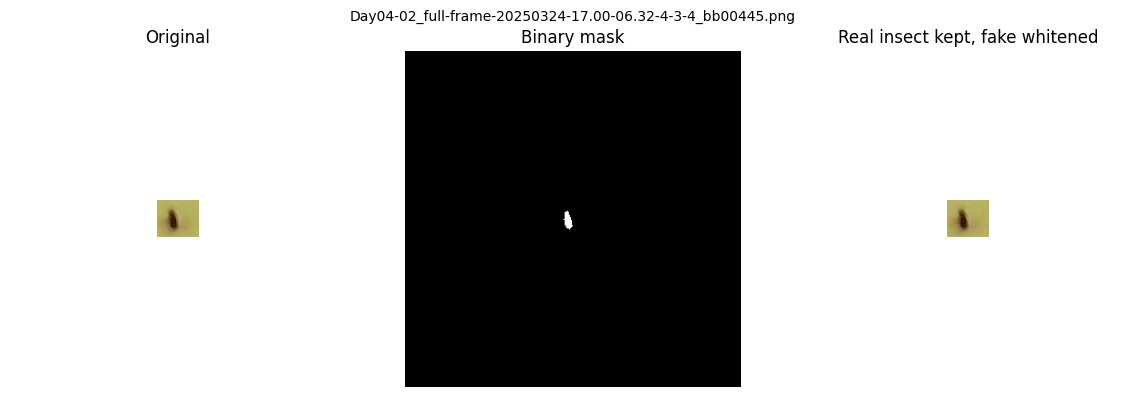

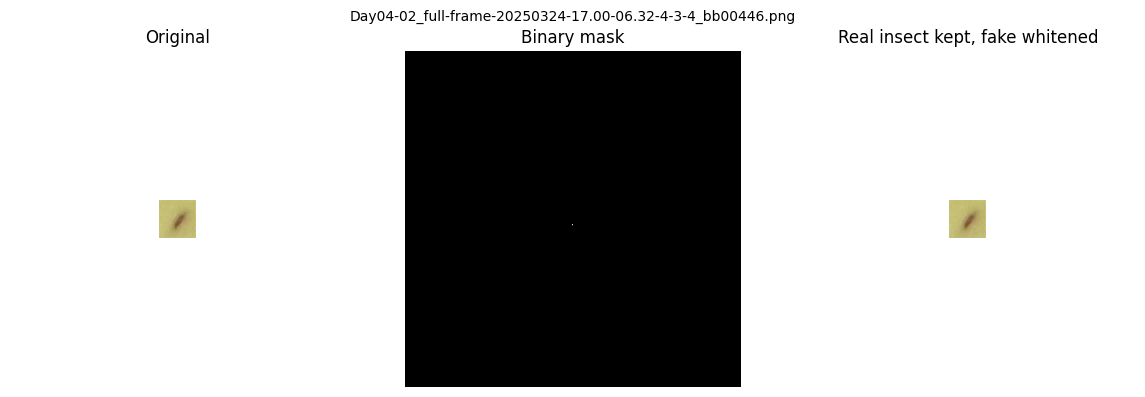

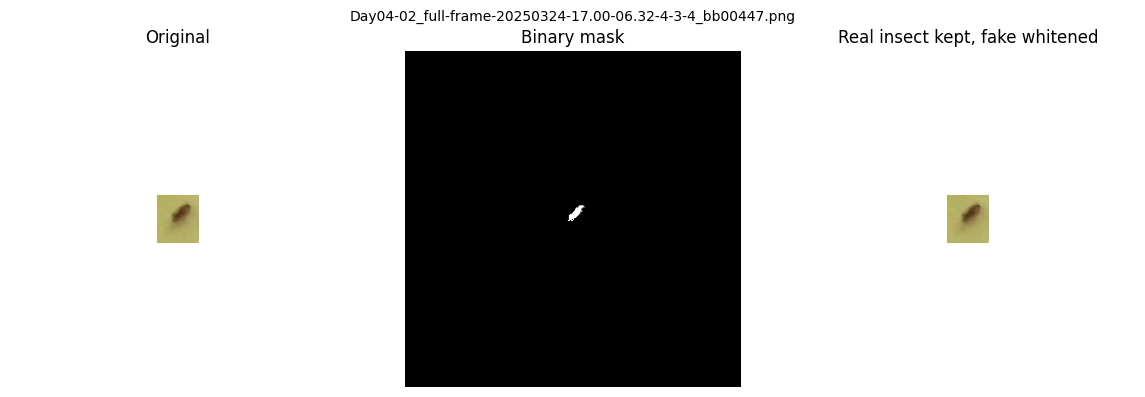

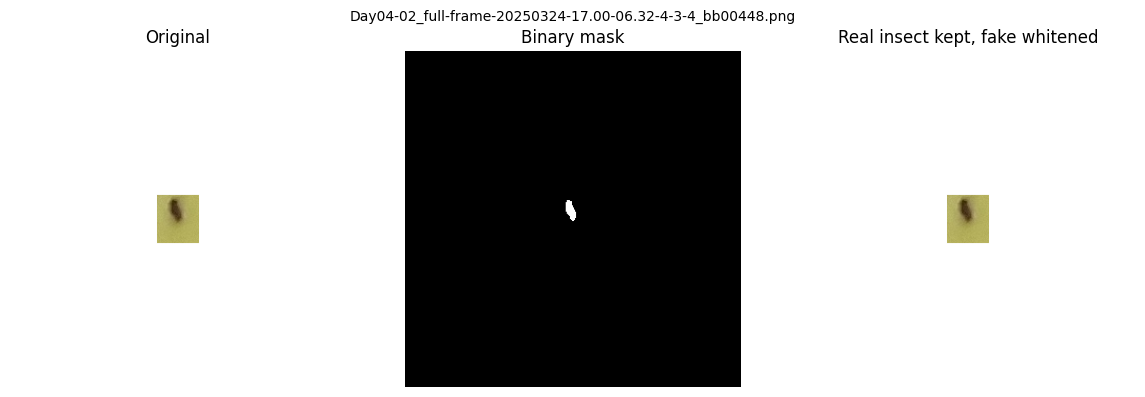

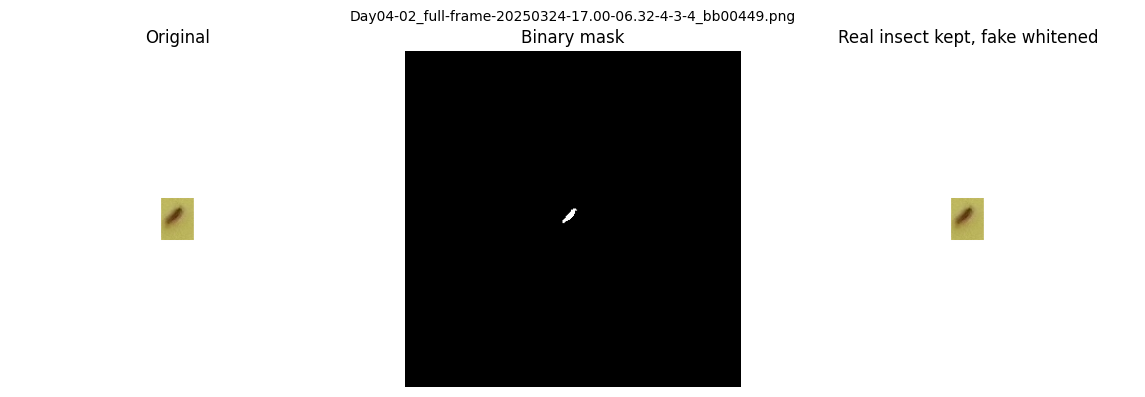

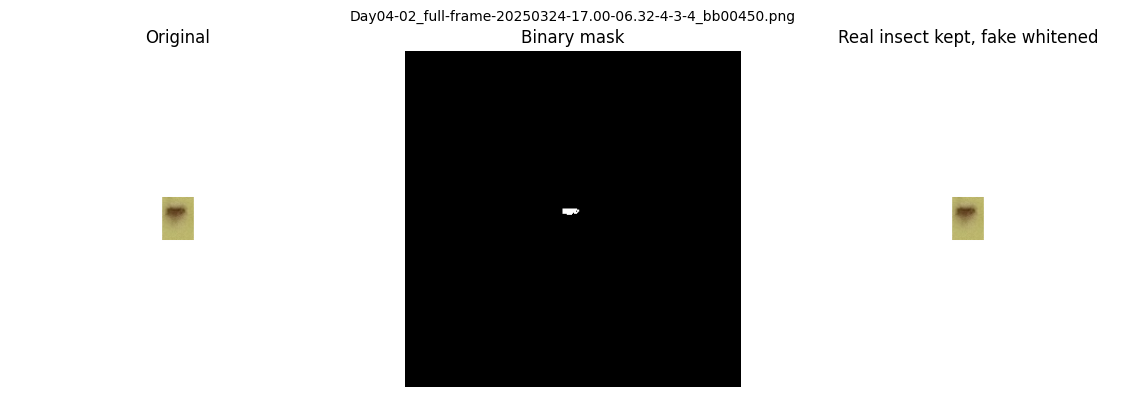

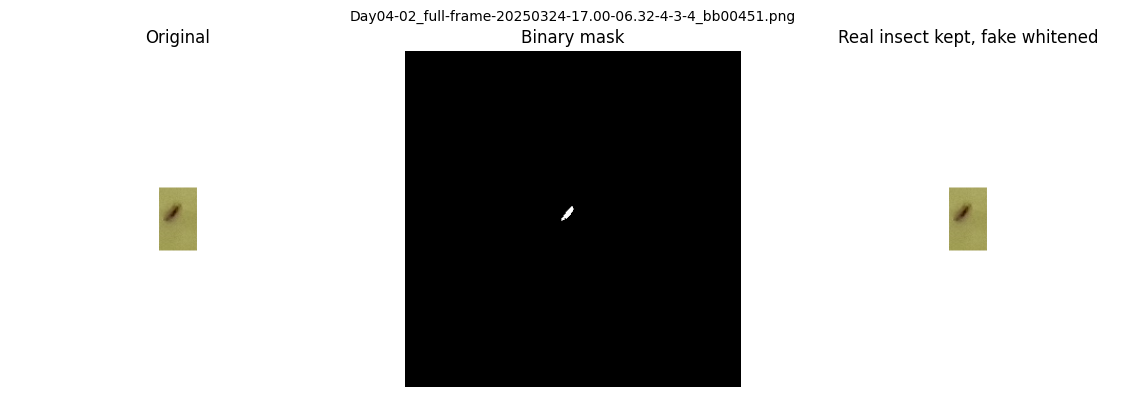

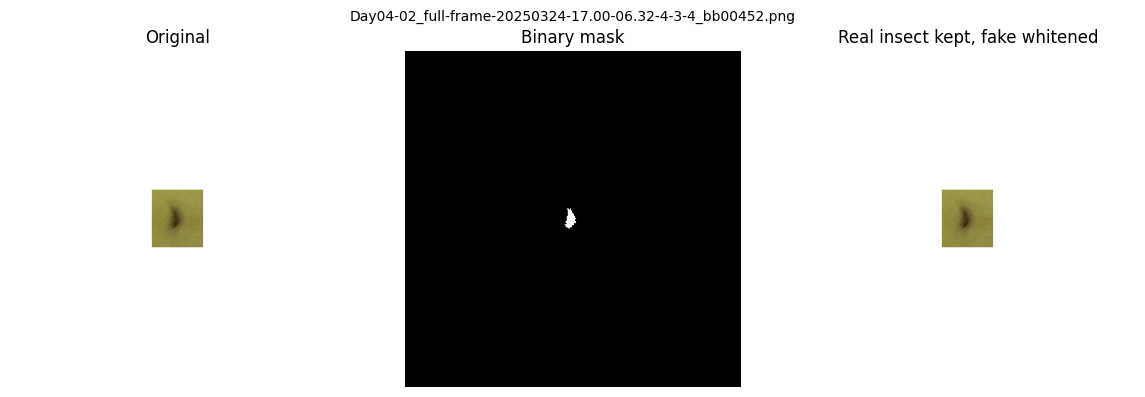

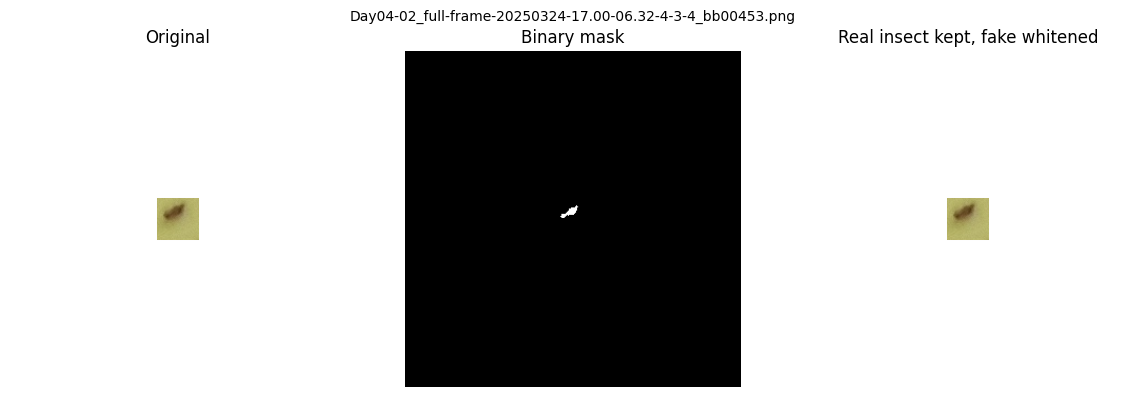

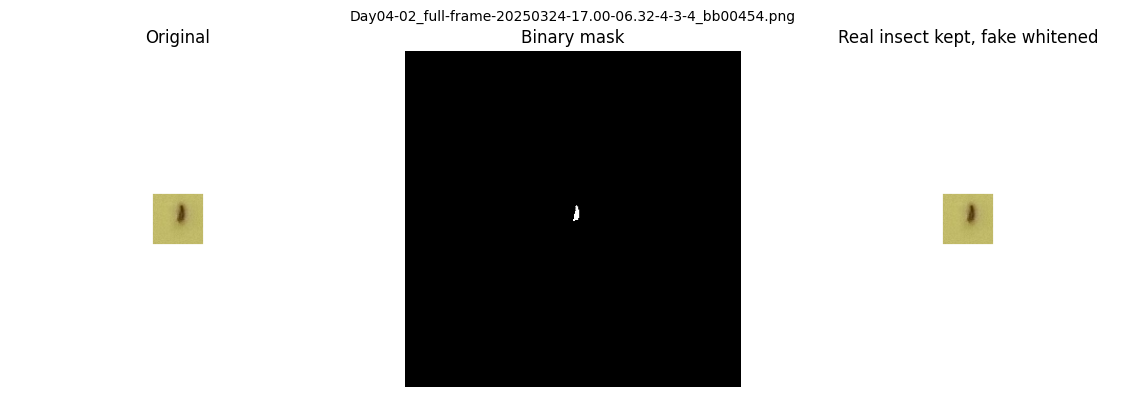

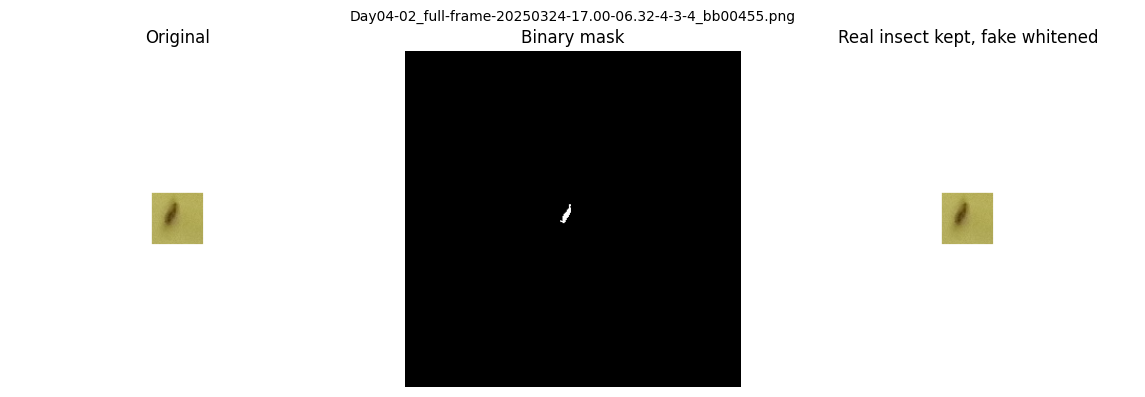

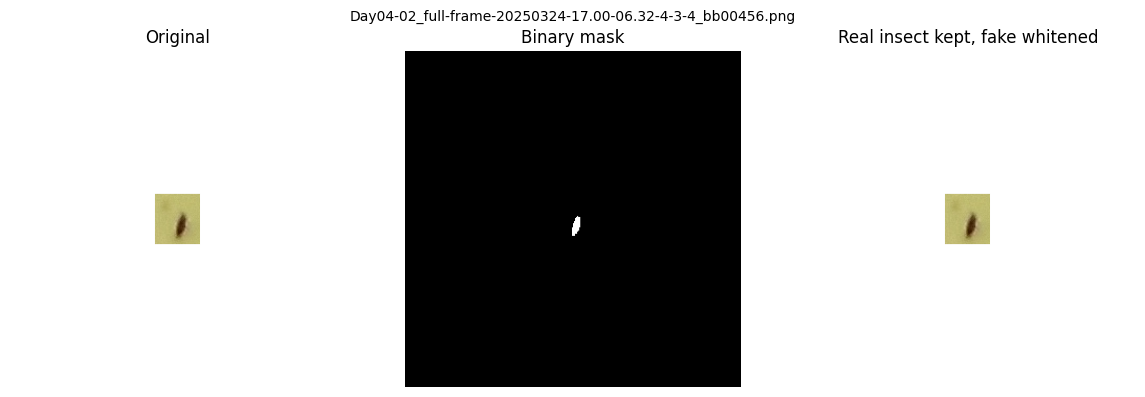

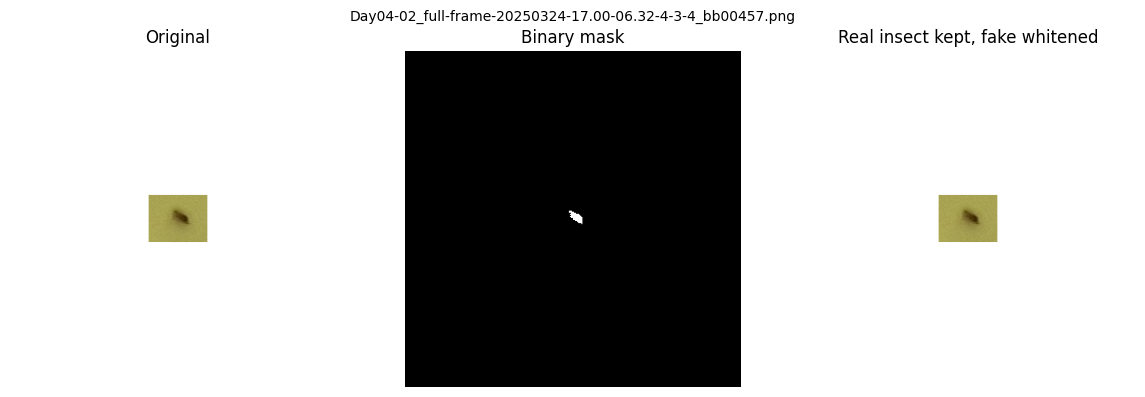

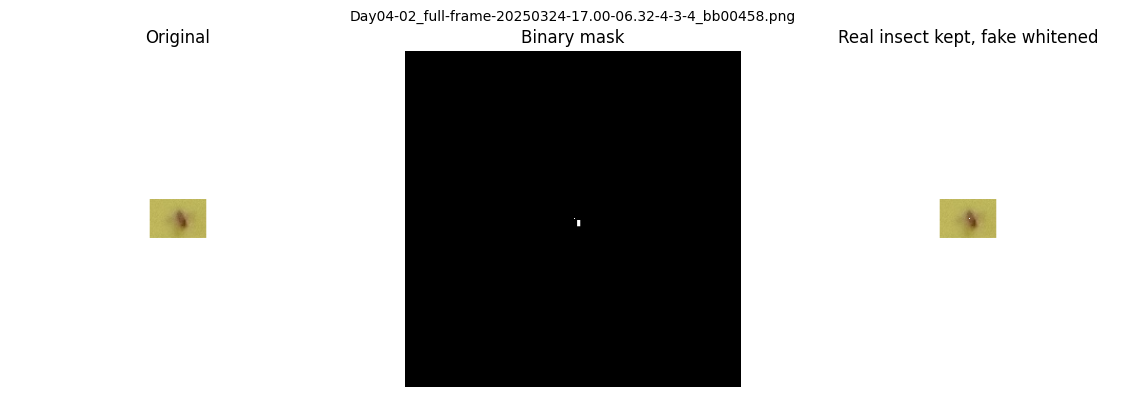

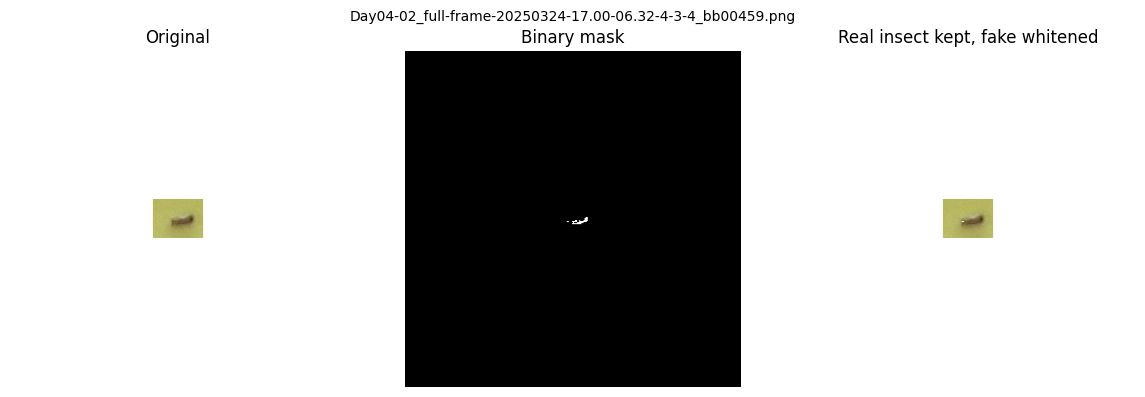

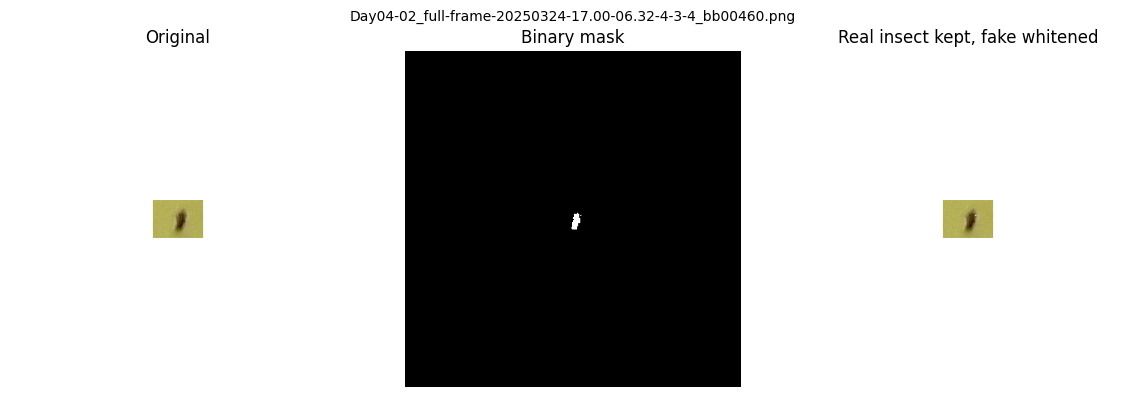

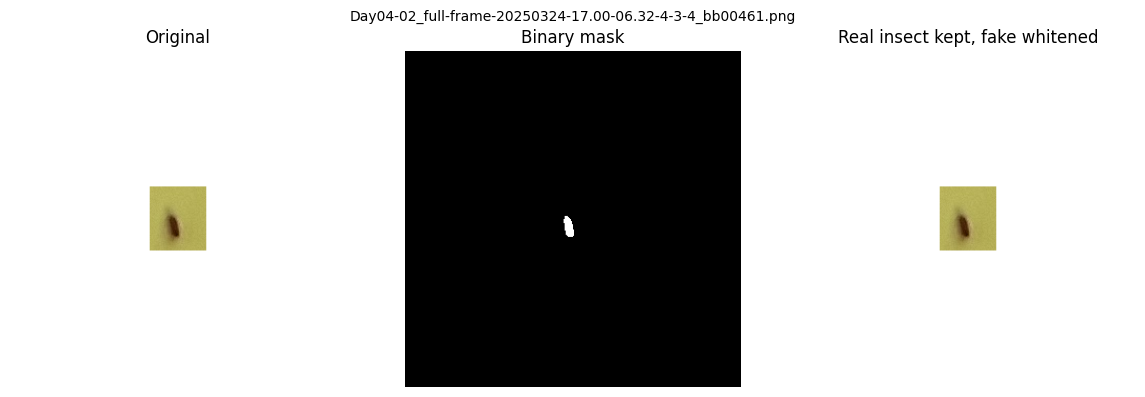

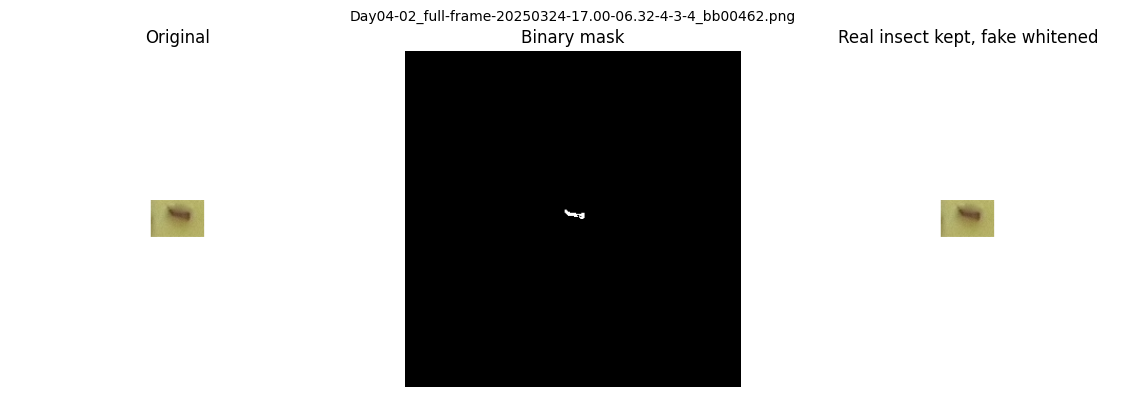

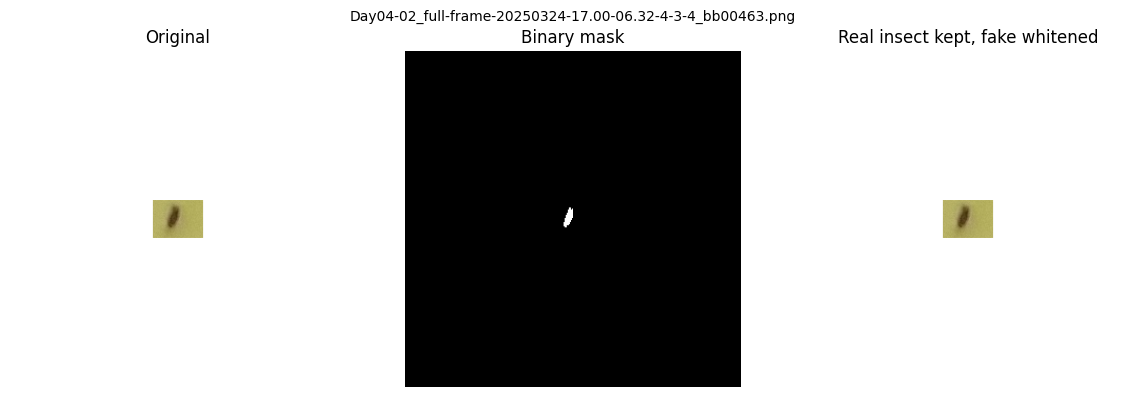

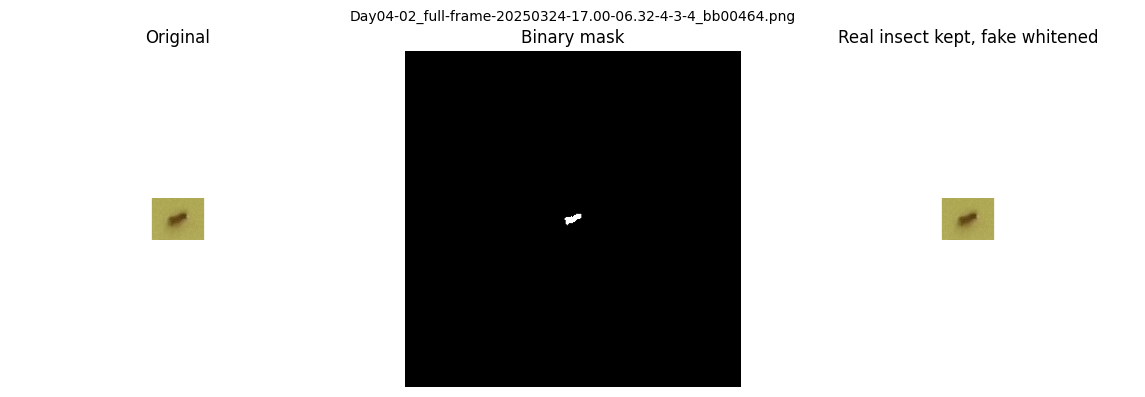

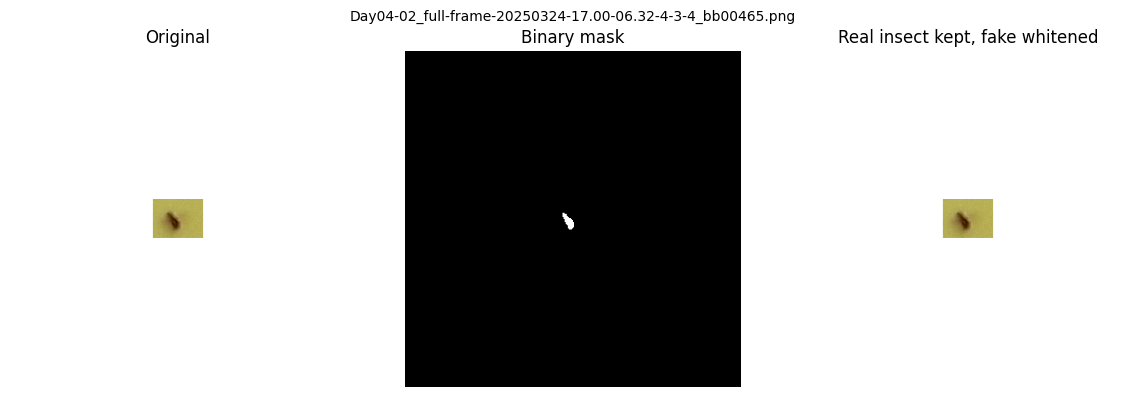

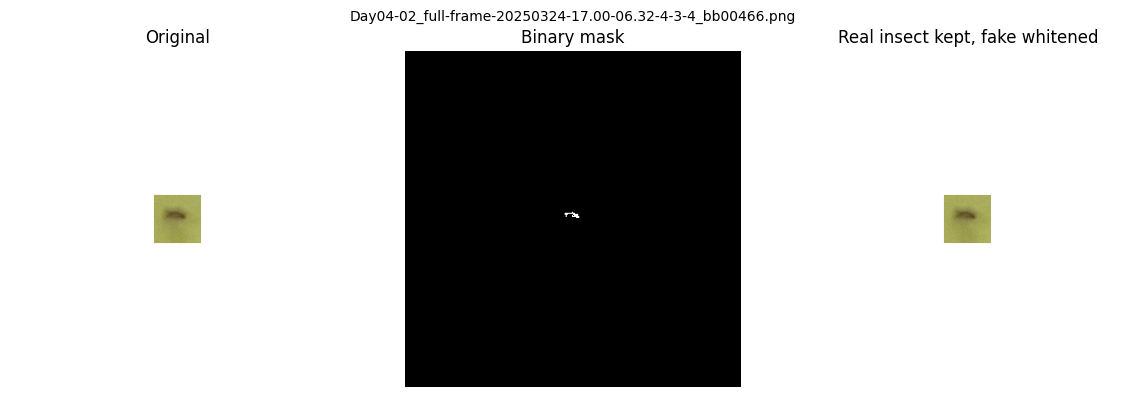

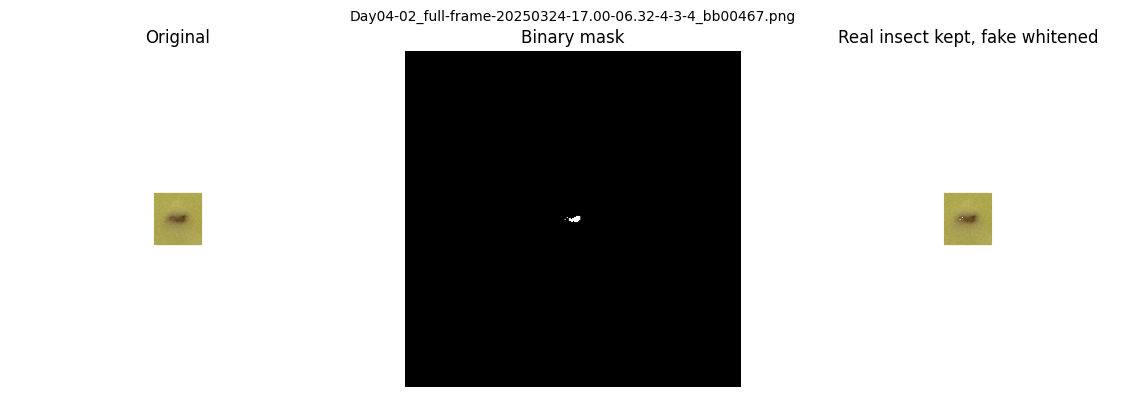

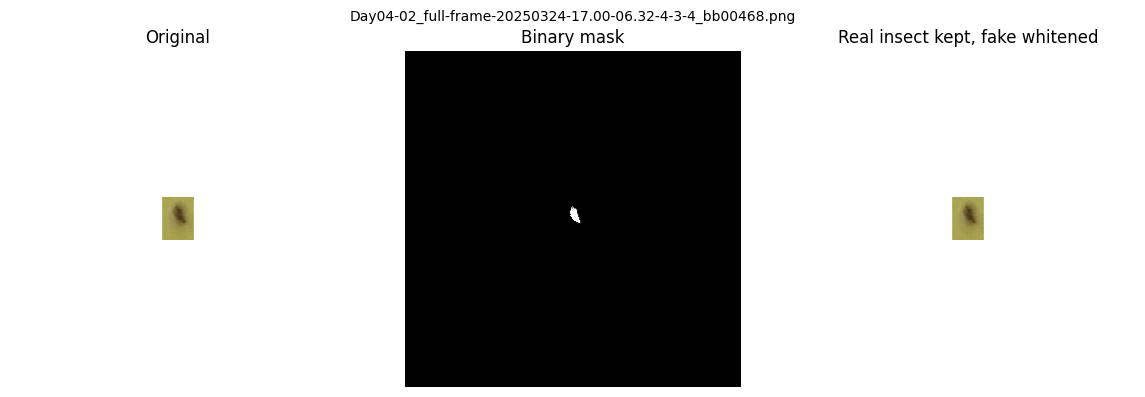

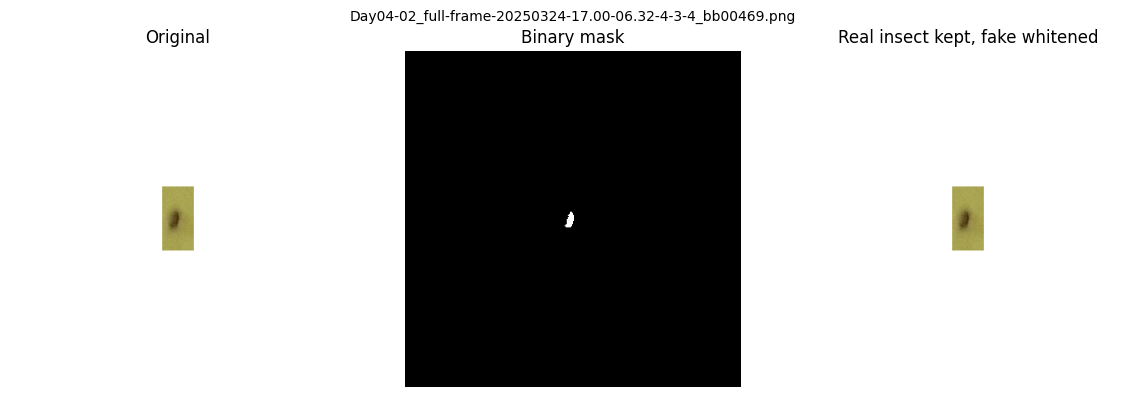

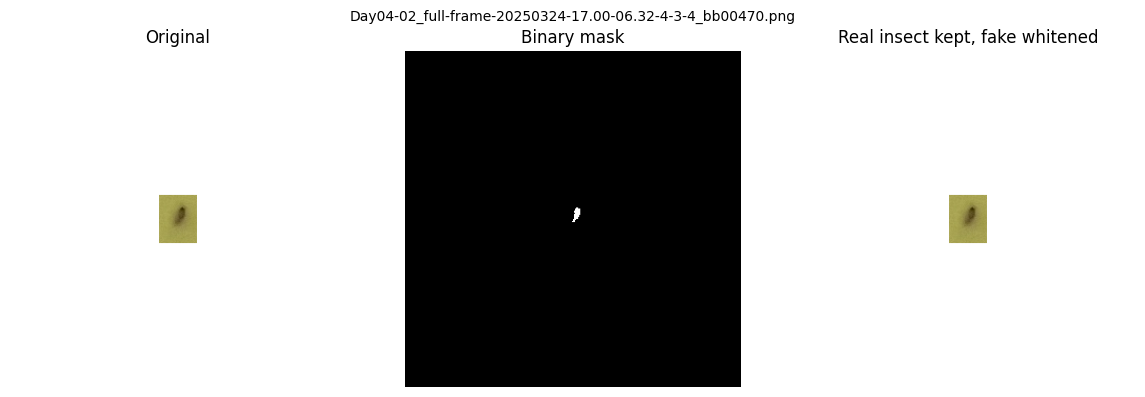

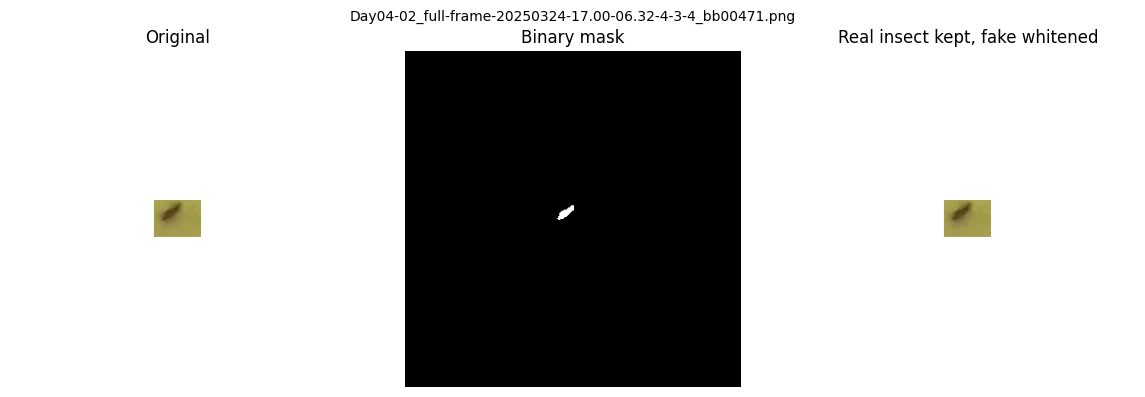

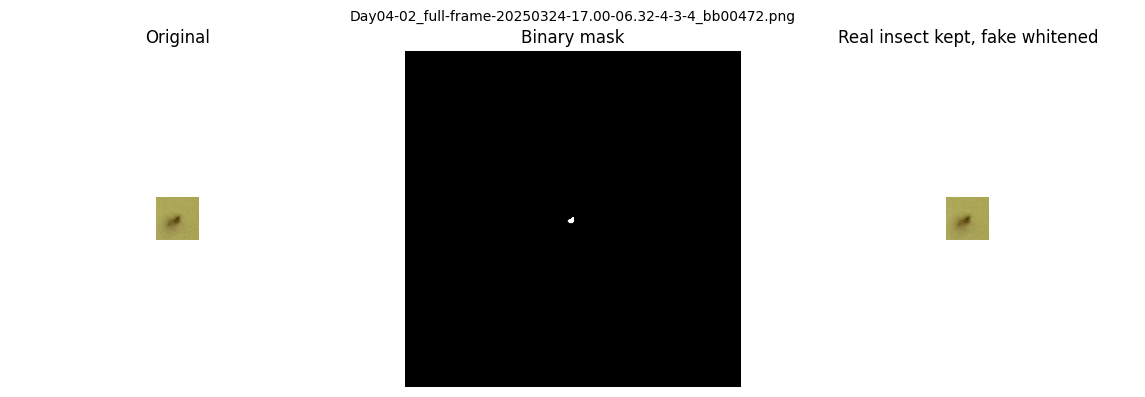

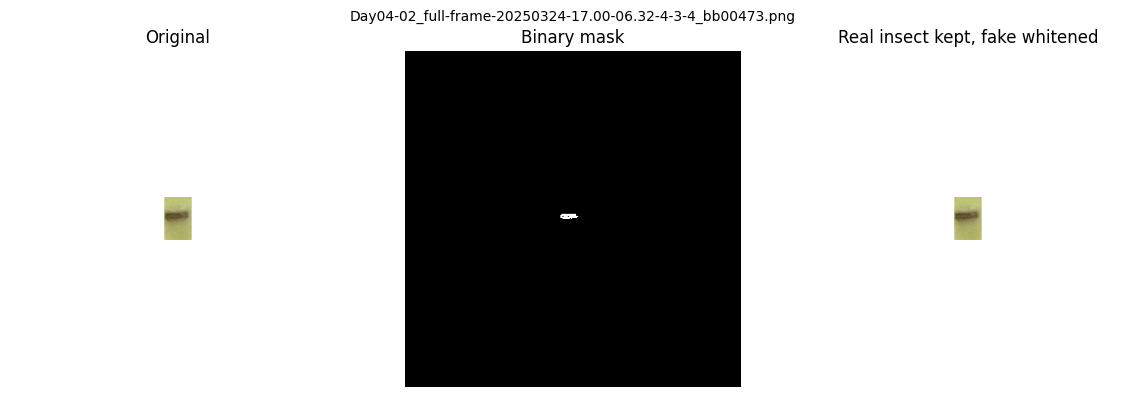

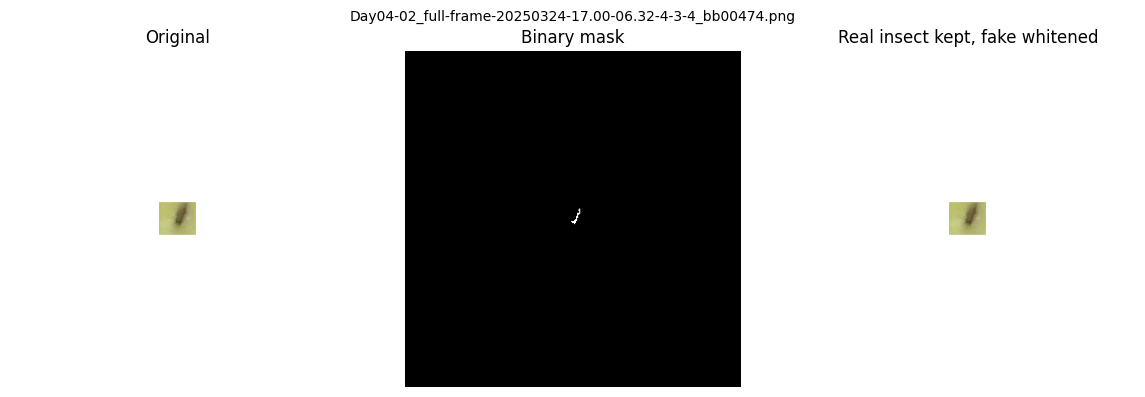

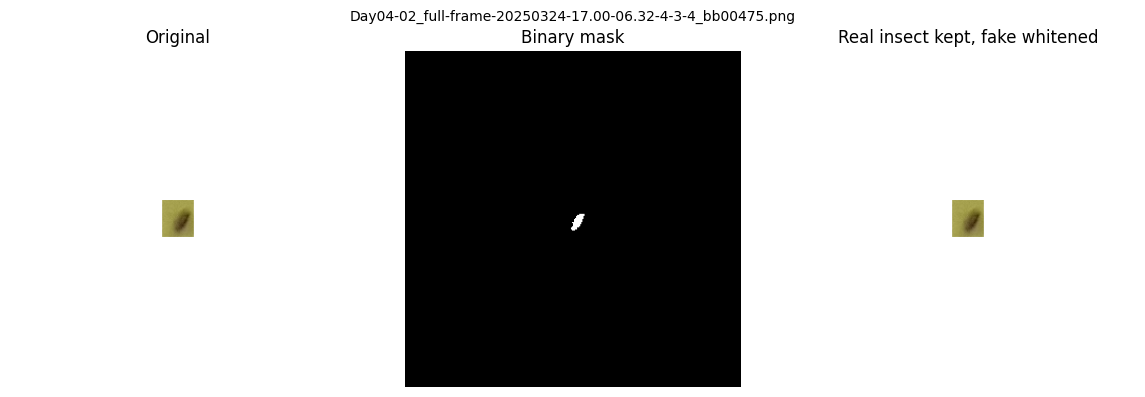

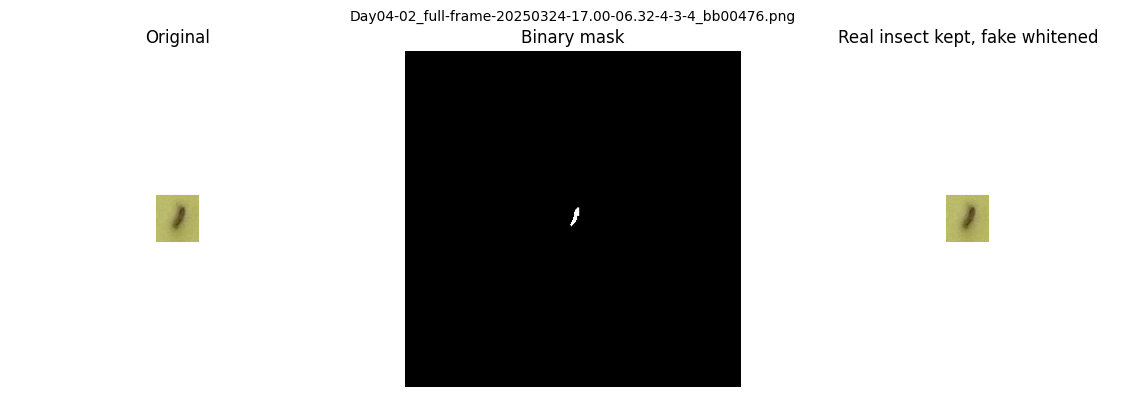

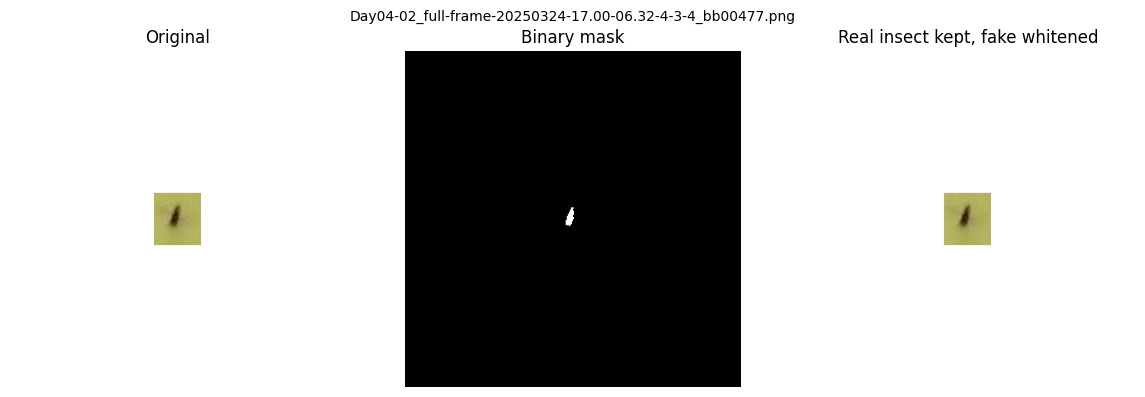

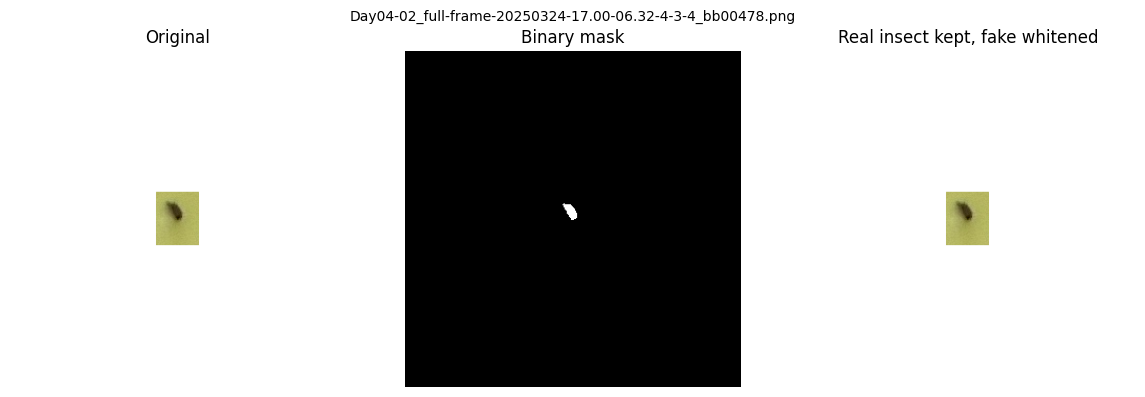

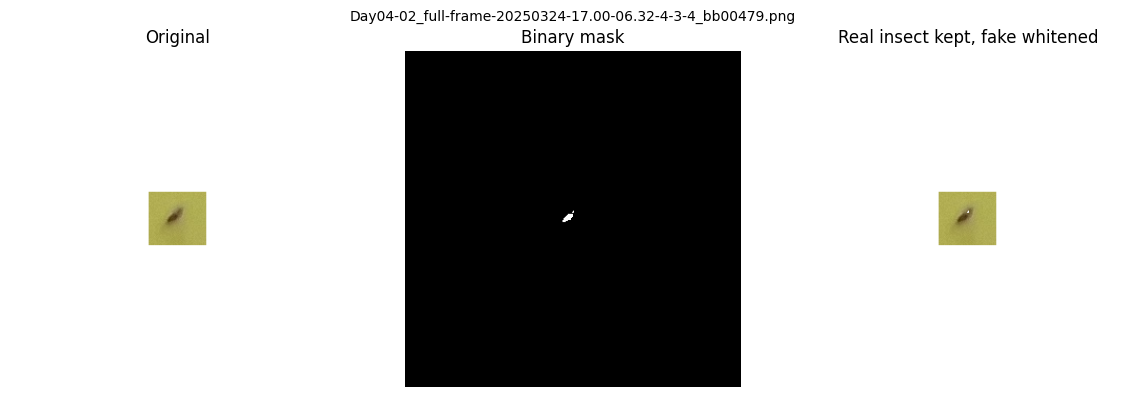

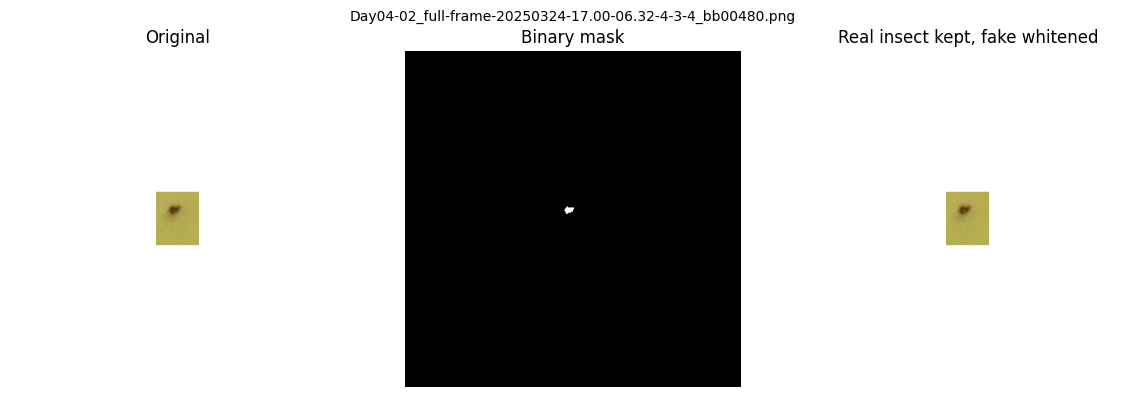

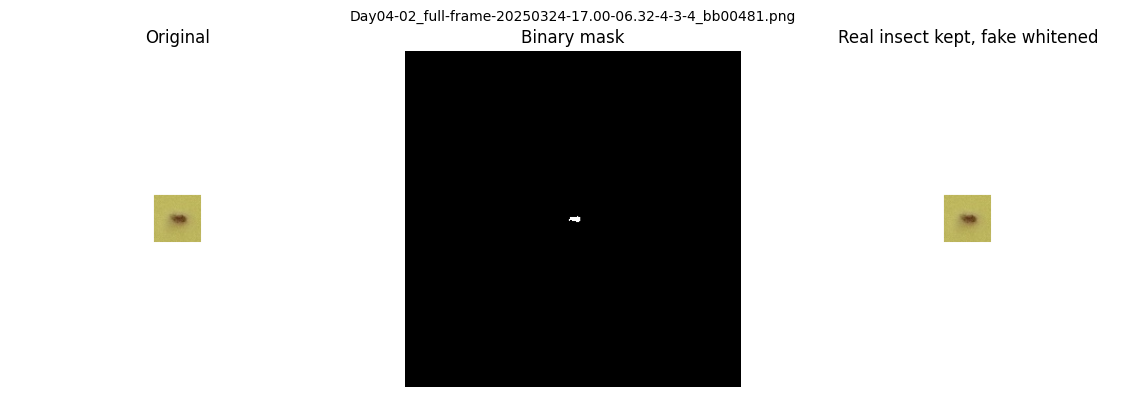

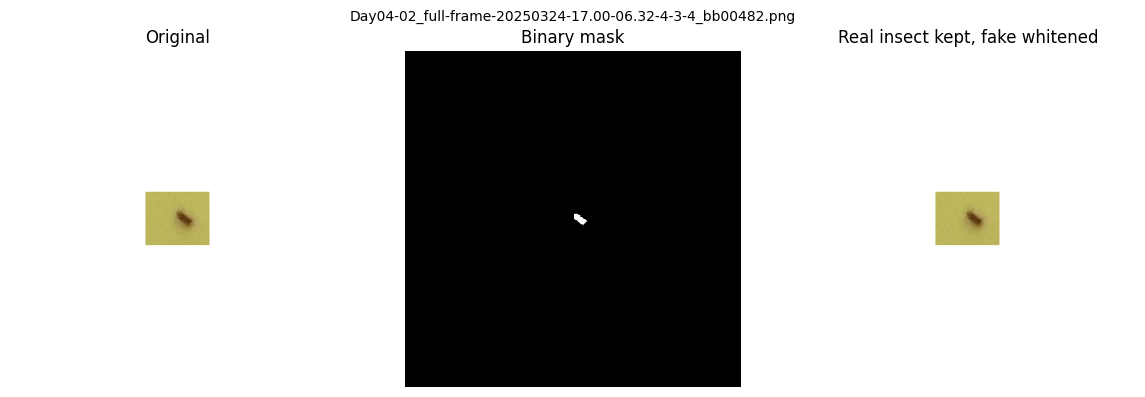

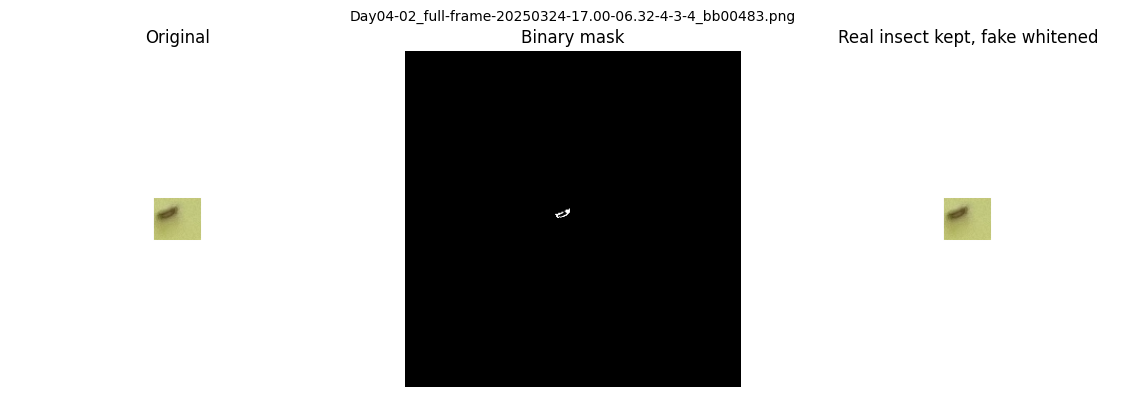

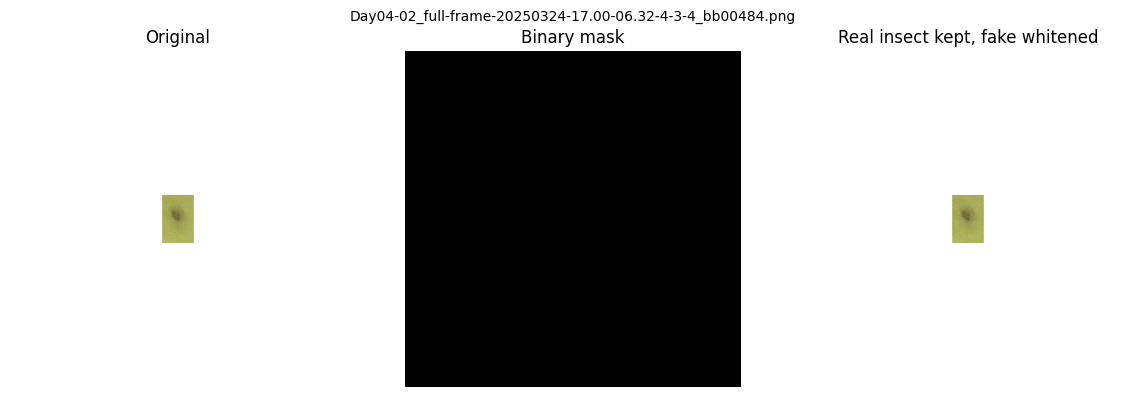

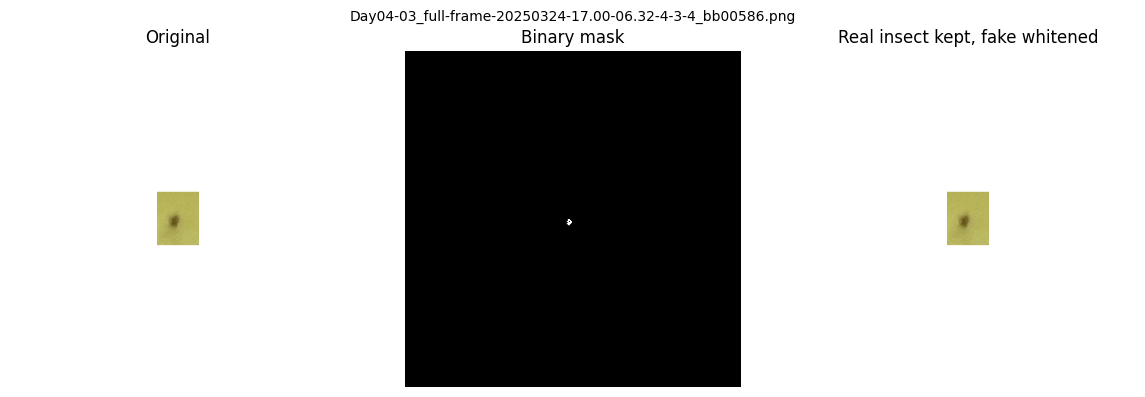

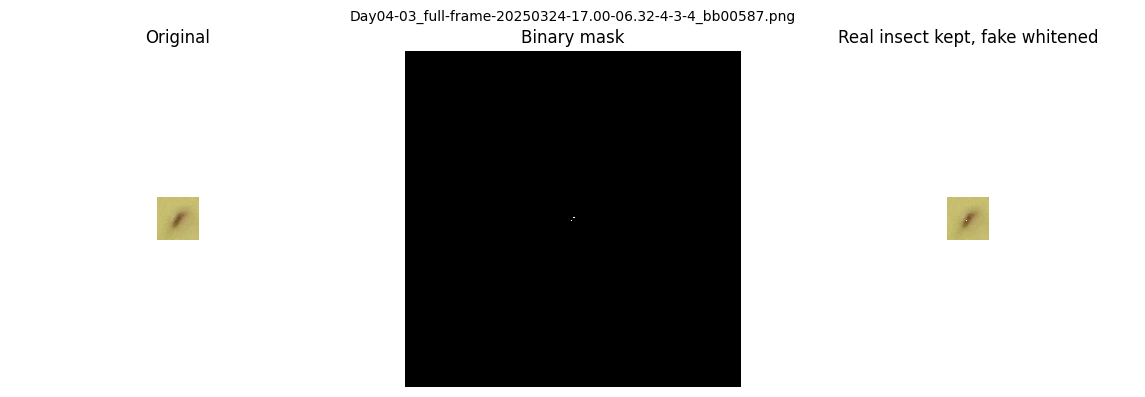

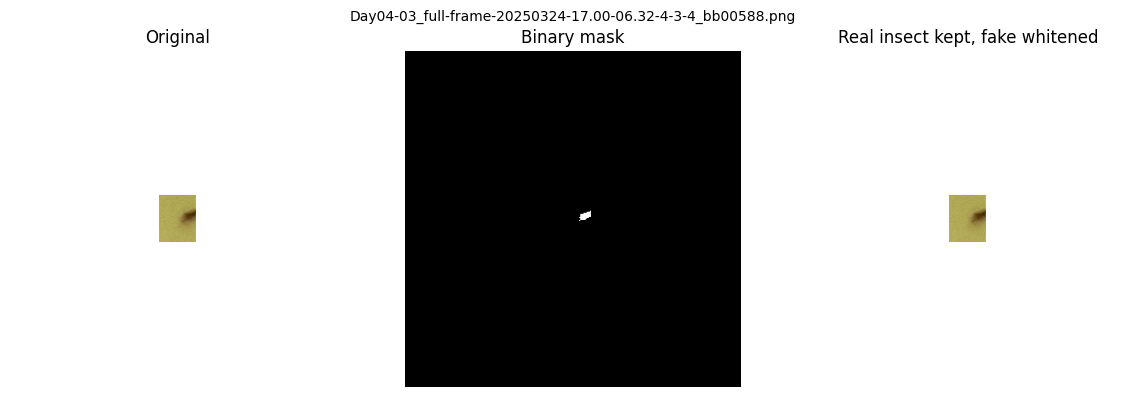

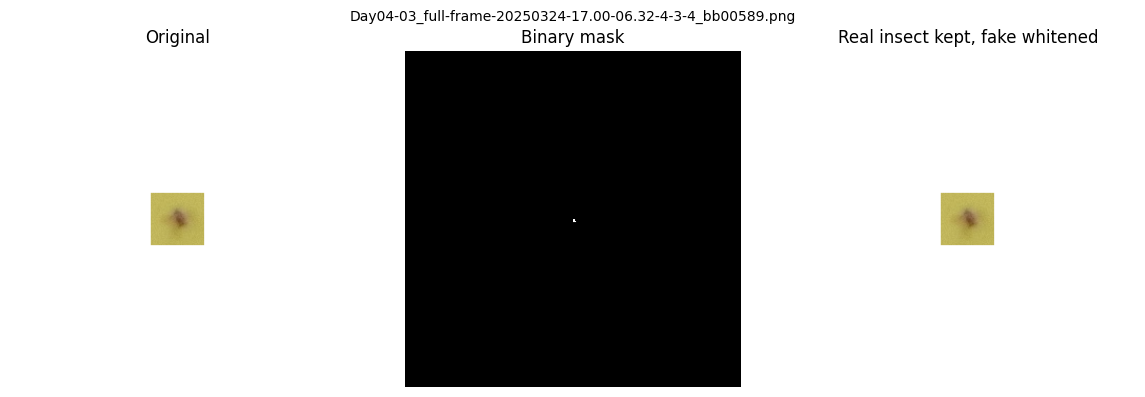

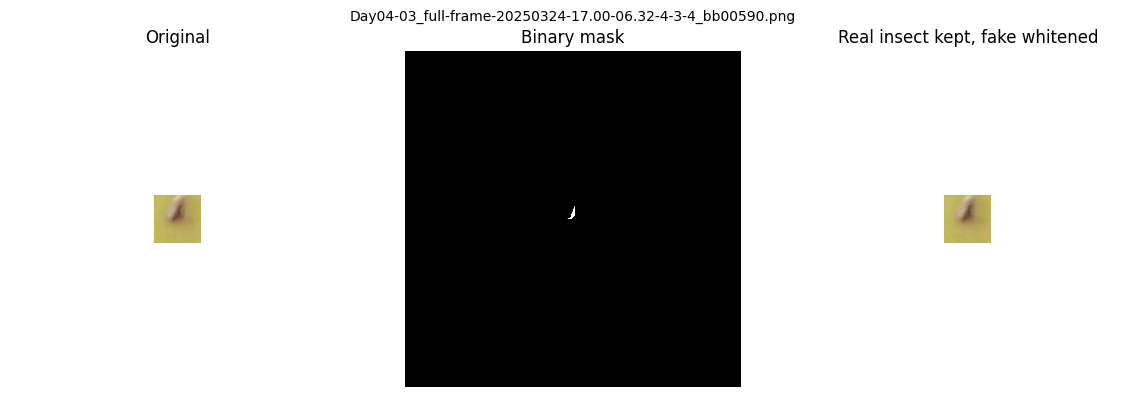

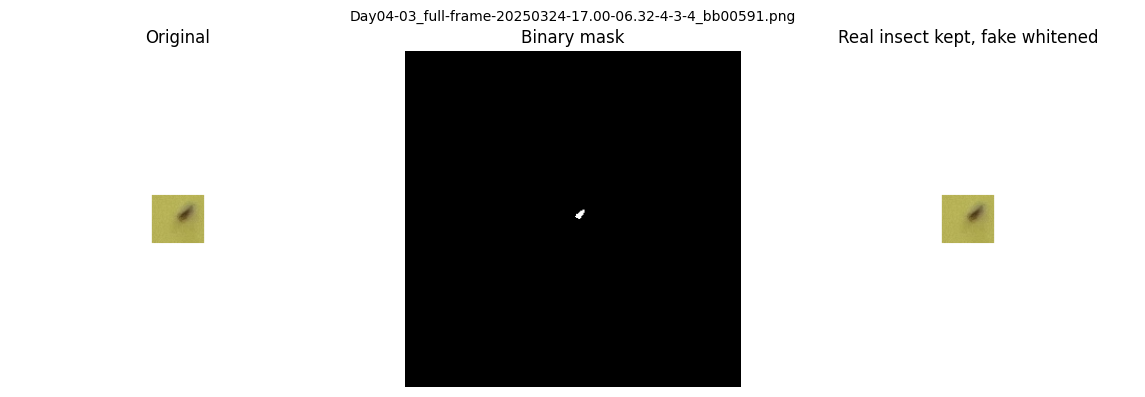

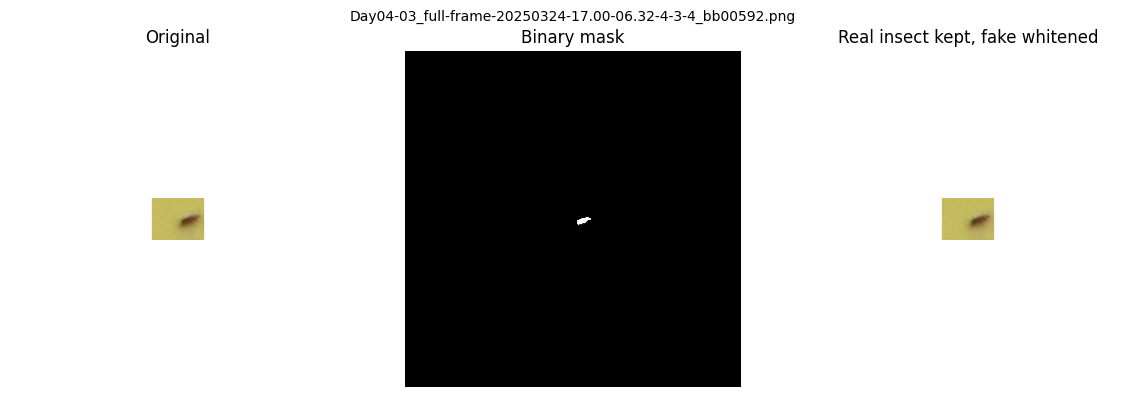

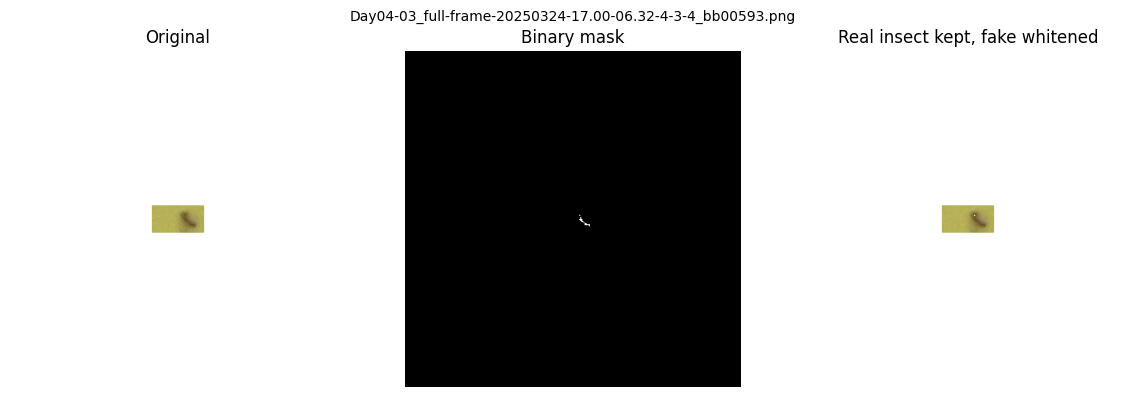

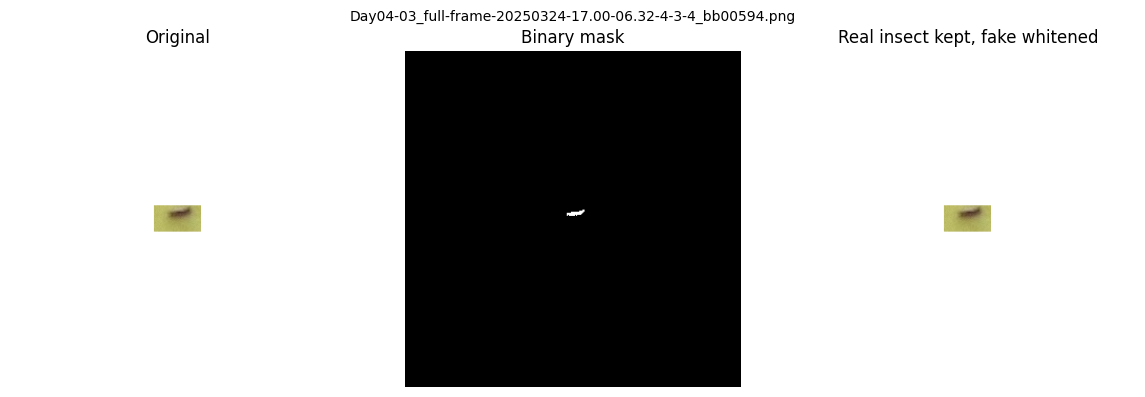

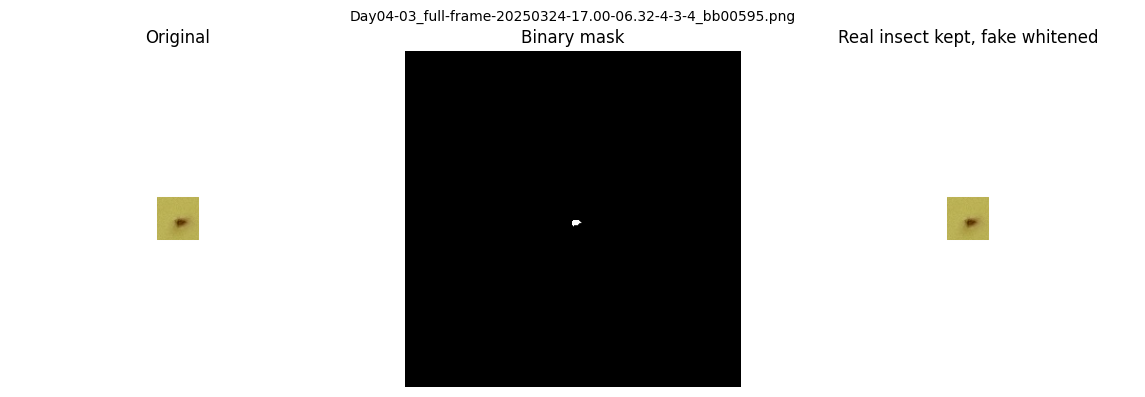

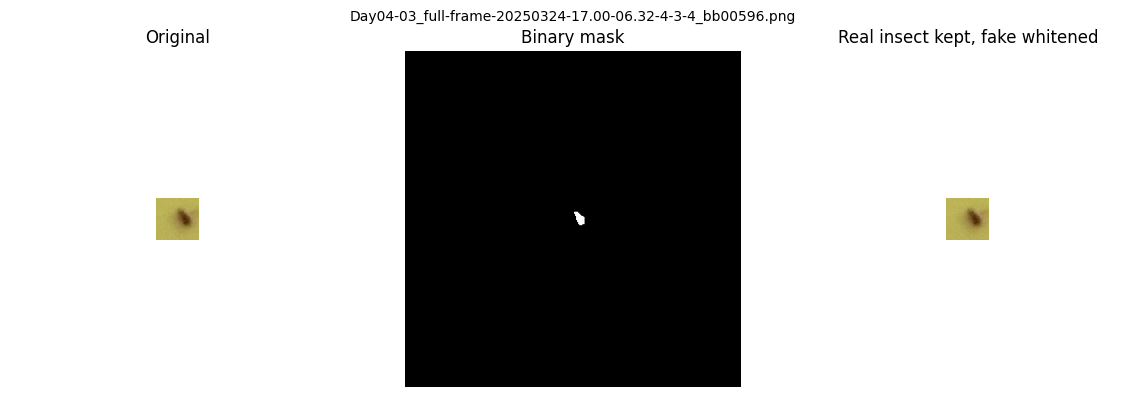

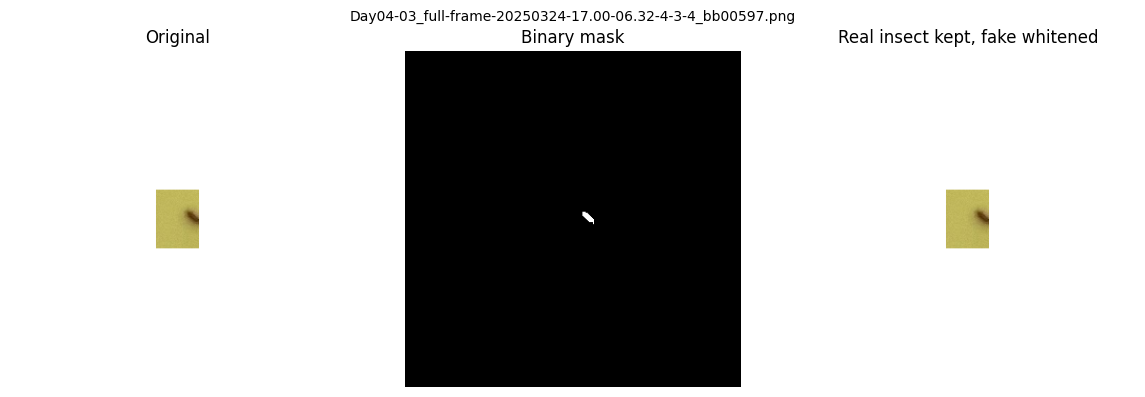

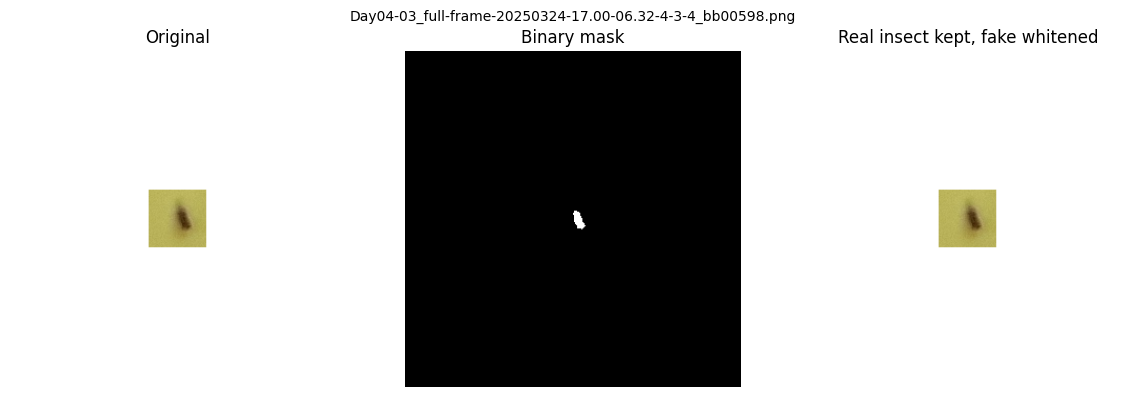

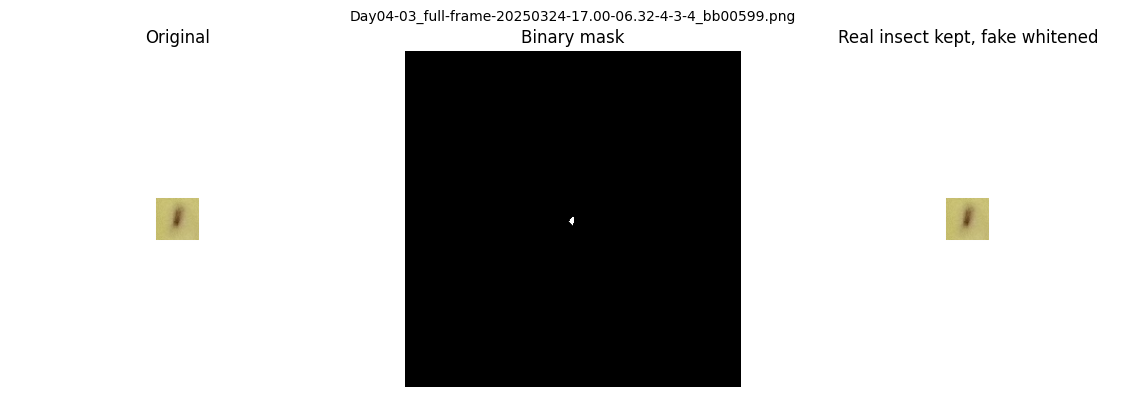

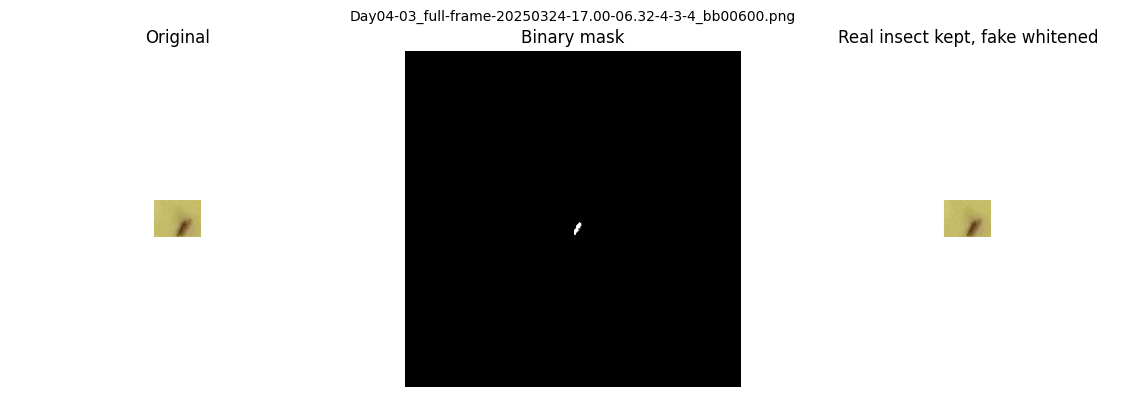

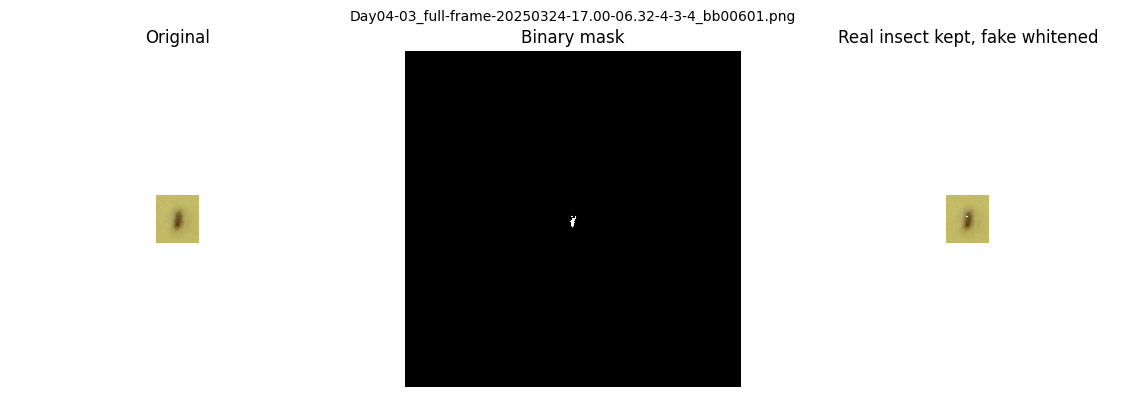

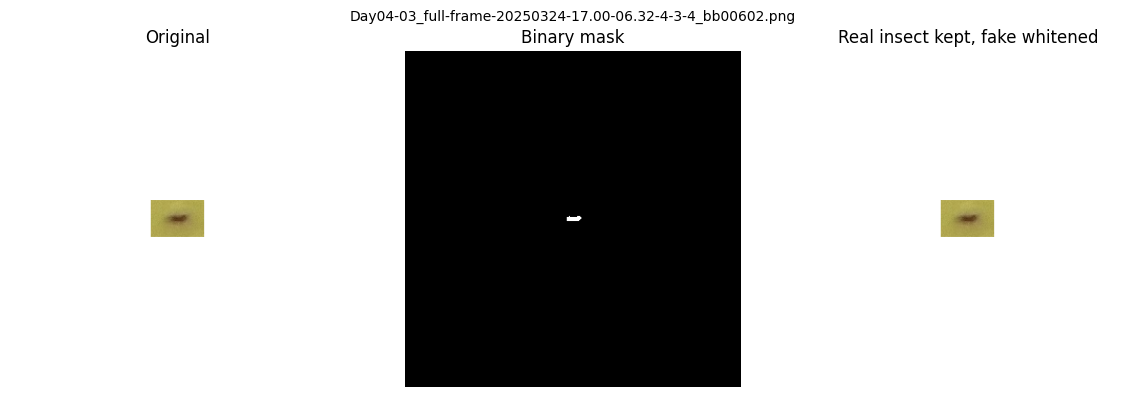

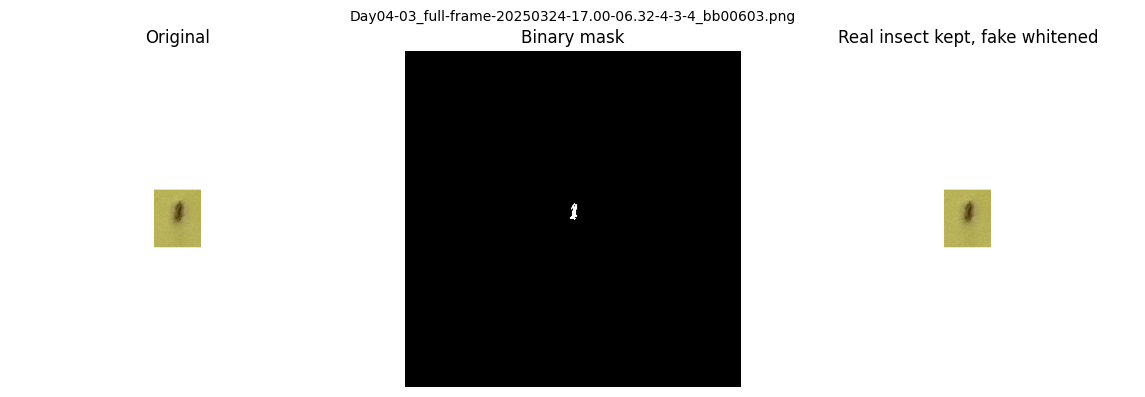

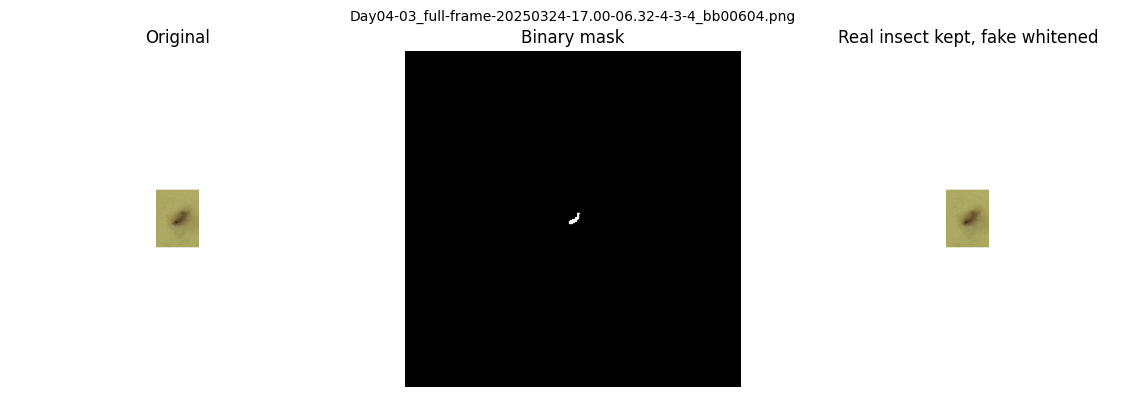

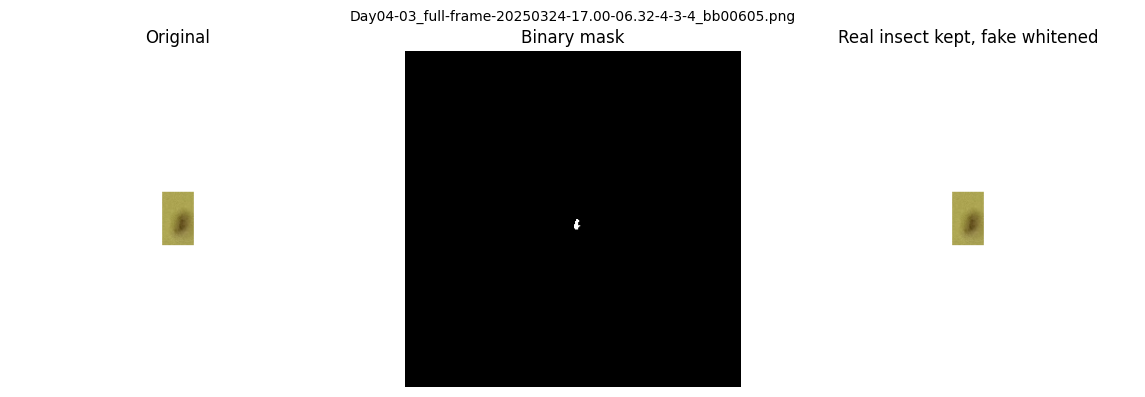

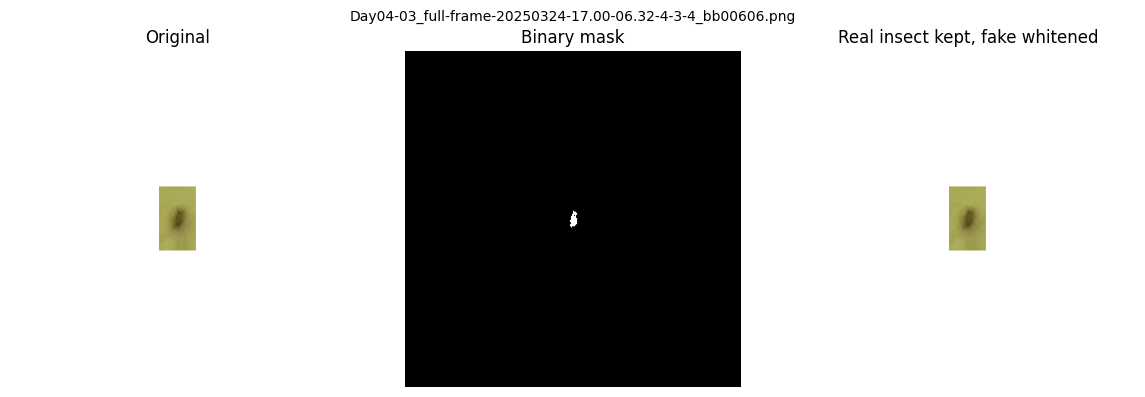

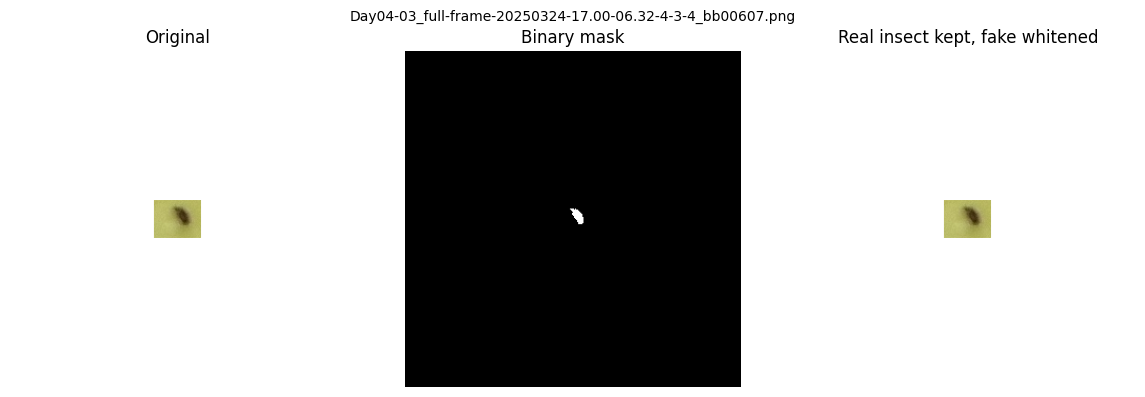

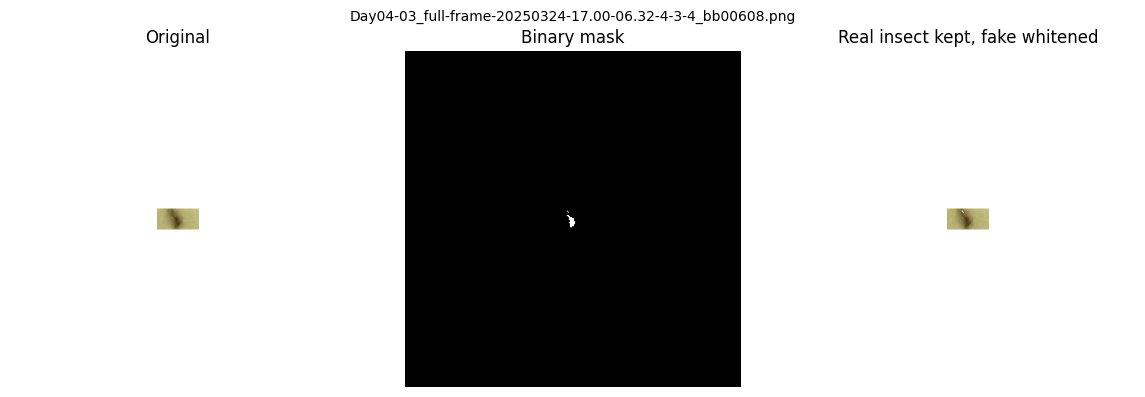

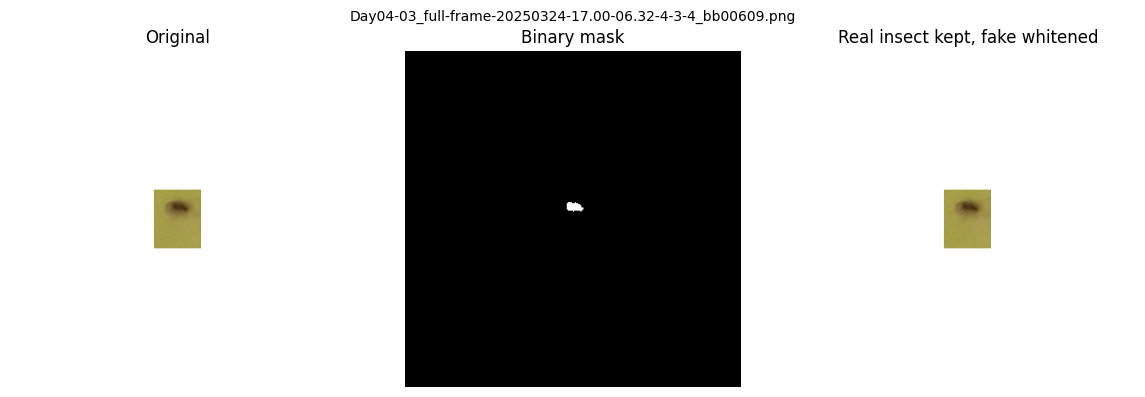

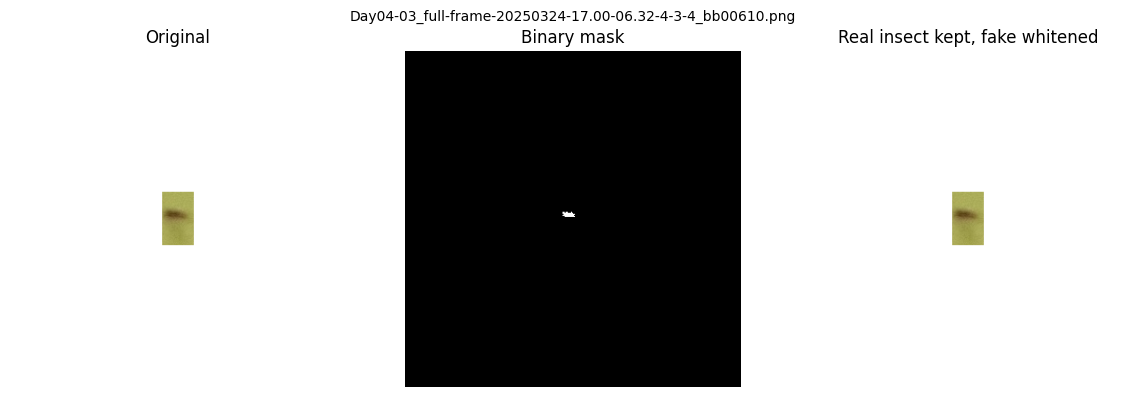

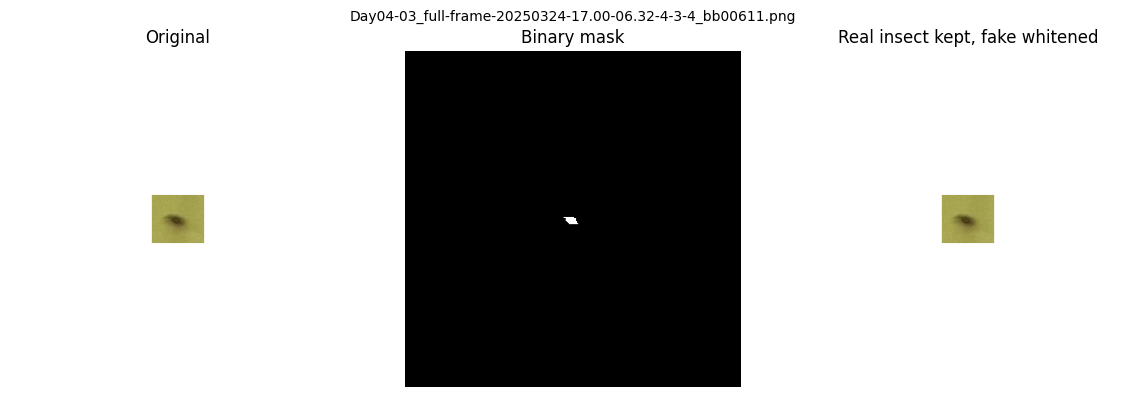

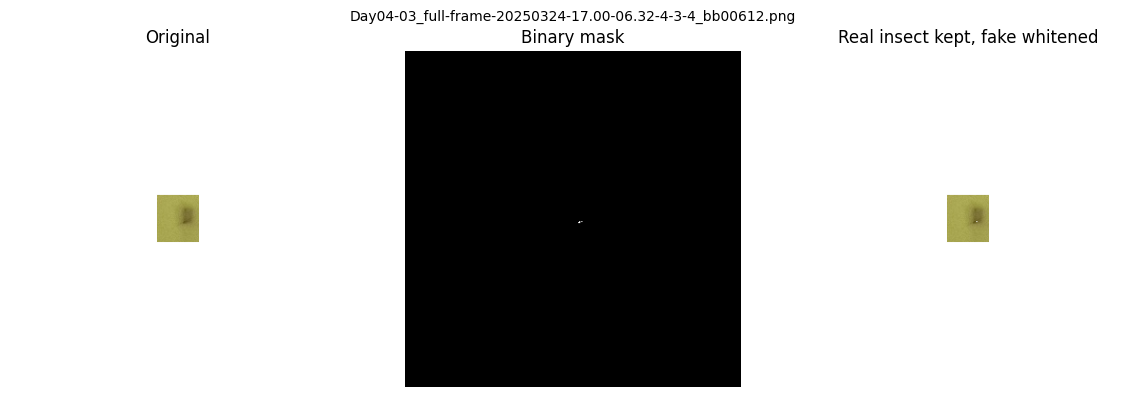

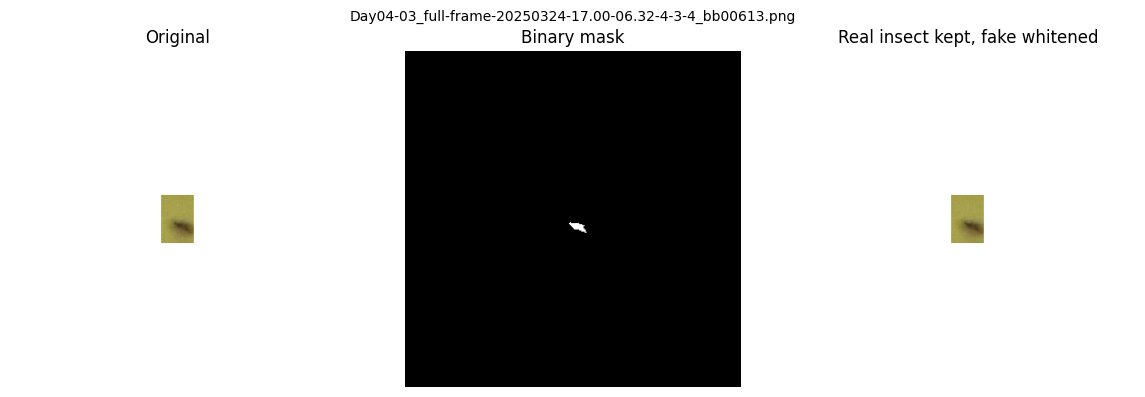

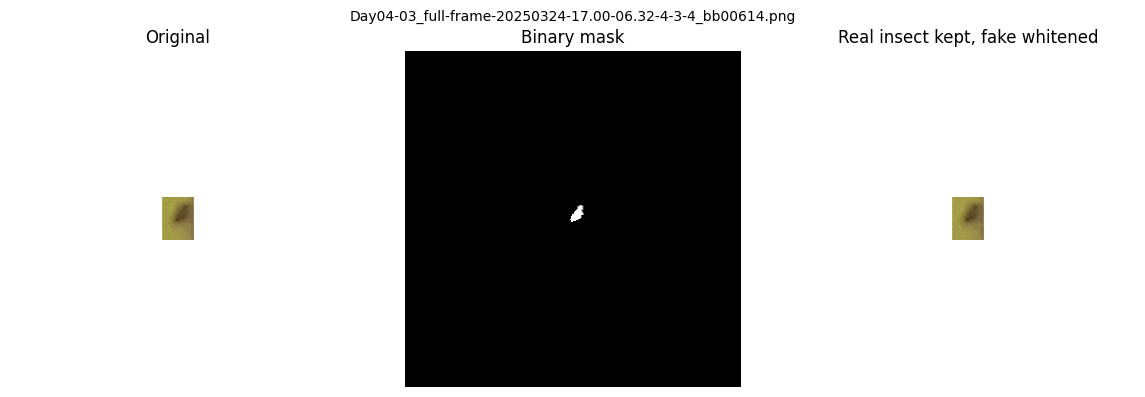

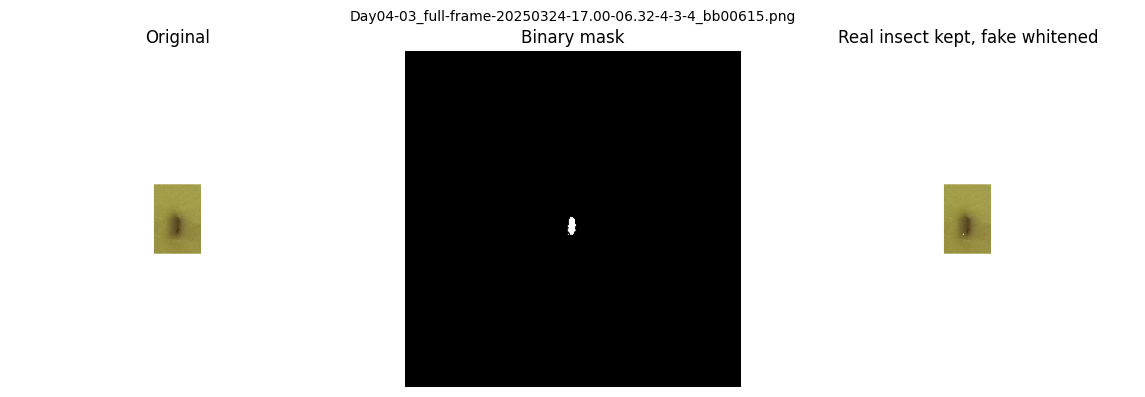

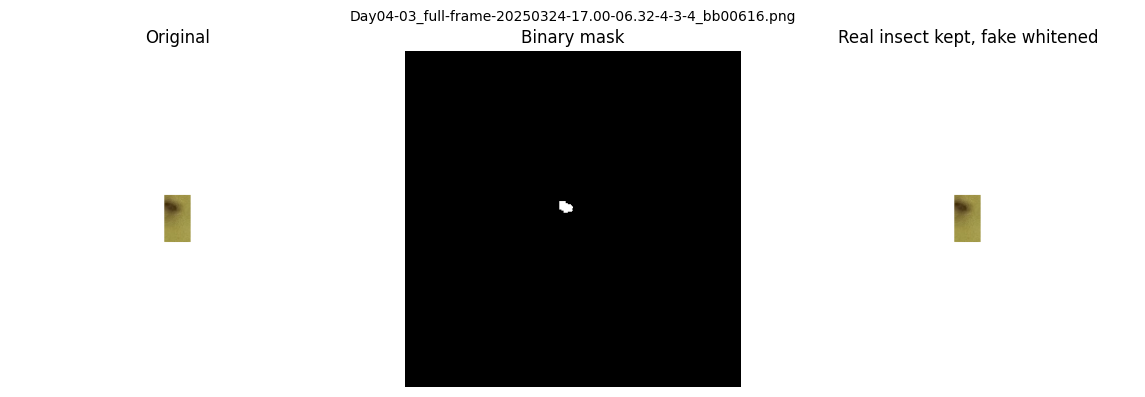

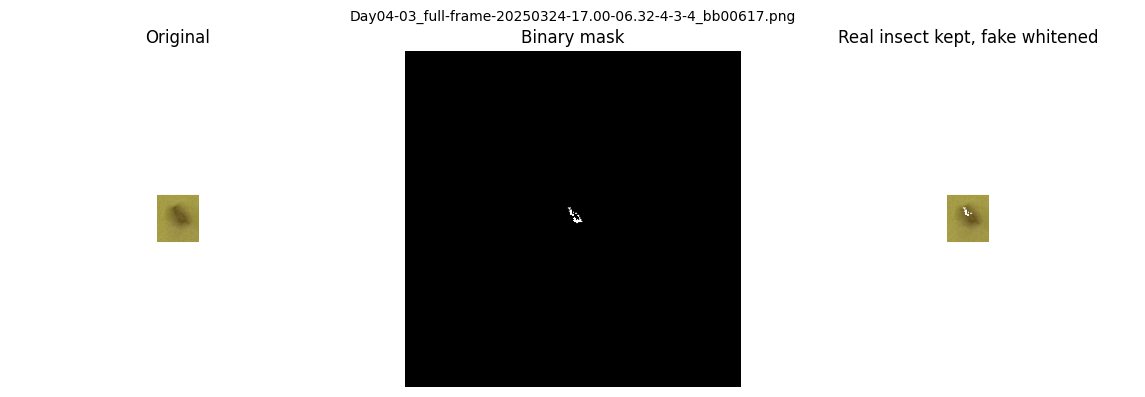

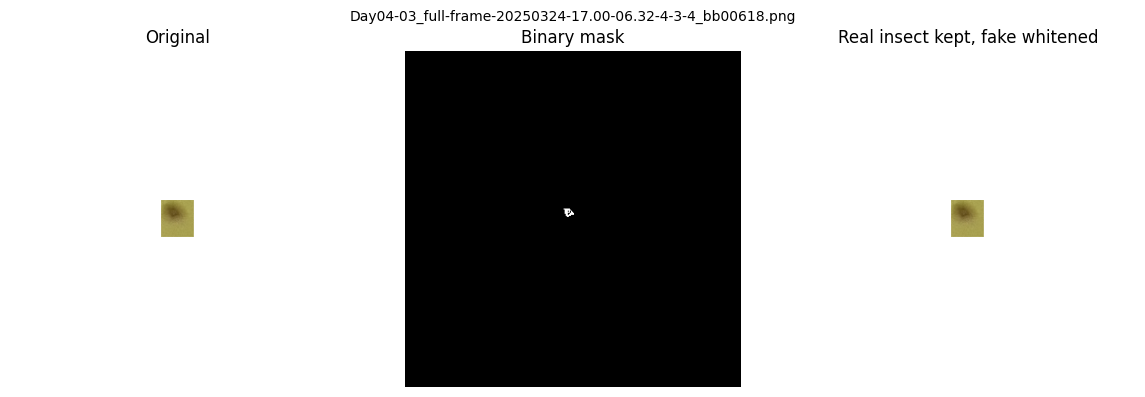

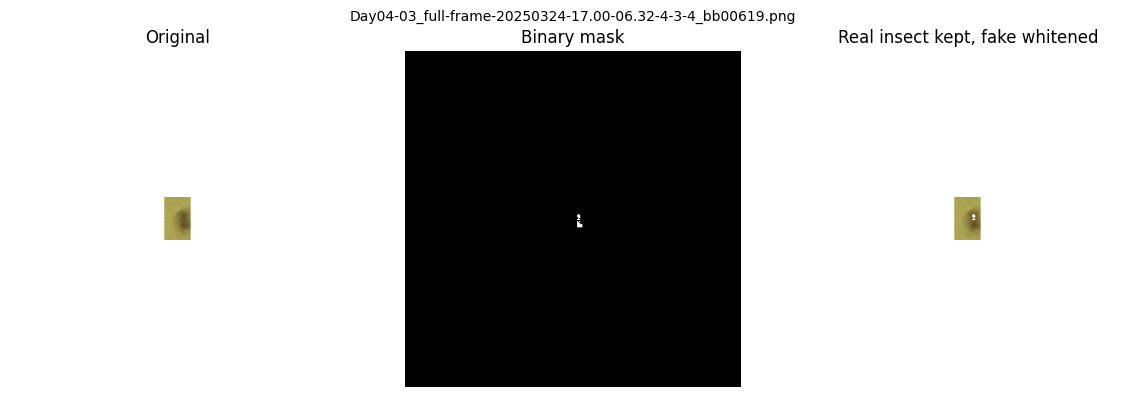

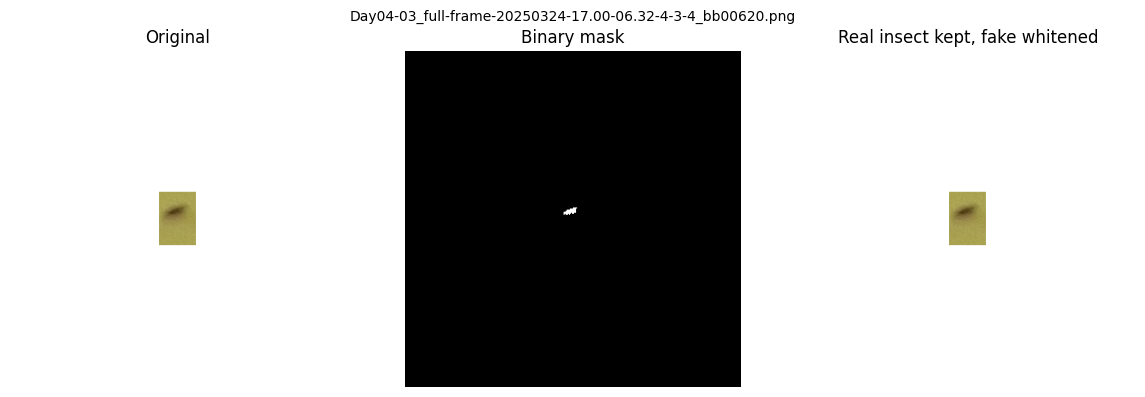

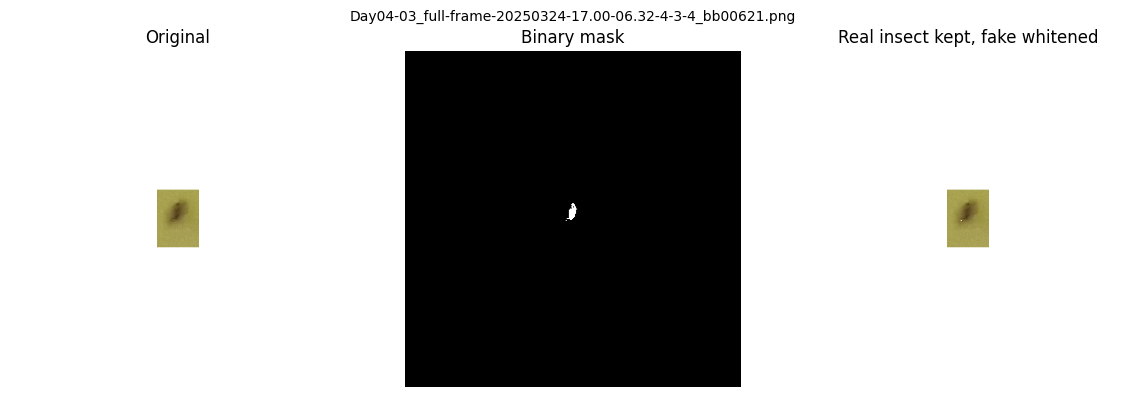

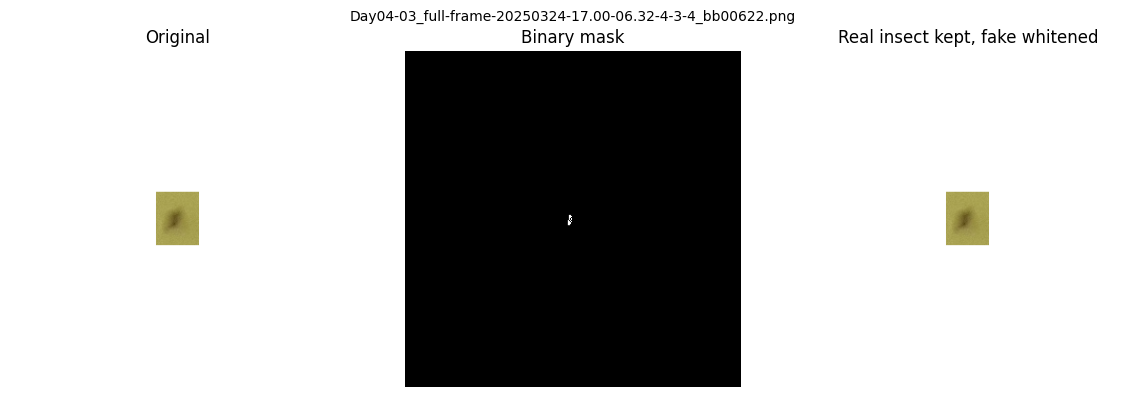

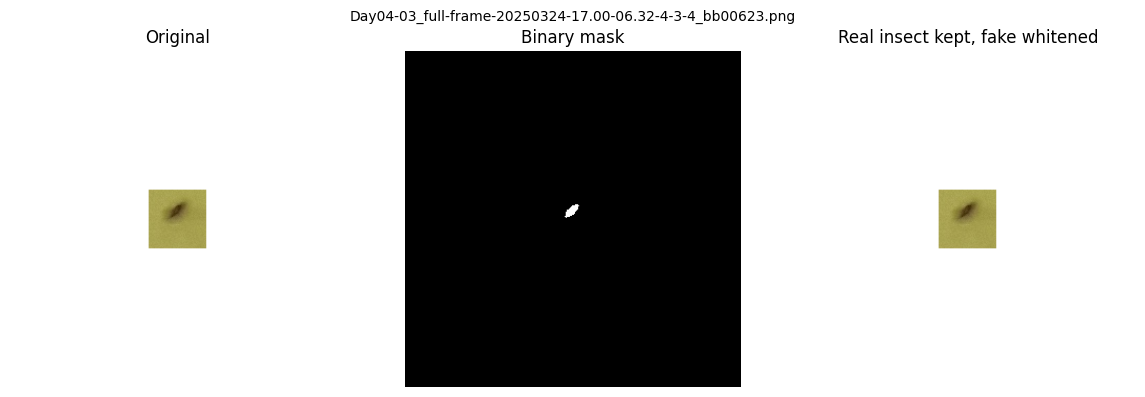

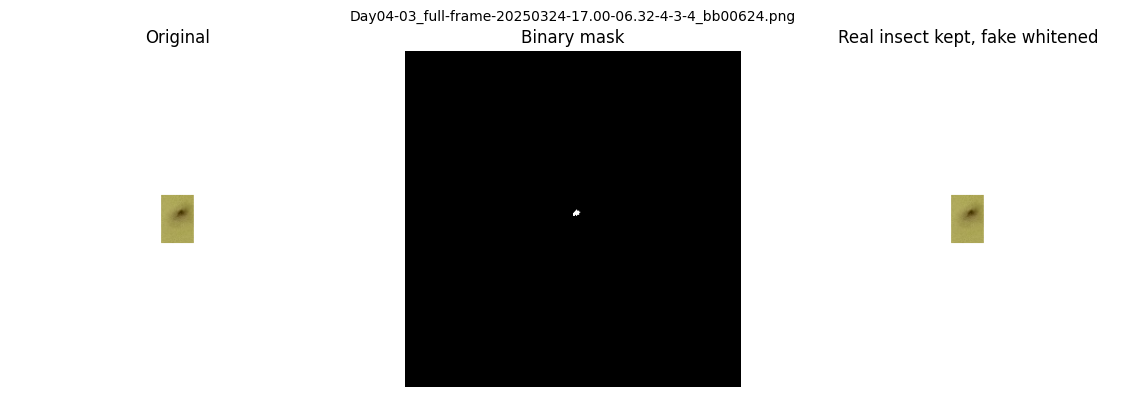

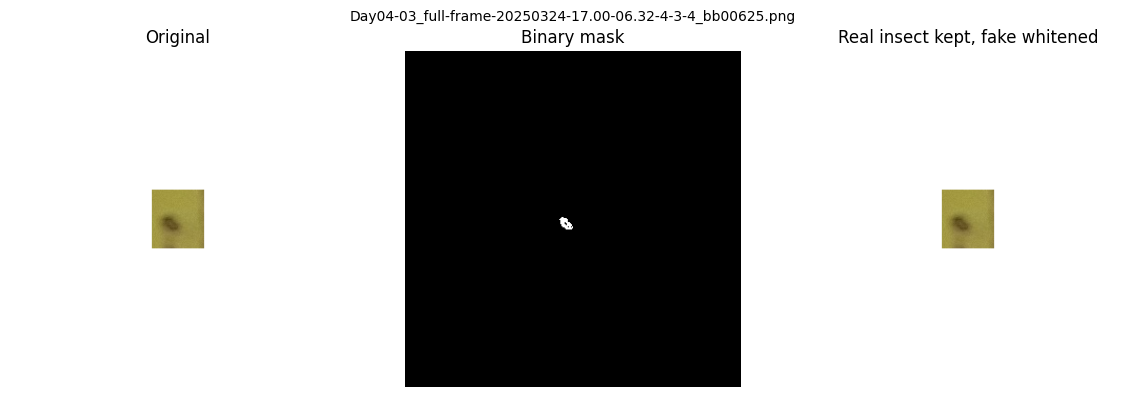

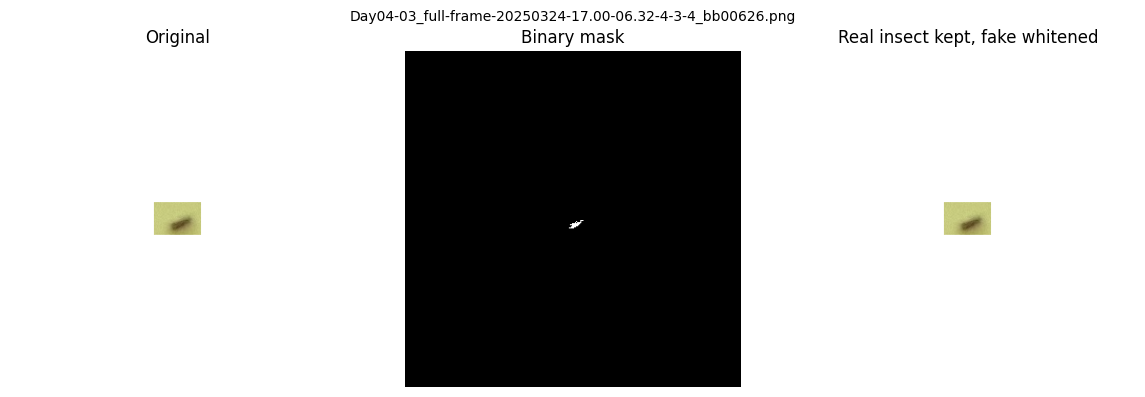

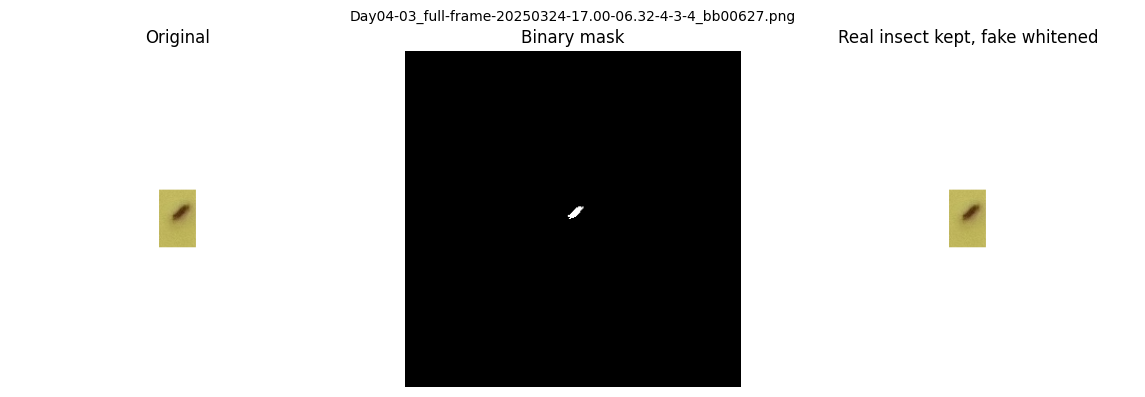

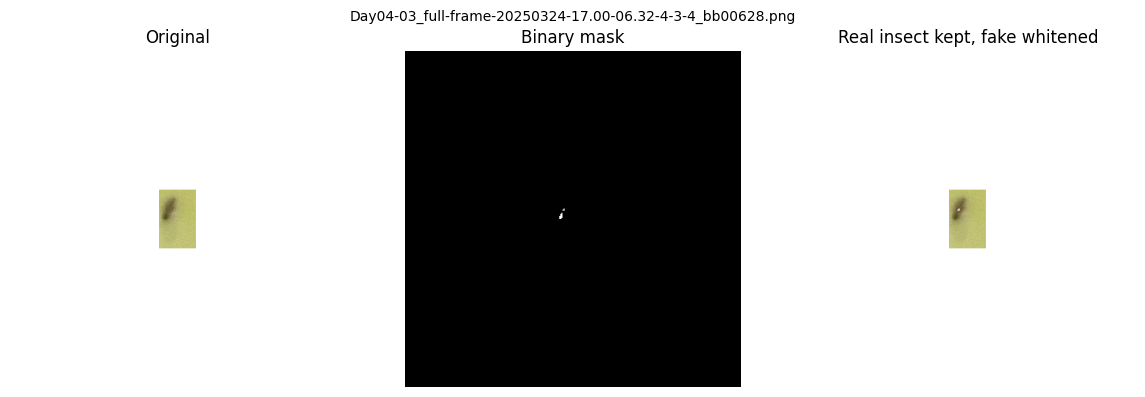

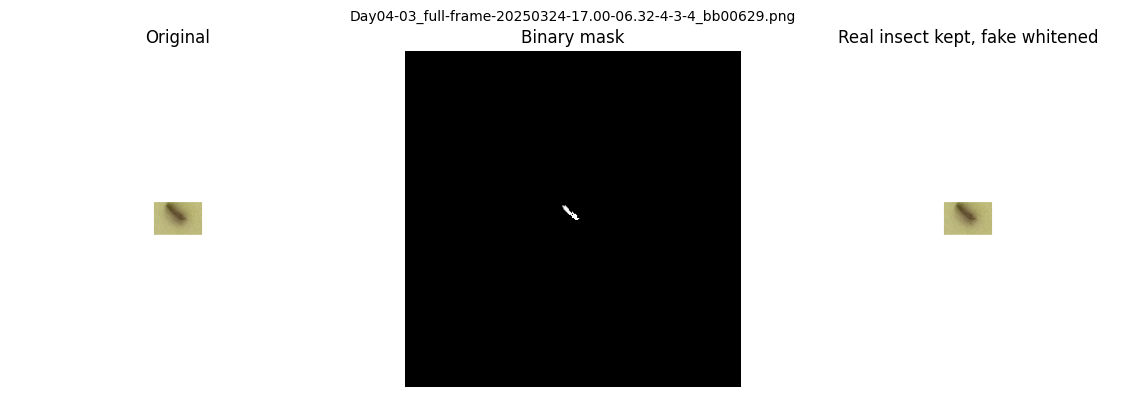

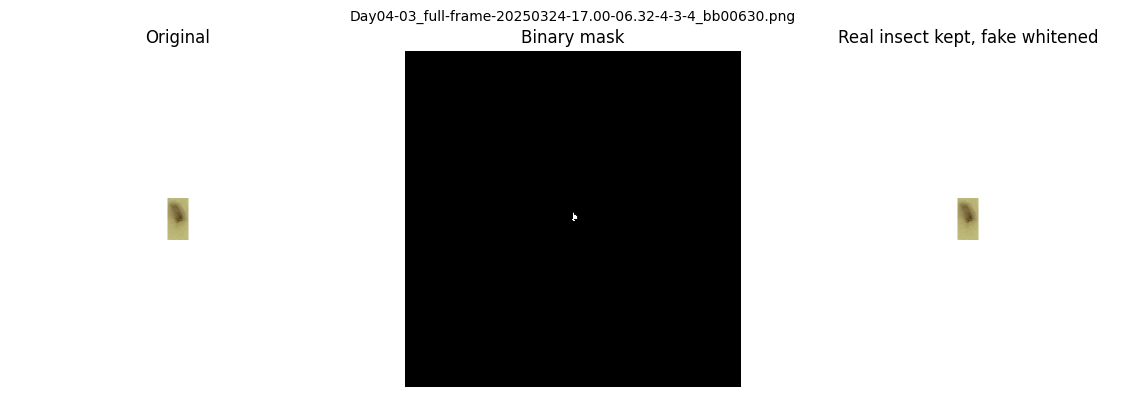

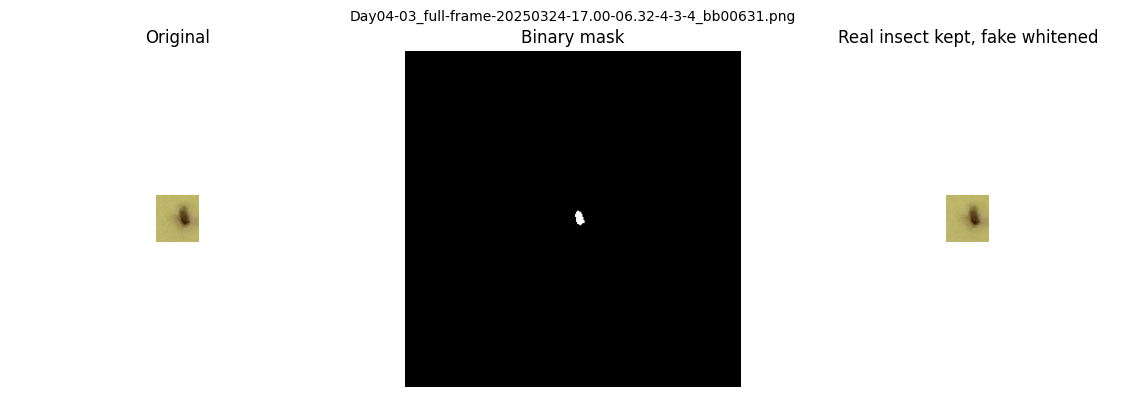

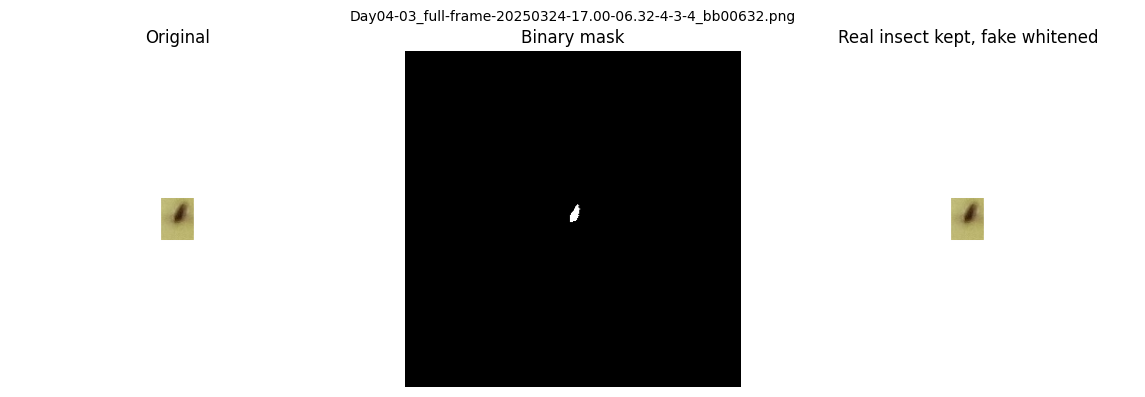

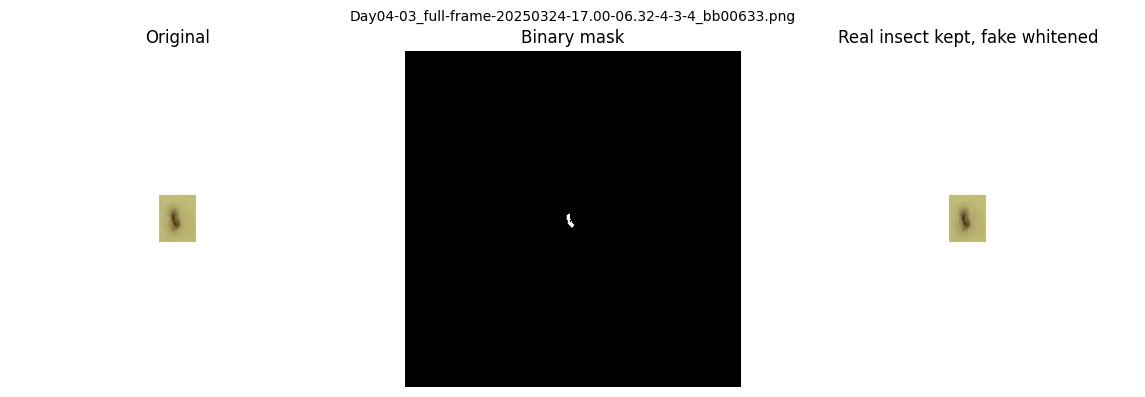

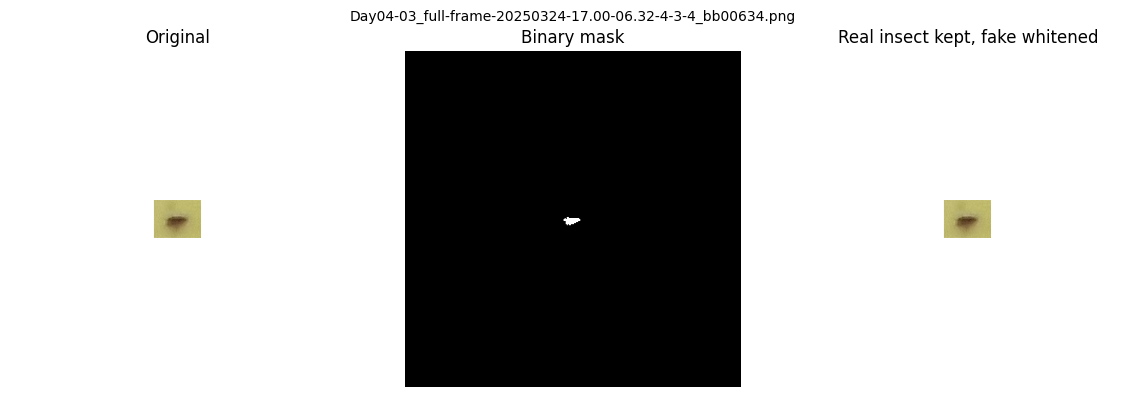

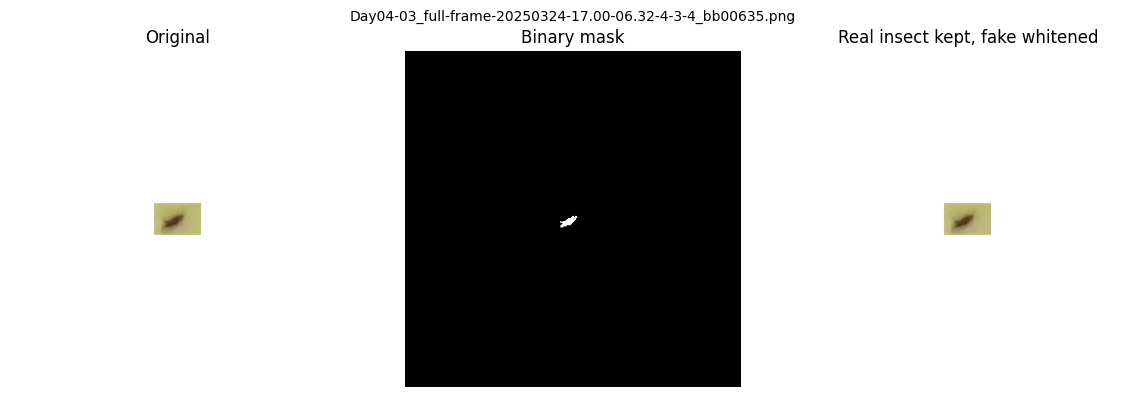

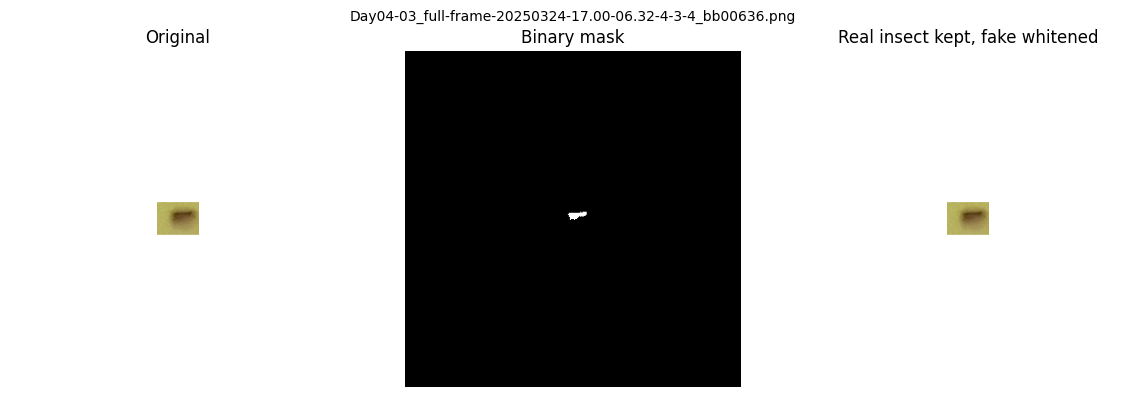

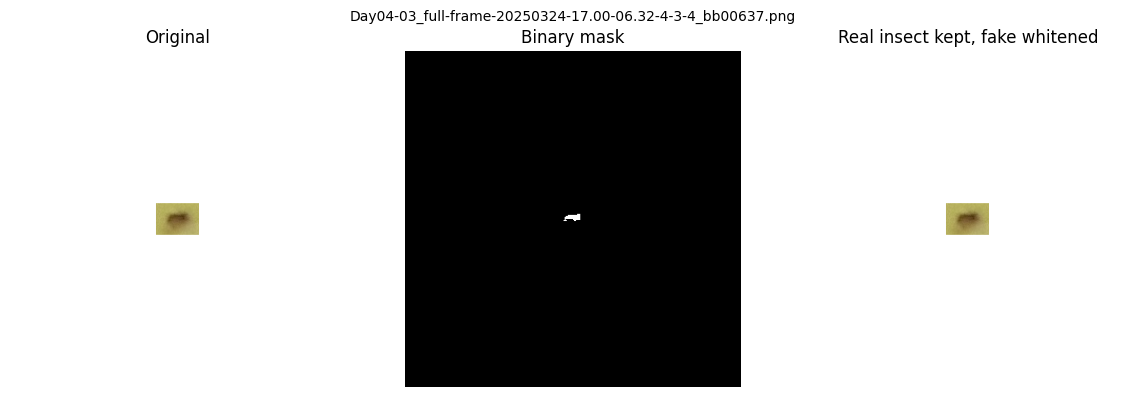

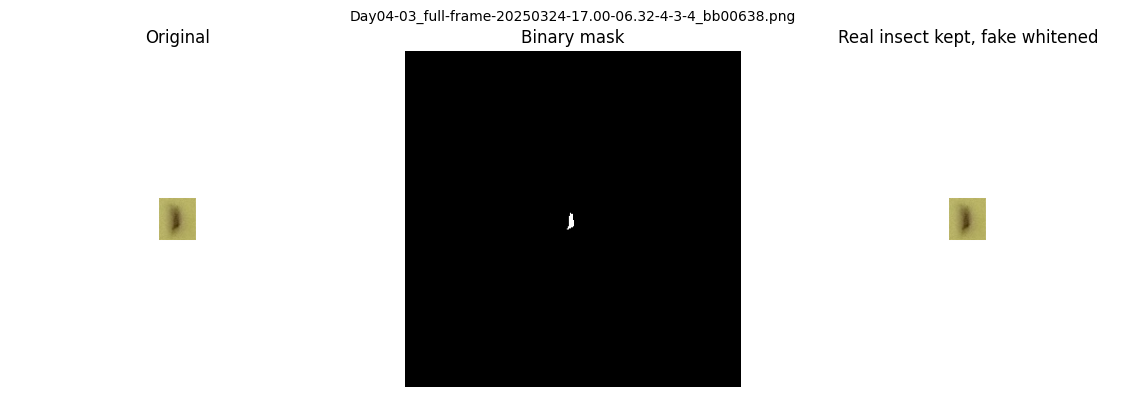

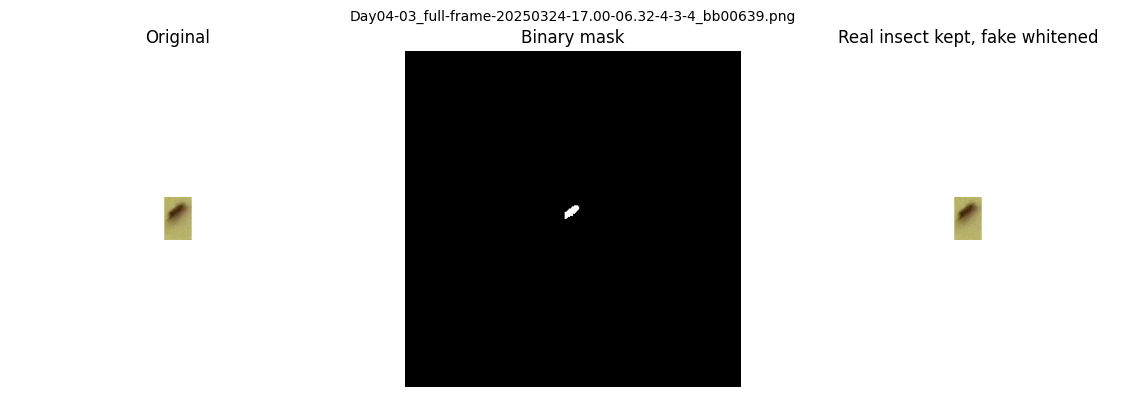

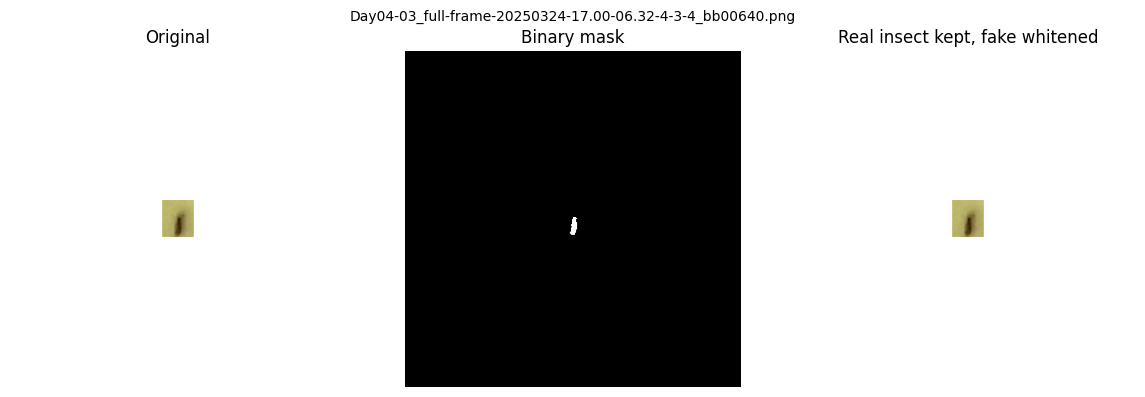

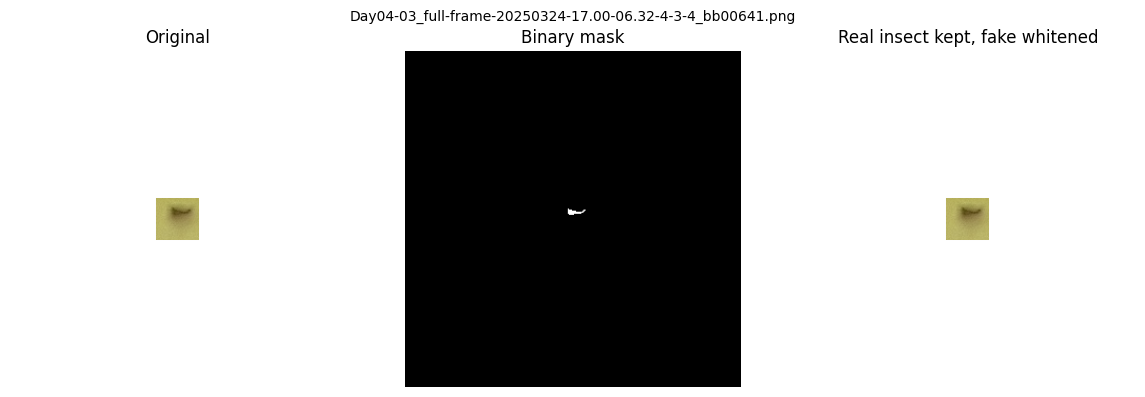

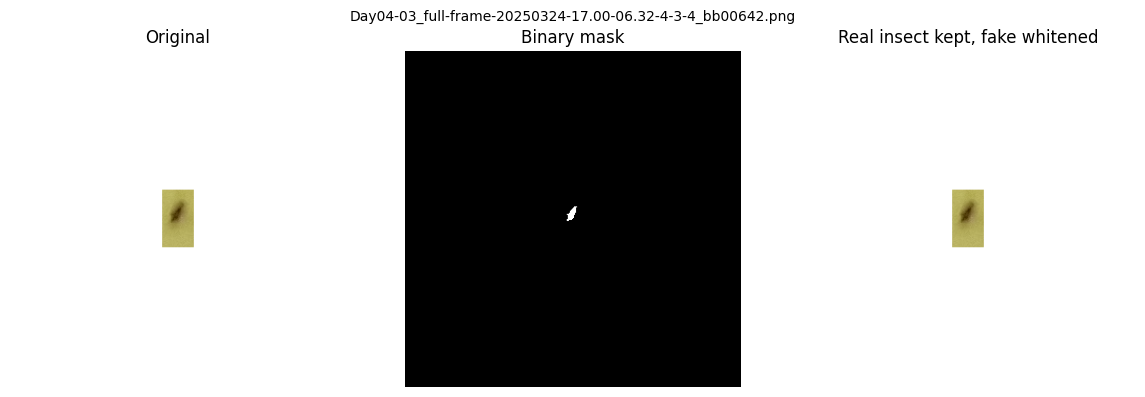

KeyboardInterrupt: 

In [3]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np 

roi_folder = "/kaggle/working/roi_extracted"
roi_files = sorted([f for f in os.listdir(roi_folder) if f.lower().endswith((".png", ".jpg", ".jpeg"))])

print("Found", len(roi_files), "ROI images.")

for fname in roi_files:
    img_path = os.path.join(roi_folder, fname)
    img = cv2.imread(img_path)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Binary threshold to isolate insects
    _, binary = cv2.threshold(gray, 90, 255, cv2.THRESH_BINARY_INV)

    # Connected components
    num_labels, labels = cv2.connectedComponents(binary)

    # --- Identify real insect (largest component) ---
    largest_label = None
    largest_area = 0

    for lbl in range(1, num_labels):   # skip background = 0
        area = np.sum(labels == lbl)
        if area > largest_area:
            largest_area = area
            largest_label = lbl

    # --- Create mask of all fake components ---
    fake_mask = (labels != 0) & (labels != largest_label)
    fake_mask = fake_mask.astype(np.uint8)

    # --- Whiten fake insect parts ---
    result = img.copy()
    result[fake_mask == 1] = [255, 255, 255]   # make fake parts white

    # ---- Visualization ----
    plt.figure(figsize=(12, 4))

    # Original
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis('off')

    # Binary mask
    plt.subplot(1, 3, 2)
    plt.imshow(binary, cmap='gray')
    plt.title("Binary mask")
    plt.axis('off')

    # Result: real insect kept, fake whitened
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title("Real insect kept, fake whitened")
    plt.axis('off')

    plt.suptitle(fname, fontsize=10)
    plt.tight_layout()
    plt.show()